<a href="https://colab.research.google.com/github/brad0taylor/Graph/blob/master/alu_vdemo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ALU Demo
* NN is used to emulate classic ALU with Add/Sub, Bitwise, Trig functions
* Setup for values between -100 and +100


## Import Modules

In [0]:
from __future__ import print_function
import keras.backend as K 
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.utils  import to_categorical
from keras import regularizers
from keras.layers import RNN, dot
from keras import optimizers



import os
import numpy as np
import math

import tensorflow as tf
from tensorflow.python.client import device_lib

dbug=0

if(dbug> 0): print(device_lib.list_local_devices())
print('tensorflow version=' , tf.__version__)


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


tensorflow version= 1.14.0
Found GPU at: /device:GPU:0


In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import  sys
def printf(format, *args):
#    print(format % args )
    sys.stdout.write(format % args)
    
#printf('x0=%f3', x[0,0] )

In [0]:
#from keras.applications import VGG16
#
#from vis.losses import ActivationMaximization
#from vis.regularizers import TotalVariation, LPNorm
#from vis.input_modifiers import Jitter
#from vis.optimizer import Optimizer
#from vis.callbacks import GifGenerator
#
## Build the VGG16 network with ImageNet weights
#model = VGG16(weights='imagenet', include_top=True)
#print('Model loaded.')
#
## The name of the layer we want to visualize
## (see model definition in vggnet.py)
#layer_name = 'predictions'
#layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
#output_class = [20]
#
#losses = [
#    (ActivationMaximization(layer_dict[layer_name], output_class), 2),
#    (LPNorm(model.input), 10),
#    (TotalVariation(model.input), 10)
#]
#opt = Optimizer(model.input, losses)
#opt.minimize(max_iter=500, verbose=True, input_modifiers=[Jitter()], callbacks=[GifGenerator('opt_progress')])

In [0]:
if(dbug>1):
    print('GPU')
    !nvidia-smi
    
    #no.of cores each processor is having 
    print('CPU cores')
    !lscpu | grep 'Core(s) per socket:'
     
    # no.of threads each core is having 
    print('CPU Threads')
    !lscpu | grep 'Thread(s) per core'
    
    print('L3')
    !lscpu | grep "L3 cache"
    
    #if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
    print('Freq')
    !lscpu | grep "MHz"
    
    #memory that we can use
    print('mem avail')
    !cat /proc/meminfo | grep 'MemAvailable'
    
    print('Disk')
    !df -h / | awk '{print $4}'
    
    #hard disk that we can use
    print('Disk avail')
    !df -h / | awk '{print $4}'




##Utility Functions

In [0]:
def bit_count(n):
      assert n >= 0, 'Argument of bit_count() must be non-negative'
      count = 0
      while n:
          n &= n - 1
          count += 1
      return count
  
if(dbug>1): 
    for i in range(10) :
      ii=int(i)
      bits= bit_count(i)
      print(bin(ii),bits)
  

##Create 26 opcodes by initialization patterns

In [0]:
def rot_cos(i,j) :
    a = xval[i+j,1]/100 #scale to convert to rotation
    r = np.arcsin(a)
    b = np.cos(r) * 100
    return b




def int_to_gray(i):
    i=i+0x8000 # make unsigned
    g = i^ ( i >> 1)
    return g

def uint_to_gray(i):
    g = i^ ( i >> 1)
    return g



def gray_to_intx(g) :
    
    i = (g              ) & 0x8000
    i|= (g  ^  (i >> 1 )) & 0x4000
    i|= (g  ^  (i >> 1 )) & 0x2000
    i|= (g  ^  (i >> 1 )) & 0x1000
    i|= (g  ^  (i >> 1 )) & 0x0800
    i|= (g  ^  (i >> 1 )) & 0x0400
    i|= (g  ^  (i >> 1 )) & 0x0200
    i|= (g  ^  (i >> 1 )) & 0x0100
    i|= (g  ^  (i >> 1 )) & 0x0080
    i|= (g  ^  (i >> 1 )) & 0x0040
    i|= (g  ^  (i >> 1 )) & 0x0020
    i|= (g  ^  (i >> 1 )) & 0x0010
    i|= (g  ^  (i >> 1 )) & 0x0008
    i|= (g  ^  (i >> 1 )) & 0x0004
    i|= (g  ^  (i >> 1 )) & 0x0002
    i|= (g  ^  (i >> 1 )) & 0x0001

    return (i-0x8000)
 
def gray_to_uintx(g) :
    
    i = (g              ) & 0x8000
    i|= (g  ^  (i >> 1 )) & 0x4000
    i|= (g  ^  (i >> 1 )) & 0x2000
    i|= (g  ^  (i >> 1 )) & 0x1000
    i|= (g  ^  (i >> 1 )) & 0x0800
    i|= (g  ^  (i >> 1 )) & 0x0400
    i|= (g  ^  (i >> 1 )) & 0x0200
    i|= (g  ^  (i >> 1 )) & 0x0100
    i|= (g  ^  (i >> 1 )) & 0x0080
    i|= (g  ^  (i >> 1 )) & 0x0040
    i|= (g  ^  (i >> 1 )) & 0x0020
    i|= (g  ^  (i >> 1 )) & 0x0010
    i|= (g  ^  (i >> 1 )) & 0x0008
    i|= (g  ^  (i >> 1 )) & 0x0004
    i|= (g  ^  (i >> 1 )) & 0x0002
    i|= (g  ^  (i >> 1 )) & 0x0001

    return (i)
    
     
for  i in range (0*1024-16,0*1024+16) :    
    g=int_to_gray(i)
    gg=uint_to_gray(g)
    ii=gray_to_uintx(gg)
    ix=gray_to_intx(ii)
    
    print('gray(', i,')=',i, bin(i|0x10000), 'g=', g, bin(g|0x10000), 'gg=', gg, bin(gg|0x10000), 'ii=', ii, bin(ii|0x10000), 'ix=', ix, bin(ix|0x10000))
#    



gray( -16 )= -16 -0b10000 g= 16392 0b10100000000001000 gg= 24588 0b10110000000001100 ii= 16392 0b10100000000001000 ix= -16 -0b10000
gray( -15 )= -15 -0b1111 g= 16393 0b10100000000001001 gg= 24589 0b10110000000001101 ii= 16393 0b10100000000001001 ix= -15 -0b1111
gray( -14 )= -14 -0b1110 g= 16395 0b10100000000001011 gg= 24590 0b10110000000001110 ii= 16395 0b10100000000001011 ix= -14 -0b1110
gray( -13 )= -13 -0b1101 g= 16394 0b10100000000001010 gg= 24591 0b10110000000001111 ii= 16394 0b10100000000001010 ix= -13 -0b1101
gray( -12 )= -12 -0b1100 g= 16398 0b10100000000001110 gg= 24585 0b10110000000001001 ii= 16398 0b10100000000001110 ix= -12 -0b1100
gray( -11 )= -11 -0b1011 g= 16399 0b10100000000001111 gg= 24584 0b10110000000001000 ii= 16399 0b10100000000001111 ix= -11 -0b1011
gray( -10 )= -10 -0b1010 g= 16397 0b10100000000001101 gg= 24587 0b10110000000001011 ii= 16397 0b10100000000001101 ix= -10 -0b1010
gray( -9 )= -9 -0b1001 g= 16396 0b10100000000001100 gg= 24586 0b10110000000001010 ii= 16

In [0]:
def int_to_xcode(i):
    i=i^32*1024 # make unsigned

    x = i ^ (i >> 1) ^ (i >> 2) ^ (i >> 3)^ (i >> 4)
     
    return x

for  i in range (-16,16) :    
    x=int_to_xcode(i)
    print('xcode(', i,')=',i, bin(i), x, bin(x))


xcode( -16 )= -16 -0b10000 -63499 -0b1111100000001011
xcode( -15 )= -15 -0b1111 -63500 -0b1111100000001100
xcode( -14 )= -14 -0b1110 -63498 -0b1111100000001010
xcode( -13 )= -13 -0b1101 -63497 -0b1111100000001001
xcode( -12 )= -12 -0b1100 -63502 -0b1111100000001110
xcode( -11 )= -11 -0b1011 -63501 -0b1111100000001101
xcode( -10 )= -10 -0b1010 -63503 -0b1111100000001111
xcode( -9 )= -9 -0b1001 -63504 -0b1111100000010000
xcode( -8 )= -8 -0b1000 -63494 -0b1111100000000110
xcode( -7 )= -7 -0b111 -63493 -0b1111100000000101
xcode( -6 )= -6 -0b110 -63495 -0b1111100000000111
xcode( -5 )= -5 -0b101 -63496 -0b1111100000001000
xcode( -4 )= -4 -0b100 -63491 -0b1111100000000011
xcode( -3 )= -3 -0b11 -63492 -0b1111100000000100
xcode( -2 )= -2 -0b10 -63490 -0b1111100000000010
xcode( -1 )= -1 -0b1 -63489 -0b1111100000000001
xcode( 0 )= 0 0b0 63488 0b1111100000000000
xcode( 1 )= 1 0b1 63489 0b1111100000000001
xcode( 2 )= 2 0b10 63491 0b1111100000000011
xcode( 3 )= 3 0b11 63490 0b1111100000000010
xcode(

(640000, 1, 36) (640000, 1)


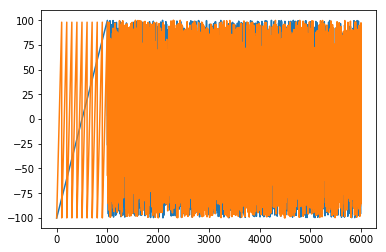

i= 0 v= 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in sqrt


opcodes= 32 ['cst0' 'sign' 'sela' 'selb' 'max' 'min' 'abs' 'add' 'sub' 'mult' 'div'
 'mod' 'log' 'sqrt' 'exp' 'tanh' 'sin' 'cos' 'xsin' 'xcos' 'bit0' 'and'
 'or' 'xor' 'rand' 'rxor' 'ror' 'bitx' 'inta' 'intb' 'shft' 'popc']
(640000, 1, 36) (640000, 1)


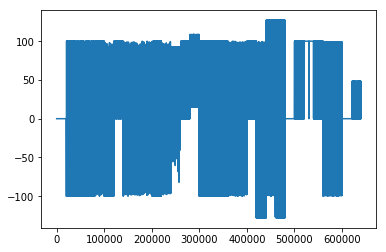

[ 999,0] op=cst0 opA=99.80 opB=98.00 out=   +0.00  ---- A= 63cc B= 6200 O=    0 --- a=       0b1100011 b=       0b1100010 o=                             0b0 
[20999,0] op=sign opA=99.80 opB=98.00 out= +100.00  ---- A= 63cc B= 6200 O= 6400 --- a=       0b1100011 b=       0b1100010 o=                       0b1100100 
[40999,0] op=sela opA=99.80 opB=98.00 out=  +99.80  ---- A= 63cc B= 6200 O= 63cc --- a=       0b1100011 b=       0b1100010 o=                       0b1100011 
[60999,0] op=selb opA=99.80 opB=98.00 out=  +98.00  ---- A= 63cc B= 6200 O= 6200 --- a=       0b1100011 b=       0b1100010 o=                       0b1100010 
[80999,0] op= max opA=99.80 opB=98.00 out=  +99.80  ---- A= 63cc B= 6200 O= 63cc --- a=       0b1100011 b=       0b1100010 o=                       0b1100011 
[100999,0] op= min opA=99.80 opB=98.00 out=  +98.00  ---- A= 63cc B= 6200 O= 6200 --- a=       0b1100011 b=       0b1100010 o=                       0b1100010 
[120999,0] op= abs opA=99.80 opB=98.00 out=  +

In [0]:
#make the ops
#x=np.vstack((np.random.rand(1000,10),-np.random.rand(1000,10)))
#y=np.vstack((np.ones((1000,1)),np.zeros((1000,1))))

scale =  200
offset = 100

nvars=4
nops=32
opsize=1000*20 #1 enumerated, 9 random train, 10 random val
topsize=int(opsize/2)

nset=1
nsamp = nops*opsize*nset
tsamp = int(nsamp/2)
ncat  = 100
nbits = 16

x=np.random.random((nsamp,1,nops+nvars))*scale-offset
y=np.zeros((nsamp,1))



op  = np.zeros(nsamp,int)
op  = op.astype(str)

opcodes  = np.zeros(nops)
opcodes  = opcodes.astype(str)
opcode=0



if 1 :
  # initialize initial data with ramps
  for i in range(int(nsamp/opsize/nset)) :
    for j in range (10) :
      for k in range(100) :
        x[i*opsize+j*100+k,0,0]=(j/10+k/1000 )*scale-offset
        x[i*opsize+j*100+k,0,1]=(k*1/100     )*scale-offset
        x[i*opsize+j*100+k+topsize,0,0]=(j/10+k/1000 )*scale-offset
        x[i*opsize+j*100+k+topsize,0,1]=(k*1/100     )*scale-offset
    
print(x.shape, y.shape)
plt.plot(x [40000:46000,0,0:2],'-')
#plt.plot(y [0:nsamp], '-')
#plt.plot(yo[0:nsamp], '-')
plt.show()

  


i=0;
for v in range(nset) :
  print('i=',i,'v=',v)
  opcode=0
  if(1) :
    
    # cst0
    n=opsize 
    x[ i:i+n,:,nvars:nops+nvars] =  to_categorical(opcode, nops)
    y[ i:i+n,:     ] = 0
    op[i:i+n]='cst0'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
    
    # sign 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = np.sign(x[i:i+n,:,0]  )*100
    op[i:i+n]='sign'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
  
  if(1) :
    # sela
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = x[ i:i+n,:,0]
    op[i:i+n]='sela'
    opcodes[opcode]=op[i]
    i=i+n; opcode=opcode+1
    
    #selb 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = x[ i:i+n,:,1]
    op[i:i+n]='selb'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
  
 
  if (1) :
    # max 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = np.maximum( x[i:i+n,:,0] ,  x[i:i+n,:,1] )
    op[i:i+n]='max'
    opcodes[opcode]=op[i]
    i=i+n; opcode=opcode+1
    
    # min 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = np.minimum(x[i:i+n,:,0] ,  x[i:i+n,:,1] )
    op[i:i+n]='min'
    opcodes[opcode]=op[i]
    i=i+n; opcode=opcode+1
    
    
    # abs 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = np.abs(x[i:i+n,:,0]  )
    op[i:i+n]='abs'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1

  if(1) :
  
    # add 
    n=opsize 
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = x[i:i+n,:,0]/2 + x[i:i+n,:,1]/2 
    op[i:i+n]='add'
    opcodes[opcode]=op[i]
    i=i+n; opcode=opcode+1
    
  if(1)  :
    # sub 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = x[i:i+n,:,0]/2 - x[i:i+n,:,1]/2 
    op[i:i+n]='sub'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
  
  if(1) :
    # mult 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = x[i:i+n,:,0] * x[i:i+n,:,1] / 100
    op[i:i+n]='mult'
    opcodes[opcode]=op[i]
    i=i+n; opcode=opcode+1
  
  if(1) :  
    # div 
    n=opsize 
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      if x[i+j,:,1]!=0 :
        y[ i+j,0     ] = np.maximum(-100,np.minimum(100,x[i+j,0,0] / x[i+j,0,1]))
      else :
        y[ i+j,0     ] = 0
    op[i:i+n]='div'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
    
    # mod 
    n=opsize 
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      if x[i+j,:,1]!=0 :
        y[ i+j,0     ] = np.maximum(-100,np.minimum(100, x[i+j,0,0] % x[i+j,0,1]))
      else :
        y[ i+j,0     ] = 0
    op[i:i+n]='mod'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
   
  if(1):

    # log 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      if x[i+j,0,0]>0 :
        y[ i+j,0     ] = min(100,np.log(x[i+j,0,0] )*20)
      else :
        y[ i+j,0     ] = 0
    op[i:i+n]='log'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
  
    # sqrt 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      y[ i+j,0     ]= max(0,np.sqrt(x[i+j,0,0] )*10 )
    op[i:i+n]='sqrt'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
  
  
    # e^x 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      y[ i+j,0     ]= min(200,np.exp(x[i+j,0,0]/100 )*40 )
    op[i:i+n]='exp'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
    
    # tanh 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = np.tanh(x[i:i+n,:,0]/scale*3.14*4)*100
    op[i:i+n]='tanh'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
  
    # sin 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = np.sin(x[i:i+n,:,0]/scale*3.14*4 )*100
    op[i:i+n]='sin'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
    
    # cos 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = np.cos(x[i:i+n,:,0]/scale*3.14*4 )*100
    op[i:i+n]='cos'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
    
    # xsin 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = np.sin(x[i:i+n,:,0]/scale*3.14*4 )*x[i:i+n,:,1]
    op[i:i+n]='xsin'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
    
    # xcos 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    y[ i:i+n,:     ] = np.cos(x[i:i+n,:,0]/scale*3.14*4 )*x[i:i+n,:,1]
    op[i:i+n]='xcos'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
  
    
  if(1) :
  
    
    # bit 0
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      
      y[ i+j,0     ] = ((np.int(x[i+j,:,0])) & 1)*100
    op[i:i+n]='bit0'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1

    # and
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      y[ i+j,0     ] = (np.int(x[i+j,:,0]) & np.int(x[i+j,:,1])  )
    op[i:i+n]='and'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
    
    
    # or
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] =to_categorical(opcode, nops)
    for j in range(n):
      y[ i+j,0     ] = (np.int(x[i+j,:,0]) | np.int(x[i+j,:,1])  )
    op[i:i+n]='or'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
    
     # xor
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      y[ i+j,0     ] = (np.int(x[i+j,:,0]) ^ np.int(x[i+j,:,1])  )
    op[i:i+n]='xor'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
  
  
  
    # reduction ran
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      rop=0
      for k in range (nbits) :
        rop = rop & ((np.int(x[i+j,:,0]*256)>>k) & 1)
      y[ i+j,0  ] = rop * 100
    op[i:i+n]='rand'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1

    # reduction xor
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      rop=0
      for k in range (nbits) :
        rop = rop ^ ((np.int(x[i+j,:,0]*256)>>k) & 1)
      y[ i+j,0  ] = rop * 100
    op[i:i+n]='rxor'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
  
    # reduction or
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      rop=0
      for k in range (nbits) :
        rop = rop | ((np.int(x[i+j,:,0]*256)>>k) & 1)
      y[ i+j,0  ] = rop * 100
    op[i:i+n]='ror'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1

    # bit extract
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      
      y[ i+j,0     ] = ((np.int(x[i+j,:,0])*256)>>max(0,min(16,np.int(x[i+j,:,1]/4))) & 1)*100
    op[i:i+n]='bitx'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
  
    # inta 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      y[ i+j,0     ] = (np.int(x[i+j,:,0])) 
    op[i:i+n]='inta'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
  
    # intb 
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      y[ i+j,0     ] = (np.int(x[i+j,:,1])) 
    op[i:i+n]='intb'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
  
    # shift up 
    n=opsize 
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      y[ i+j,0     ] = (np.int(x[i+j,:,0]/256) << max(0,min(16,np.int(x[i+j,:,1]/4) )) )
    op[i:i+n]='shft'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1
  
  
    # bitcount
    n=opsize
    x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
    for j in range(n):
      y[ i+j,0     ] = bit_count(max(0,np.int(x[i+j,:,0]))) * 8
    op[i:i+n]='popc'
    opcodes[opcode]=op[i]
    i=i+n;  opcode=opcode+1




print("opcodes=", opcode, opcodes[0:opcode])

print(x.shape, y.shape)
plt.plot(y [0:nsamp,0],'-')
#plt.plot(y [0:nsamp], '-')
#plt.plot(yo[0:nsamp], '-')
plt.show()





#xcat0= np.zeros((nsamp,100))
#xcat1= np.zeros((nsamp,100))

model='alu1'

for ii  in range (0,int(nsamp),int(nsamp/nops/nset)) :
  for t in range (1) :   
    i=ii+999 
    printf('[%4d,%d] op=%4s opA=%2.2f opB=%2.2f out=%+8.2f  ---- A=%5x B=%5x O=%5x --- a=%16s b=%16s o=%32s \n', i, t, op[i], x[i,t,0], x[i,t,1], y[i], int(x[i,t,0]*256), int(x[i,t,1]*256), int(y[i]*256) , bin(int(x[i,t,0])), bin(int(x[i,t,1])), bin(int(y[i])))



In [0]:
#split the data into val and training
#keep it simple with all these arrays

xval=np.zeros((tsamp,nvars+nops))
yval=np.zeros((tsamp,1))
xx  =np.zeros((tsamp,nvars+nops))
yy  =np.zeros((tsamp,1))

xbit0= np.zeros((tsamp,nbits))
xbit1= np.zeros((tsamp,nbits))
xbit2= np.zeros((tsamp,nbits))
xbit3= np.zeros((tsamp,nbits))

xvbit0= np.zeros((tsamp,nbits))
xvbit1= np.zeros((tsamp,nbits))
xvbit2= np.zeros((tsamp,nbits))
xvbit3= np.zeros((tsamp,nbits))
ybit  = np.zeros((tsamp,nbits))
yvbit = np.zeros((tsamp,nbits))

#add redundant encoding fields
ycbit  = np.zeros((tsamp,nbits))
yvcbit = np.zeros((tsamp,nbits))

for op in range(0,nops) :
    i =op*topsize
    ii=op*opsize
    printf('.')
    for j in range (topsize) :
        
        xx  [i+j,:]=x[ii+j+topsize,0,:]
        yy  [i+j]  =y[ii+j+topsize]
        
        a = xx[i+j,0]/100 #scale to convert to rotation
        r = np.arcsin(a)
        b = np.cos(r)
        xx[i+j,2]=b*100
        
        a = xx[i+j,1]/100 #scale to convert to rotation
        r = np.arcsin(a)
        b = np.cos(r)
        xx[i+j,3]=b*100
        

        xval[i+j,:]=x[ii+j,0,:]
        yval[i+j]  =y[ii+j]
        
        a = xval[i+j,0]/100 #scale to convert to rotation
        r = np.arcsin(a)
        b = np.cos(r)
        xval[i+j,2]=b*100
        
        a = xval[i+j,1]/100 #scale to convert to rotation
        r = np.arcsin(a)
        b = np.cos(r)
        xval[i+j,3]=b*100
        
    

        for k in range (16) :
            #xbit0 [i+j,k] = (int_to_gray(np.int(xx  [i+j,0]*256))>>k)&1
            #xbit1 [i+j,k] = (int_to_gray(np.int(xx  [i+j,1]*256))>>k)&1
    #
            #xvbit0[i+j,k] = (int_to_gray(np.int(xval[i+j,0]*256))>>k)&1
            #xvbit1[i+j,k] = (int_to_gray(np.int(xval[i+j,1]*256))>>k)&1

            xbit0 [i+j,k] = (np.int(xx  [i+j,0]*256)>>k)&1
            xbit1 [i+j,k] = (np.int(xx  [i+j,1]*256)>>k)&1
            xbit2 [i+j,k] = (np.int(xx  [i+j,2]*256)>>k)&1
            xbit3 [i+j,k] = (np.int(xx  [i+j,3]*256)>>k)&1
            #xbit2 [i+j,k] = (int_to_gray(np.int(xx  [i+j,0]*256))>>k)&1
            #xbit3 [i+j,k] = (int_to_gray(np.int(xx  [i+j,1]*256))>>k)&1
            #xbit2 [i+j,k] = (gray_to_intx(np.int(xx  [i+j,0]*256))>>k)&1
            #xbit3 [i+j,k] = (gray_to_intx(np.int(xx  [i+j,1]*256))>>k)&1
    
            xvbit0[i+j,k] = (np.int(xval[i+j,0]*256)>>k)&1
            xvbit1[i+j,k] = (np.int(xval[i+j,1]*256)>>k)&1
            xvbit2[i+j,k] = (np.int(xval[i+j,2]*256)>>k)&1
            xvbit3[i+j,k] = (np.int(xval[i+j,3]*256)>>k)&1
            #xvbit2[i+j,k] = (int_to_gray(np.int(xval  [i+j,0]*256))>>k)&1
            #xvbit3[i+j,k] = (int_to_gray(np.int(xval  [i+j,1]*256))>>k)&1
            #xvbit2[i+j,k] = (gray_to_intx(np.int(xval  [i+j,0]*256))>>k)&1
            #xvbit3[i+j,k] = (gray_to_intx(np.int(xval  [i+j,1]*256))>>k)&1

            ybit  [i+j,k] = (np.int(yy  [i+j  ]*256)>>k)&1
            yvbit [i+j,k] = (np.int(yval[i+j  ]*256)>>k)&1
            
            #add a second output bits are scaled up by 150% which shifts each bit
            #ycbit  [i+j,k] = (np.int(yy  [i+j ]*256*.99)>>k)&1
            #yvcbit [i+j,k] = (np.int(yval[i+j ]*256*.99)>>k)&1
            
            #graycode
            #cbit  [i+j,k] = (uint_to_gray(int_to_gray(np.int(yy  [i+j ]*256)))>>k)&1
            #yvcbit [i+j,k] = (uint_to_gray(int_to_gray(np.int(yval[i+j ]*256)))>>k)&1
            ycbit  [i+j,k] = ((int_to_gray(np.int(yy  [i+j ]*256)))>>k)&1
            yvcbit [i+j,k] = ((int_to_gray(np.int(yval[i+j ]*256)))>>k)&1
            #ycbit  [i+j,k] = (gray_to_intx(np.int(yy  [i+j ]*256))>>k)&1
            #yvcbit [i+j,k] = (gray_to_intx(np.int(yval[i+j ]*256))>>k)&1
            
printf('x done')

................................x done

In [0]:
#split the data into val and training
# add create 9 duplicate  fields for 
#print(ninp,x.shape)


if 0 :
    #finc=.003
    
    
    xval=np.zeros((tsamp,9*(nvars+nops+32)))
    yval=np.zeros((tsamp,1))
    xx  =np.zeros((tsamp,9*(nvars+nops+32)))
    yy  =np.zeros((tsamp,1))
    
    #xbit0= np.zeros((tsamp,nbits))
    #xbit1= np.zeros((tsamp,nbits))
    
    #xvbit0= np.zeros((tsamp,nbits))
    #xvbit1= np.zeros((tsamp,nbits))
    ybit  = np.zeros((tsamp,nbits))
    yvbit = np.zeros((tsamp,nbits))
    
    #add redundant encoding fields
    ycbit  = np.zeros((tsamp,nbits))
    yvcbit = np.zeros((tsamp,nbits))
    
    for op in range(0,nops) :
        printf('.')
    
        i =op*topsize 
        ii=op*opsize
    
        for j in range (topsize) :
    
            for k in range (16) :
                yy    [i+j     ]=y[ii+j+topsize    ]
                yval  [i+j     ]=y[ii+j            ]
                   
                ybit  [i+j,k   ] = (np.int(               yy  [i+j] *256)>>k)&1
                yvbit [i+j,k   ] = (np.int(               yval[i+j] *256)>>k)&1
                    
                ycbit [i+j,k   ] = (int_to_gray(np.int(   yy  [i+j] *256 ))>>k)&1
                yvcbit[i+j,k   ] = (int_to_gray(np.int(   yval[i+j] *256 ))>>k)&1
    
                #ycbit [i+j,k   ] = (int_to_gray(int_to_gray(np.int(   yy  [i+j] *256 )))>>k)&1
                #yvcbit[i+j,k   ] = (int_to_gray(int_to_gray(np.int(   yval[i+j] *256 )))>>k)&1
                
                for fy in range(3) :
                    fyinc=(fy-1)*finc
                
                    for fx in range(3) :
                        fxinc=(fx-1)*finc
                        #print('finc=',finc,'fx=', fx, 'fy=', fy)
                        
                        kk= fx * 68 + fy*3*68
                        
                        xx  [i+j,kk:kk+36]=x[ii+j+topsize,0,:]
                        xval[i+j,kk:kk+36]=x[ii+j        ,0,:]
    
                        xx    [i+j,kk+k+36   ] = (np.int((fxinc + xx  [i+j,0]) *256)>>k)&1
                        xx    [i+j,kk+k+36+16] = (np.int((fyinc + xx  [i+j,1]) *256)>>k)&1
                        
                        xval  [i+j,kk+k+36   ] = (np.int((fxinc + xval[i+j,0]) *256)>>k)&1
                        xval  [i+j,kk+k+36+16] = (np.int((fyinc + xval[i+j,1]) *256)>>k)&1
    
            
                    
            
    printf('9x done')        


##Make some experimental models

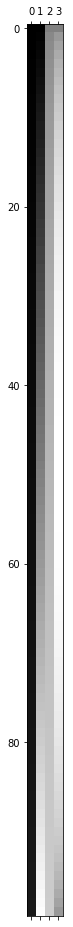

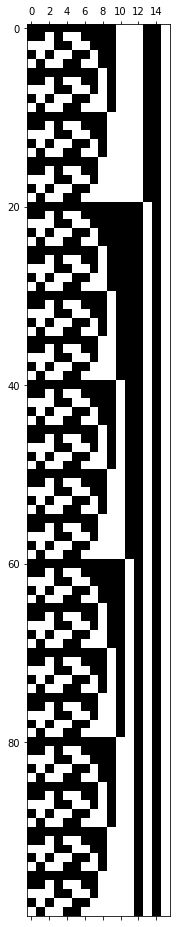

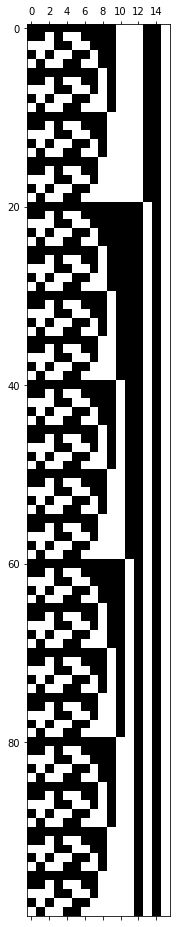

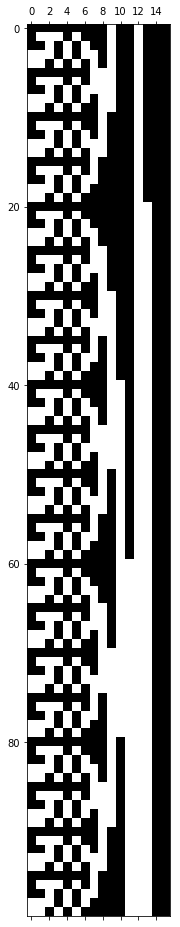

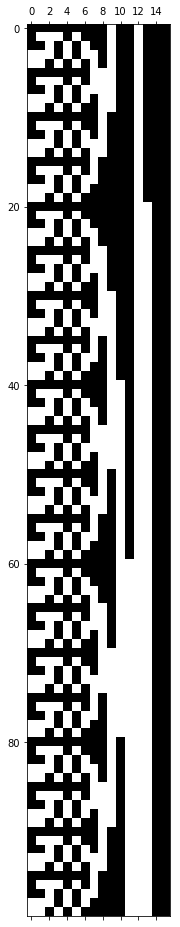

In [0]:
plt.matshow(xx    [20000:20100,0:4], fignum=1, cmap='gray')
#plt.matshow(xx    [20000:20100,68*0+4:68*1], fignum=1, cmap='gray')
#plt.matshow(xx    [20000:20100,68*1+4:68*2], fignum=2, cmap='gray')
#plt.matshow(xx    [20000:20100,68*2+4:68*3], fignum=3, cmap='gray')
#plt.matshow(xx    [20000:20100,68*3+4:68*4], fignum=4, cmap='gray')
#plt.matshow(xx    [20000:20100,68*4+4:68*5], fignum=5, cmap='gray')
#plt.matshow(xx    [20000:20100,68*5+4:68*6], fignum=6, cmap='gray')
#plt.matshow(xx    [20000:20100,68*6+4:68*7], fignum=7, cmap='gray')
#plt.matshow(xx    [20000:20100,68*7+4:68*8], fignum=8, cmap='gray')
#plt.matshow(xx    [20000:20100,68*8+4:68*9], fignum=9, cmap='gray')
# plt.matshow(xx    [20000:20100,72:72+64], fignum=7, cmap='gray')
# plt.matshow(xx    [20000:20100,4:68], fignum=7, cmap='gray')
# plt.matshow(xx    [20000:20100,72:72+64], fignum=7, cmap='gray')
plt.matshow(ybit  [20000:20100,:]*100, fignum=3, cmap='gray')
plt.matshow(yvbit [20000:20100,:]*100, fignum=4, cmap='gray')
plt.matshow(ycbit [20000:20100,:]*100, fignum=5, cmap='gray')
plt.matshow(yvcbit[20000:20100,:]*100, fignum=6, cmap='gray')


In [0]:
#mkdir './alu_demo'
#!pwd
#!cd './alu_demo'
#!pwd
#import os
#os.chdir('./alu_demo')
#!pwd


##Make the models for testing

## custom layer and loss

In [0]:
# expands the float valuse to 16 bits around zero = int8.8
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)


def bitexpand(x) :

    r16 = K.round((x *1/256)-.49999)*256
    r15 = K.round((x *1/128)-.49999)*128
    r14 = K.round((x *1/64 )-.49999)*64 
    r13 = K.round((x *1/32 )-.49999)*32 
    r12 = K.round((x *1/16 )-.49999)*16 
    r11 = K.round((x *1/8  )-.49999)*8  
    r10 = K.round((x *1/4  )-.49999)*4  
    r9  = K.round((x *1/2  )-.49999)*2  
    r8  = K.round((x *1    )-.49999)*1    
    r7  = K.round((x *2    )-.49999)/2    
    r6  = K.round((x *4    )-.49999)/4    
    r5  = K.round((x *8    )-.49999)/8    
    r4  = K.round((x *16   )-.49999)/16   
    r3  = K.round((x *32   )-.49999)/32   
    r2  = K.round((x *64   )-.49999)/64   
    r1  = K.round((x *128  )-.49999)/128 
    r0  = K.round((x *256  )-.49999)/256 
 
    b15 =150*0 + (r15-r16 )/256*2 
    b14 =140*0 + (r14-r15 )/128*2
    b13 =130*0 + (r13-r14 )/ 64*2
    b12 =120*0 + (r12-r13 )/ 32*2
    b11 =110*0 + (r11-r12 )/ 16*2
    b10 =100*0 + (r10-r11 )/  8*2
    b9  = 90*0 + (r9 -r10 )/  4*2
    b8  = 80*0 + (r8 -r9  )/  2*2
    b7  = 70*0 + (r7 -r8  )/  1*2
    b6  = 60*0 + (r6 -r7  )*  2*2
    b5  = 50*0 + (r5 -r6  )*  4*2
    b4  = 40*0 + (r4 -r5  )*  8*2
    b3  = 30*0 + (r3 -r4  )* 16*2
    b2  = 20*0 + (r2 -r3  )* 32*2
    b1  = 10*0 + (r1 -r2  )* 64*2
    b0  =  0*0 + (r0 -r1  )*128*2
    
    #return K.concatenate([b15,b14,b13,b12,b11,b10,b9,b8,b7,b6,b5,b4,b3,b2,b1,b0], axis=1)
    return K.concatenate([b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15], axis=1)
    #return r15 

def bitexpand_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2  # only valid for 2D tensors
    shape[-1] *= 16 
    return tuple(shape)
  


alux_model=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))
ninp=nvars+nops+nbits+ncat
#200+32+32+4

xi   = keras.layers.Input(shape=(100,))
x1   = keras.layers.Dense(  1, activation='relu'  )(xi)
xout = keras.layers.Lambda(bitexpand,output_shape=bitexpand_output_shape)(x1)
alux_model = keras.models.Model(inputs=xi, outputs=xout )
alux_model.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mean_absolute_error'])
alux_model.summary()

keras.utils.plot_model(alux_model, to_file='alux_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')


W0725 01:33:10.614850 139653573437312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 01:33:10.616332 139653573437312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 01:33:10.622826 139653573437312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 01:33:10.773036 139653573437312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
lambda_1 (Lambda)            (None, 16)                0         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Define custom loss
def custom_loss():

  # Create a loss function that computes the integer error and and the bitwise error 
  def loss(y_true,y_pred):
    
    y_pint=K.round( y_pred[:,1:17] )

    y_int = \
      (y_pint[:, 0]*1/256) \
    + (y_pint[:, 1]*1/128) \
    + (y_pint[:, 2]*1/64 ) \
    + (y_pint[:, 3]*1/32 ) \
    + (y_pint[:, 4]*1/16 ) \
    + (y_pint[:, 5]*1/8  ) \
    + (y_pint[:, 6]*1/4  ) \
    + (y_pint[:, 7]*1/2  ) \
    + (y_pint[:, 8]*1    ) \
    + (y_pint[:, 9]*2    ) \
    + (y_pint[:,10]*4    ) \
    + (y_pint[:,11]*8    ) \
    + (y_pint[:,12]*16   ) \
    + (y_pint[:,13]*32   ) \
    + (y_pint[:,14]*64   ) \
    + (y_pint[:,15]*-128 )  
    
    loss0 = K.mean(K.abs   ( y_int  [:  ]/100 - y_true[:,0]/100)) # abs binary cast as int loss
    loss1 = K.mean(K.square( y_int  [:  ]/100 - y_true[:,0]/100))
    loss2 = K.mean(K.abs   ( y_pred [:,0]/100 - y_true[:,0]/100)) # abs float out
    
    loss3 = K.mean(K.binary_crossentropy(y_true[:,1:17], y_pred[:,1:17]), axis=-1) #bin xentropy

    loss  = loss0*1.0   +loss1*0.0   +loss2*1.0 + loss3*0.1 

    return (loss)
  return loss


#models

In [0]:
#reset history, create results buffer for up to 1000 eons
eons=0;
maxeons=100;
#yhist=np.zeros((maxeons,nsamp))
#ymodel[0:maxeons]=""
#print(yhist.shape)
ymodel = np.array(range(0,maxeons),dtype=object )
print(ymodel.shape, ymodel.dtype)
ymodel[:]='...'
print(ymodel[0])

(100,) object
...


In [0]:
# bit 4layer x 200  model
bit23_desc= 'rrrrrr400(sl)'
bit23_wgts= '0.1,10.,10.'

ninp=nvars+nops+nbits*2
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)

bit23_model=Sequential()
xi   = keras.layers.Input(shape=(ninp,),name='nxi')

x0   = keras.layers.Dense( 400, activation='relu'   ,name='nx0')(xi)
x0d  = keras.layers.GaussianDropout(.1                         )(x0)

x1   = keras.layers.Dense( 400, activation='relu'   ,name='nx1')(x0d)
x1d  = keras.layers.GaussianDropout(.1                         )(x1)

x2   = keras.layers.Dense( 400, activation='relu'   ,name='nx2')(x1d)
x2d  = keras.layers.GaussianDropout(.1                         )(x2)

x3   = keras.layers.Dense( 400, activation='relu'   ,name='nx3')(x2d)
x3d  = keras.layers.GaussianDropout(.05                        )(x3)

x4   = keras.layers.Dense( 400, activation='relu'   ,name='nx4')(x3d)
x4d  = keras.layers.GaussianDropout(.05                        )(x4)

x5   = keras.layers.Dense( 400, activation='relu'   ,name='nx5')(x4d)
xa   = keras.layers.Dense(   1, activation='linear' ,name='nxo')(x5)
xe   = keras.layers.Lambda(bitexpand,output_shape=bitexpand_output_shape,name='nxe')(xa)
xb   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxb')(x4d)
xout = keras.layers.Concatenate()([xa, xe, xb ])


bit23_model = keras.models.Model(inputs=xi, outputs=[xa,xe,xb ])
bit23_model.compile( loss=        [ 'mae',  'binary_crossentropy','binary_crossentropy'],
                    loss_weights=[ 0.1 ,                   1.0,                   100.0],
                    optimizer=opt,
                    metrics=['mae'])


bit23_model.summary()

keras.utils.plot_model(bit23_model, to_file='bit23_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')


W0725 01:33:16.722802 139653573437312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0725 01:33:16.732212 139653573437312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0725 01:33:17.007150 139653573437312 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nxi (InputLayer)                (None, 68)           0                                            
__________________________________________________________________________________________________
nx0 (Dense)                     (None, 400)          27600       nxi[0][0]                        
__________________________________________________________________________________________________
gaussian_dropout_1 (GaussianDro (None, 400)          0           nx0[0][0]                        
__________________________________________________________________________________________________
nx1 (Dense)                     (None, 400)          160400      gaussian_dropout_1[0][0]         
__________________________________________________________________________________________________
gaussian_d

In [0]:
# bit26 4layer x 200  model
bit26_desc= 'rrr400(sl) d=0'
bit26_wgts= '0.1,10.,10.'

ninp=nvars+nops+nbits*2
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)






bit26_model=Sequential()

xi    = keras.layers.Input(shape=(ninp,),name='nxi')

#xi9   = keras.layers.Lambda(lambda xi: K.repeat_elements(xi, 9, axis=1), output_shape=(ninp*9,)) (xi)

xi9   =keras.layers.RepeatVector(9)(xi)

#cnn   = keras.layers.Dense( 800, activation='relu'   ,name='nx')(xi)

cnni  = keras.layers.Reshape((3,3, 68),               )(xi9)
cnn0d  =keras.layers.noise.GaussianDropout(        .01 )(cnni)
#keras.backend.print_tensor(cnni[:,:,0], message='cnni')

cnn1   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn0d)
cnn1d  =keras.layers.noise.GaussianDropout(                             .03)(cnn1)
cnn2   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn1d)
cnn2d  =keras.layers.noise.GaussianDropout(                             .03)(cnn2)
cnn3   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn2d)
cnn3d  =keras.layers.noise.GaussianDropout(                             .03)(cnn3)

cnn4   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn3d)
cnn4d  =keras.layers.noise.GaussianDropout(                             .03)(cnn4)

cnn5   =keras.layers.Conv2D( 1134, (3, 3), padding='same', activation='relu')(cnn4d)
cnn5d  =keras.layers.noise.GaussianDropout(                             .03)(cnn5)

cnn6   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn5d)
cnn6d  =keras.layers.noise.GaussianDropout(                             .03)(cnn6)

#cnn3p  =keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='valid', data_format=None)(cnn3d)
cnno   =keras.layers.Flatten()(cnn3d)



x5   = keras.layers.Dense( 300, activation='relu'   ,name='nx5')(cnno)
x6   = keras.layers.Dense( 100, activation='relu'   ,name='nx6')(x5)
xa   = keras.layers.Dense(   1, activation='linear' ,name='nxo')(x5)
xe   = keras.layers.Lambda(bitexpand,output_shape=bitexpand_output_shape,name='nxe')(xa)
xb   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxb')(x5)
xout = keras.layers.Concatenate()([xa, xe, xb ])


bit26_model = keras.models.Model(inputs=xi, outputs=[xa,xe,xb ])
bit26_model.compile( loss=        [ 'mae',  'binary_crossentropy','binary_crossentropy'],
                     loss_weights=[ 0.10 ,                    1.0,               100.0 ],
                     optimizer=opt,
                     metrics=['mae'])




bit26_model.summary()

keras.utils.plot_model(bit26_model, to_file='bit26_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nxi (InputLayer)                (None, 68)           0                                            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 9, 68)        0           nxi[0][0]                        
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 3, 3, 68)     0           repeat_vector_1[0][0]            
__________________________________________________________________________________________________
gaussian_dropout_6 (GaussianDro (None, 3, 3, 68)     0           reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (

In [0]:
# bit26 4layer x 200  model
fcbit26_desc= 'rrr400(sl) d=0'
fcbit26_wgts= '0.1,10.,10.'

ninp=(nvars+nops+nbits*2)*9
print(ninp)
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)






fcbit26_model=Sequential()

xi    = keras.layers.Input(shape=(ninp,),name='nxi')

#xi9   = keras.layers.Lambda(lambda xi: K.repeat_elements(xi, 9, axis=1), output_shape=(ninp*9,)) (xi)

#xi9   =keras.layers.RepeatVector(9)(xi)

#cnn   = keras.layers.Dense( 800, activation='relu'   ,name='nx')(xi)

cnni  = keras.layers.Reshape((3,3, 68),               )(xi)
#cnn0d  =keras.layers.noise.GaussianDropout(        .01 )(cnni)
#keras.backend.print_tensor(cnni[:,:,0], message='cnni')

cnn1   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnni)
cnn1d  =keras.layers.noise.GaussianDropout(                             .01)(cnn1)
cnn2   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn1d)
cnn2d  =keras.layers.noise.GaussianDropout(                             .01)(cnn2)
cnn3   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn2d)
cnn3d  =keras.layers.noise.GaussianDropout(                             .01)(cnn3)

cnn4   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn3d)
cnn4d  =keras.layers.noise.GaussianDropout(                             .01)(cnn4)

cnn5   =keras.layers.Conv2D( 1134, (3, 3), padding='same', activation='relu')(cnn4d)
cnn5d  =keras.layers.noise.GaussianDropout(                             .01)(cnn5)

cnn6   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn5d)
cnn6d  =keras.layers.noise.GaussianDropout(                             .01)(cnn6)

#cnn3p  =keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='valid', data_format=None)(cnn3d)
cnno   =keras.layers.Flatten()(cnn3d)



x5   = keras.layers.Dense( 300, activation='relu'   ,name='nx5')(cnno)
x6   = keras.layers.Dense( 100, activation='relu'   ,name='nx6')(x5)
xa   = keras.layers.Dense(   1, activation='linear' ,name='nxo')(x5)
xe   = keras.layers.Lambda(bitexpand,output_shape=bitexpand_output_shape,name='nxe')(xa)
xb   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxb')(x5)
xc   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxc')(x5)


fcbit26_model = keras.models.Model(inputs=xi, outputs=[xa,xe,xb,xc ])
fcbit26_model.compile( loss=        [ 'mae',  'binary_crossentropy','binary_crossentropy','binary_crossentropy'],
                     loss_weights=[ 0.10 ,                    1.0,               100.0,                   100 ],
                     optimizer=opt,
                     metrics=['mae'])




fcbit26_model.summary()

keras.utils.plot_model(fcbit26_model, to_file='fcbit26_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')


612
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nxi (InputLayer)                (None, 612)          0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 3, 3, 68)     0           nxi[0][0]                        
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 3, 3, 134)    82142       reshape_2[0][0]                  
__________________________________________________________________________________________________
gaussian_dropout_13 (GaussianDr (None, 3, 3, 134)    0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d

In [0]:
# bit 4layer x 200  model
cbit23_desc= 'rrrrrr400(sl)'
cbit23_wgts= '0.1,10.,10.'

ninp=nvars+nops+nbits*4
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)

cbit23_model=Sequential()
xi   = keras.layers.Input(shape=(ninp,),name='nxi')

x0   = keras.layers.Dense( 400, activation='relu'   ,name='nx0')(xi)
x0d  = keras.layers.GaussianDropout(.0                         )(x0)

x1   = keras.layers.Dense( 400, activation='relu'   ,name='nx1')(x0d)
x1d  = keras.layers.GaussianDropout(.0                         )(x1)

x2   = keras.layers.Dense( 400, activation='relu'   ,name='nx2')(x1d)
x2d  = keras.layers.GaussianDropout(.0                         )(x2)

x3   = keras.layers.Dense( 400, activation='relu'   ,name='nx3')(x2d)
x3d  = keras.layers.GaussianDropout(.0                         )(x3)

x4   = keras.layers.Dense( 400, activation='relu'   ,name='nx4')(x3d)
x4d  = keras.layers.GaussianDropout(.0                         )(x4)

x5   = keras.layers.Dense( 400, activation='relu'   ,name='nx5')(x4d)
xa   = keras.layers.Dense(   1, activation='linear' ,name='nxo')(x5)
xe   = keras.layers.Lambda(bitexpand,output_shape=bitexpand_output_shape,name='nxe')(xa)
xb   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxb')(x4d)
xc   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxc')(x5)




cbit23_model = keras.models.Model(inputs=xi, outputs=[xa,xe,xb,xc ])
cbit23_model.compile( loss=        [ 'mae',  'binary_crossentropy','binary_crossentropy','binary_crossentropy'],
                     loss_weights=[ 0.10 ,                    1.0,               100.0,                   100 ],
                     optimizer=opt,
                     metrics=['mae'])




cbit23_model.summary()

keras.utils.plot_model(cbit23_model, to_file='cbit23_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nxi (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
nx0 (Dense)                     (None, 400)          40400       nxi[0][0]                        
__________________________________________________________________________________________________
gaussian_dropout_19 (GaussianDr (None, 400)          0           nx0[0][0]                        
__________________________________________________________________________________________________
nx1 (Dense)                     (None, 400)          160400      gaussian_dropout_19[0][0]        
__________________________________________________________________________________________________
gaussian_d

In [0]:
# bit 4layer x 200  model
cbit23a_desc= 'rrrrrr400(sl)'
cbit23a_wgts= '0.1,10.,10.'

ninp=nvars+nops+nbits*4
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)

cbit23a_model=Sequential()
xi   = keras.layers.Input(shape=(ninp,),name='nxi')

x0   = keras.layers.Dense( 400, activation='relu'   ,name='nx0' )(xi)
x0d  = keras.layers.GaussianDropout(.0              ,name='nx0d')(x0)

x1   = keras.layers.Dense( 400, activation='relu'   ,name='nx1' )(x0d)
x1d  = keras.layers.GaussianDropout(.0              ,name='nx1d')(x1)

x2   = keras.layers.Dense( 400, activation='relu'   ,name='nx2' )(x1d)
x2d  = keras.layers.GaussianDropout(.0              ,name='nx2d')(x2)

x3   = keras.layers.Dense( 400, activation='relu'   ,name='nx3' )(x2d)
x3d  = keras.layers.GaussianDropout(.0              ,name='nx3d')(x3)

x4   = keras.layers.Dense( 400, activation='relu'   ,name='nx4' )(x3d)
x4d  = keras.layers.GaussianDropout(.0              ,name='nx4d')(x4)

x5   = keras.layers.Dense( 400, activation='relu'   ,name='nx5' )(x4d)

xa   = keras.layers.Dense(   1, activation='linear' ,name='nxo' )(x5)
xe   = keras.layers.Lambda(bitexpand,output_shape=bitexpand_output_shape,name='nxe')(xa)

xb   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxb')(x2d)
xc   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxc')(x5)

cbit23a_model = keras.models.Model(inputs=xi, outputs=[xa,xe,xb,xc ])
cbit23a_model.compile( loss=        [ 'mae',  'binary_crossentropy','binary_crossentropy','binary_crossentropy'],
                     loss_weights=[ 0.10 ,                    1.0,               100.0,                   100 ],
                     optimizer=opt,
                     metrics=['mae'])




cbit23a_model.summary()

keras.utils.plot_model(cbit23a_model, to_file='cbit23a_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nxi (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
nx0 (Dense)                     (None, 400)          40400       nxi[0][0]                        
__________________________________________________________________________________________________
nx0d (GaussianDropout)          (None, 400)          0           nx0[0][0]                        
__________________________________________________________________________________________________
nx1 (Dense)                     (None, 400)          160400      nx0d[0][0]                       
__________________________________________________________________________________________________
nx1d (Gaus

In [0]:
# bit 4layer x 200  model
cbit23b0_desc= 'rrrrrr400(sl)'
cbit23b0_wgts= '0.1,10.,10.'

ninp=nvars+nops+nbits*4
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)

cbit23b0_model=Sequential()
xi   = keras.layers.Input(shape=(ninp,),name='nxi')

x0   = keras.layers.Dense( 100, activation='relu'   ,name='nx0' )(xi)
x0d  = keras.layers.GaussianDropout(.0              ,name='nx0d')(x0)

x1   = keras.layers.Dense( 100, activation='relu'   ,name='nx1' )(x0d)
x1d  = keras.layers.GaussianDropout(.0              ,name='nx1d')(x1)

x2   = keras.layers.Dense( 100, activation='relu'   ,name='nx2' )(x1d)
x2d  = keras.layers.GaussianDropout(.0              ,name='nx2d')(x2)

xa   = keras.layers.Dense(   1, activation='linear' ,name='nxo' )(x2)
xe   = keras.layers.Lambda(bitexpand,output_shape=bitexpand_output_shape,name='nxe')(xa)

xb   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxb')(x1)
xc   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxc')(x2)

cbit23b0_model = keras.models.Model(inputs=xi, outputs=[xa,xe,xb,xc ])
cbit23b0_model.compile( loss=        [ 'mae',  'binary_crossentropy','binary_crossentropy','binary_crossentropy'],
                     loss_weights=[ 0.10 ,                    1.0,               100.0,                   100 ],
                     optimizer=opt,
                     metrics=['mae'])




cbit23b0_model.summary()

keras.utils.plot_model(cbit23b0_model, to_file='cbit23b0_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nxi (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
nx0 (Dense)                     (None, 100)          10100       nxi[0][0]                        
__________________________________________________________________________________________________
nx0d (GaussianDropout)          (None, 100)          0           nx0[0][0]                        
__________________________________________________________________________________________________
nx1 (Dense)                     (None, 100)          10100       nx0d[0][0]                       
__________________________________________________________________________________________________
nx1d (Gaus

In [0]:
# bit 4layer x 200  model
cbit23b1_desc= 'rrrrrr400(sl)'
cbit23b1_wgts= '0.1,10.,10.'

ninp=nvars+nops+nbits*4
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)

cbit23b1_model=Sequential()
xi   = keras.layers.Input(shape=(ninp,),name='nxi')

x0   = keras.layers.Dense( 200, activation='relu'   ,name='nx0' )(xi)
x0d  = keras.layers.GaussianDropout(.0              ,name='nx0d')(x0)

x1   = keras.layers.Dense( 200, activation='relu'   ,name='nx1' )(x0d)
x1d  = keras.layers.GaussianDropout(.0              ,name='nx1d')(x1)

x2   = keras.layers.Dense( 200, activation='relu'   ,name='nx2' )(x1d)
x2d  = keras.layers.GaussianDropout(.0              ,name='nx2d')(x2)

xa   = keras.layers.Dense(   1, activation='linear' ,name='nxo' )(x2)
xe   = keras.layers.Lambda(bitexpand,output_shape=bitexpand_output_shape,name='nxe')(xa)

xb   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxb')(x1)
xc   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxc')(x2)

cbit23b1_model = keras.models.Model(inputs=xi, outputs=[xa,xe,xb,xc ])
cbit23b1_model.compile( loss=        [ 'mae',  'binary_crossentropy','binary_crossentropy','binary_crossentropy'],
                     loss_weights=[ 0.10 ,                    1.0,               100.0,                   100 ],
                     optimizer=opt,
                     metrics=['mae'])




cbit23b1_model.summary()

keras.utils.plot_model(cbit23b1_model, to_file='cbit23b1_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nxi (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
nx0 (Dense)                     (None, 200)          20200       nxi[0][0]                        
__________________________________________________________________________________________________
nx0d (GaussianDropout)          (None, 200)          0           nx0[0][0]                        
__________________________________________________________________________________________________
nx1 (Dense)                     (None, 200)          40200       nx0d[0][0]                       
__________________________________________________________________________________________________
nx1d (Gaus

In [0]:
# bit 4layer x 200  model
cbit23b2_desc= 'rrrrrr400(sl)'
cbit23b2_wgts= '0.1,10.,10.'

ninp=nvars+nops+nbits*4
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)

cbit23b2_model=Sequential()
xi   = keras.layers.Input(shape=(ninp,),name='nxi')

x0   = keras.layers.Dense( 400, activation='relu'   ,name='nx0' )(xi)
x0d  = keras.layers.GaussianDropout(.0              ,name='nx0d')(x0)

x1   = keras.layers.Dense( 400, activation='relu'   ,name='nx1' )(x0d)
x1d  = keras.layers.GaussianDropout(.0              ,name='nx1d')(x1)

x2   = keras.layers.Dense( 400, activation='relu'   ,name='nx2' )(x1d)
x2d  = keras.layers.GaussianDropout(.0              ,name='nx2d')(x2)

x3   = keras.layers.Dense( 400, activation='relu'   ,name='nx3' )(x2d)
x3d  = keras.layers.GaussianDropout(.0              ,name='nx3d')(x3)

x4   = keras.layers.Dense( 400, activation='relu'   ,name='nx4' )(x3d)
x4d  = keras.layers.GaussianDropout(.0              ,name='nx4d')(x4)

x5   = keras.layers.Dense( 400, activation='relu'   ,name='nx5' )(x4d)

xa   = keras.layers.Dense(   1, activation='linear' ,name='nxo' )(x5)
xe   = keras.layers.Lambda(bitexpand,output_shape=bitexpand_output_shape,name='nxe')(xa)

xb   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxb')(x3d)
xc   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxc')(x5)

cbit23b2_model = keras.models.Model(inputs=xi, outputs=[xa,xe,xb,xc ])
cbit23b2_model.compile( loss=        [ 'mae',  'binary_crossentropy','binary_crossentropy','binary_crossentropy'],
                     loss_weights=[ 0.10 ,                    1.0,               100.0,                   100 ],
                     optimizer=opt,
                     metrics=['mae'])




cbit23b2_model.summary()

keras.utils.plot_model(cbit23b2_model, to_file='cbit23b2_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nxi (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
nx0 (Dense)                     (None, 400)          40400       nxi[0][0]                        
__________________________________________________________________________________________________
nx0d (GaussianDropout)          (None, 400)          0           nx0[0][0]                        
__________________________________________________________________________________________________
nx1 (Dense)                     (None, 400)          160400      nx0d[0][0]                       
__________________________________________________________________________________________________
nx1d (Gaus

In [0]:
# bit 4layer x 200  model
cbit24_desc= 'rrrrrr400(sl)'
cbit24_wgts= '0.1,10.,10.'

ninp=nvars+nops+nbits*4
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)

cbit24_model=Sequential()
xi   = keras.layers.Input(shape=(ninp,),name='nxi')

x0   = keras.layers.Dense( 400, activation='relu'   ,name='nx0')(xi)
x0d  = keras.layers.GaussianDropout(.0                         )(x0)

x1   = keras.layers.Dense( 400, activation='relu'   ,name='nx1')(x0d)
x1d  = keras.layers.GaussianDropout(.0                         )(x1)

x2   = keras.layers.Dense( 400, activation='relu'   ,name='nx2')(x1d)
x2d  = keras.layers.GaussianDropout(.0                         )(x2)

x3   = keras.layers.Dense( 400, activation='relu'   ,name='nx3')(x2d)
x3d  = keras.layers.GaussianDropout(.0                         )(x3)

x4   = keras.layers.Dense( 400, activation='relu'   ,name='nx4')(x3d)
x4d  = keras.layers.GaussianDropout(.0                         )(x4)

x5   = keras.layers.Dense( 400, activation='relu'   ,name='nx5')(x4d)
xa   = keras.layers.Dense(   1, activation='linear' ,name='nxo')(x5)
xe   = keras.layers.Lambda(bitexpand,output_shape=bitexpand_output_shape,name='nxe')(xa)
xb   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxb')(x2d)
xc0  = keras.layers.Dense(  50, activation='relu' ,name='nxc0')(x5)
xc   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxc')(xc0)

cbit24_model = keras.models.Model(inputs=xi, outputs=[xa,xe,xb,xc ])
cbit24_model.compile( loss=        [ 'mae',  'binary_crossentropy','binary_crossentropy','binary_crossentropy'],
                     loss_weights=[ 0.10 ,                    1.0,               100.0,                   100 ],
                     optimizer=opt,
                     metrics=['mae'])




cbit24_model.summary()

keras.utils.plot_model(cbit24_model, to_file='cbit24_model.png', show_shapes=True, show_layer_names=True, rankdir='TB')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nxi (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
nx0 (Dense)                     (None, 400)          40400       nxi[0][0]                        
__________________________________________________________________________________________________
gaussian_dropout_24 (GaussianDr (None, 400)          0           nx0[0][0]                        
__________________________________________________________________________________________________
nx1 (Dense)                     (None, 400)          160400      gaussian_dropout_24[0][0]        
__________________________________________________________________________________________________
gaussian_d

In [0]:
# bit 4layer x 200  model
cbit25_desc= 'rrrrrr400(sl)'
cbit25_wgts= '0.1,10.,10.'

ninp=nvars+nops+nbits*4
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)

cbit25_model=Sequential()
xi   = keras.layers.Input(shape=(ninp,),name='nxi')

x0   = keras.layers.Dense( 400, activation='relu'   ,name='nx0' )(xi)
x0d  = keras.layers.GaussianDropout(.0              ,name='nx0d')(x0)

x1   = keras.layers.Dense( 400, activation='relu'   ,name='nx1' )(x0d)
x1d  = keras.layers.GaussianDropout(.0              ,name='nx1d')(x1)

x2   = keras.layers.Dense( 400, activation='relu'   ,name='nx2' )(x1d)
x2d  = keras.layers.GaussianDropout(.0              ,name='nx2d')(x2)

x3   = keras.layers.Dense( 400, activation='relu'   ,name='nx3' )(x2d)
x3d  = keras.layers.GaussianDropout(.0              ,name='nx3d')(x3)

x4   = keras.layers.Dense( 400, activation='relu'   ,name='nx4' )(x3d)
x4d  = keras.layers.GaussianDropout(.0              ,name='nx4d')(x4)

x5   = keras.layers.Dense( 400, activation='relu'   ,name='nx5')(x4d)

xa   = keras.layers.Dense(   1, activation='linear' ,name='nxo')(x5)
xe   = keras.layers.Lambda(bitexpand,output_shape=bitexpand_output_shape,name='nxe')(xa)
xb   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxb' )(x5)
x0c  = keras.layers.Dense(  50, activation='sigmoid' ,name='nx0c')(x5 )
x1c  = keras.layers.Dense(  50, activation='sigmoid' ,name='nx1c')(x0c)
xc   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxc' )(x1c)

cbit25_model = keras.models.Model(inputs=xi, outputs=[xa,xe,xb,xc ])
cbit25_model.compile( loss=        [ 'mae',  'binary_crossentropy','binary_crossentropy','binary_crossentropy'],
                     loss_weights=[ 0.10 ,                    1.0,               100.0,                   100 ],
                     optimizer=opt,
                     metrics=['mae'])




cbit25_model.summary()

keras.utils.plot_model(cbit25_model, to_file='cbit25_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nxi (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
nx0 (Dense)                     (None, 400)          40400       nxi[0][0]                        
__________________________________________________________________________________________________
nx0d (GaussianDropout)          (None, 400)          0           nx0[0][0]                        
__________________________________________________________________________________________________
nx1 (Dense)                     (None, 400)          160400      nx0d[0][0]                       
__________________________________________________________________________________________________
nx1d (Gaus

In [0]:
# bit 4layer x 200  model
cbit23p_desc= 'rrrrrr400(sl)'
cbit23p_wgts= '0.1,10.,10.'

ninp=nvars+nops+nbits*4
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)

cbit23p_model=Sequential()
xi   = keras.layers.Input(shape=(ninp,),name='nxi')

x0   = keras.layers.Dense( 400, activation='relu'   ,name='nx0' )(xi)
x0d  = keras.layers.GaussianDropout(.0              ,name='nx0d')(x0)

x1   = keras.layers.Dense( 400, activation='relu'   ,name='nx1' )(x0d)
x1d  = keras.layers.GaussianDropout(.0              ,name='nx1d')(x1)

x2   = keras.layers.Dense( 400, activation='relu'   ,name='nx2' )(x1d)
x2d  = keras.layers.GaussianDropout(.0              ,name='nx2d')(x2)

x3   = keras.layers.Dense( 400, activation='relu'   ,name='nx3' )(x2d)
x3d  = keras.layers.GaussianDropout(.0              ,name='nx3d')(x3)

x4   = keras.layers.Dense( 400, activation='relu'   ,name='nx4' )(x3d)
x4d  = keras.layers.GaussianDropout(.0              ,name='nx4d')(x4)

x5   = keras.layers.Dense( 400, activation='relu'   ,name='nx5' )(x4d)

xa   = keras.layers.Dense(   1, activation='linear' ,name='nxo' )(x5)
xe   = keras.layers.Lambda(bitexpand,output_shape=bitexpand_output_shape,name='nxe')(xa)

xb   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxb')(x3d)
xc   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxc')(x5)

cbit23p_model = keras.models.Model(inputs=xi, outputs=[xa,xe,xb,xc, x3 ])
cbit23p_model.compile( loss=        [ 'mae',  'binary_crossentropy','binary_crossentropy','binary_crossentropy','binary_crossentropy'],
                     loss_weights=[ 0.10 ,                    1.0,               100.0,                   100 , 0],
                     optimizer=opt,
                     metrics=['mae'])




cbit23p_model.summary()

keras.utils.plot_model(cbit23p_model, to_file='cbit23p_model.png', show_shapes=True, show_layer_names=True, rankdir='TB')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nxi (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
nx0 (Dense)                     (None, 400)          40400       nxi[0][0]                        
__________________________________________________________________________________________________
nx0d (GaussianDropout)          (None, 400)          0           nx0[0][0]                        
__________________________________________________________________________________________________
nx1 (Dense)                     (None, 400)          160400      nx0d[0][0]                       
__________________________________________________________________________________________________
nx1d (Gaus

## Train 

In [0]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

xx,yy (320000, 36) (320000, 1)
xbit0,ybit (320000, 16) (320000, 16)
eons= 0


eon= 1  model= cbit23p  inp= bit iout= ycgpbit noise= 0
Train on 320000 samples, validate on 320000 samples
Epoch 1/64
320000/320000 [==============================] - 12s 36us/step - loss: 43.0466 - nxo_loss: 3.9930 - nxe_loss: 6.5080 - nxb_loss: 0.1922 - nxc_loss: 0.1692 - nx3_loss: 1.3982 - nxo_mean_absolute_error: 3.9930 - nxe_mean_absolute_error: 0.4071 - nxb_mean_absolute_error: 0.1349 - nxc_mean_absolute_error: 0.1182 - nx3_mean_absolute_error: 0.5923 - val_loss: 44.7560 - val_nxo_loss: 4.3690 - val_nxe_loss: 7.2949 - val_nxb_loss: 0.1966 - val_nxc_loss: 0.1736 - val_nx3_loss: 1.3809 - val_nxo_mean_absolute_error: 4.3690 - val_nxe_mean_absolute_error: 0.4564 - val_nxb_mean_absolute_error: 0.1363 - val_nxc_mean_absolute_error: 0.1199 - val_nx3_mean_absolute_error: 0.5890
Epoch 2/64
320000/320000 [==============================] - 12s 36us/step - loss: 42.6900 - nxo_loss: 3.9168 - nxe_loss: 6.4963 - nxb_

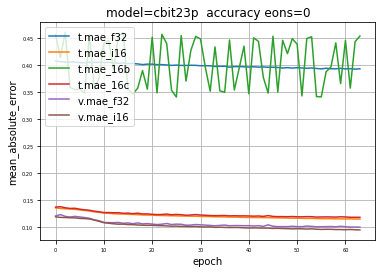



eon= 2  model= cbit23p  inp= bit iout= ycgpbit noise= 0
Train on 320000 samples, validate on 320000 samples
Epoch 1/64
320000/320000 [==============================] - 11s 35us/step - loss: 36.2608 - nxo_loss: 2.2714 - nxe_loss: 6.2659 - nxb_loss: 0.1628 - nxc_loss: 0.1349 - nx3_loss: 1.1309 - nxo_mean_absolute_error: 2.2714 - nxe_mean_absolute_error: 0.3921 - nxb_mean_absolute_error: 0.1140 - nxc_mean_absolute_error: 0.0937 - nx3_mean_absolute_error: 0.8590 - val_loss: 39.2149 - val_nxo_loss: 3.1562 - val_nxe_loss: 6.7258 - val_nxb_loss: 0.1721 - val_nxc_loss: 0.1496 - val_nx3_loss: 1.1228 - val_nxo_mean_absolute_error: 3.1562 - val_nxe_mean_absolute_error: 0.4219 - val_nxb_mean_absolute_error: 0.1172 - val_nxc_mean_absolute_error: 0.0991 - val_nx3_mean_absolute_error: 0.8628
Epoch 2/64
320000/320000 [==============================] - 11s 35us/step - loss: 36.1348 - nxo_loss: 2.2173 - nxe_loss: 6.2591 - nxb_loss: 0.1624 - nxc_loss: 0.1342 - nx3_loss: 1.1252 - nxo_mean_absolute_error

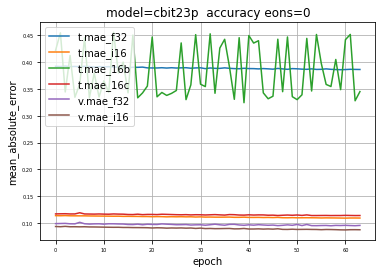



eon= 3  model= cbit23p  inp= bit iout= ycgpbit noise= 0
Train on 320000 samples, validate on 320000 samples
Epoch 1/64
320000/320000 [==============================] - 11s 35us/step - loss: 34.6688 - nxo_loss: 1.7083 - nxe_loss: 6.1742 - nxb_loss: 0.1566 - nxc_loss: 0.1267 - nx3_loss: 1.0472 - nxo_mean_absolute_error: 1.7083 - nxe_mean_absolute_error: 0.3865 - nxb_mean_absolute_error: 0.1094 - nxc_mean_absolute_error: 0.0876 - nx3_mean_absolute_error: 1.1211 - val_loss: 39.2591 - val_nxo_loss: 2.9353 - val_nxe_loss: 6.2498 - val_nxb_loss: 0.1729 - val_nxc_loss: 0.1543 - val_nx3_loss: 1.0430 - val_nxo_mean_absolute_error: 2.9353 - val_nxe_mean_absolute_error: 0.3923 - val_nxb_mean_absolute_error: 0.1141 - val_nxc_mean_absolute_error: 0.0951 - val_nx3_mean_absolute_error: 1.0965
Epoch 2/64
320000/320000 [==============================] - 11s 35us/step - loss: 34.4813 - nxo_loss: 1.6739 - nxe_loss: 6.1658 - nxb_loss: 0.1559 - nxc_loss: 0.1256 - nx3_loss: 1.0443 - nxo_mean_absolute_error

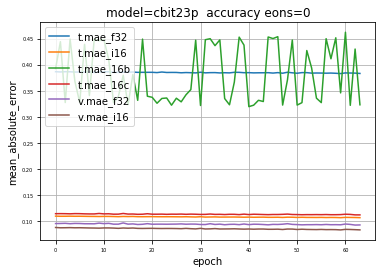



eon= 4  model= cbit23p  inp= bit iout= ycgpbit noise= 0
Train on 320000 samples, validate on 320000 samples
Epoch 1/64
320000/320000 [==============================] - 11s 35us/step - loss: 33.6827 - nxo_loss: 1.5261 - nxe_loss: 6.1156 - nxb_loss: 0.1529 - nxc_loss: 0.1213 - nx3_loss: 1.0127 - nxo_mean_absolute_error: 1.5261 - nxe_mean_absolute_error: 0.3831 - nxb_mean_absolute_error: 0.1066 - nxc_mean_absolute_error: 0.0834 - nx3_mean_absolute_error: 1.3752 - val_loss: 40.6035 - val_nxo_loss: 2.9628 - val_nxe_loss: 7.1350 - val_nxb_loss: 0.1757 - val_nxc_loss: 0.1560 - val_nx3_loss: 1.0127 - val_nxo_mean_absolute_error: 2.9628 - val_nxe_mean_absolute_error: 0.4465 - val_nxb_mean_absolute_error: 0.1124 - val_nxc_mean_absolute_error: 0.0933 - val_nx3_mean_absolute_error: 1.3743
Epoch 2/64
320000/320000 [==============================] - 11s 35us/step - loss: 33.6320 - nxo_loss: 1.4970 - nxe_loss: 6.1186 - nxb_loss: 0.1527 - nxc_loss: 0.1209 - nx3_loss: 1.0062 - nxo_mean_absolute_error

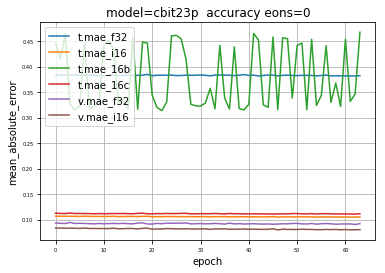



eon= 5  model= cbit23p  inp= bit iout= ycgpbit noise= 0
Train on 320000 samples, validate on 320000 samples
Epoch 1/64
320000/320000 [==============================] - 11s 36us/step - loss: 33.0358 - nxo_loss: 1.4399 - nxe_loss: 6.1151 - nxb_loss: 0.1507 - nxc_loss: 0.1171 - nx3_loss: 0.9854 - nxo_mean_absolute_error: 1.4399 - nxe_mean_absolute_error: 0.3829 - nxb_mean_absolute_error: 0.1050 - nxc_mean_absolute_error: 0.0803 - nx3_mean_absolute_error: 1.5728 - val_loss: 40.8178 - val_nxo_loss: 2.9127 - val_nxe_loss: 6.8154 - val_nxb_loss: 0.1756 - val_nxc_loss: 0.1615 - val_nx3_loss: 0.9862 - val_nxo_mean_absolute_error: 2.9127 - val_nxe_mean_absolute_error: 0.4301 - val_nxb_mean_absolute_error: 0.1109 - val_nxc_mean_absolute_error: 0.0912 - val_nx3_mean_absolute_error: 1.6095
Epoch 2/64
320000/320000 [==============================] - 12s 36us/step - loss: 32.7825 - nxo_loss: 1.3935 - nxe_loss: 6.0944 - nxb_loss: 0.1497 - nxc_loss: 0.1157 - nx3_loss: 0.9871 - nxo_mean_absolute_error

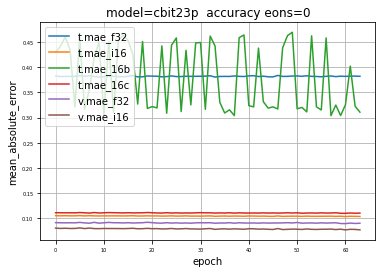



eon= 6  model= cbit23p  inp= bit iout= ycgpbit noise= 0
Train on 320000 samples, validate on 320000 samples
Epoch 1/64
320000/320000 [==============================] - 11s 35us/step - loss: 32.5444 - nxo_loss: 1.3894 - nxe_loss: 6.1003 - nxb_loss: 0.1491 - nxc_loss: 0.1139 - nx3_loss: 0.9704 - nxo_mean_absolute_error: 1.3894 - nxe_mean_absolute_error: 0.3821 - nxb_mean_absolute_error: 0.1038 - nxc_mean_absolute_error: 0.0777 - nx3_mean_absolute_error: 1.7287 - val_loss: 39.6105 - val_nxo_loss: 2.9210 - val_nxe_loss: 5.0253 - val_nxb_loss: 0.1782 - val_nxc_loss: 0.1647 - val_nx3_loss: 0.9644 - val_nxo_mean_absolute_error: 2.9210 - val_nxe_mean_absolute_error: 0.3151 - val_nxb_mean_absolute_error: 0.1104 - val_nxc_mean_absolute_error: 0.0906 - val_nx3_mean_absolute_error: 1.6868
Epoch 2/64
320000/320000 [==============================] - 11s 36us/step - loss: 32.6102 - nxo_loss: 1.4200 - nxe_loss: 6.1023 - nxb_loss: 0.1493 - nxc_loss: 0.1144 - nx3_loss: 0.9675 - nxo_mean_absolute_error

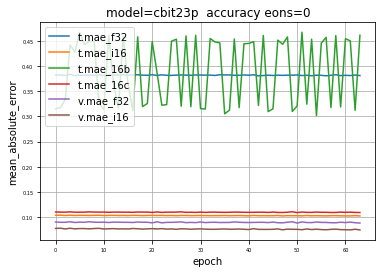



eon= 7  model= cbit23p  inp= bit iout= ycgpbit noise= 0
Train on 320000 samples, validate on 320000 samples
Epoch 1/64
320000/320000 [==============================] - 11s 36us/step - loss: 31.9727 - nxo_loss: 1.3350 - nxe_loss: 6.0894 - nxb_loss: 0.1471 - nxc_loss: 0.1104 - nx3_loss: 0.9505 - nxo_mean_absolute_error: 1.3350 - nxe_mean_absolute_error: 0.3815 - nxb_mean_absolute_error: 0.1027 - nxc_mean_absolute_error: 0.0752 - nx3_mean_absolute_error: 1.8870 - val_loss: 42.1186 - val_nxo_loss: 2.8383 - val_nxe_loss: 7.0779 - val_nxb_loss: 0.1790 - val_nxc_loss: 0.1685 - val_nx3_loss: 0.9516 - val_nxo_mean_absolute_error: 2.8383 - val_nxe_mean_absolute_error: 0.4429 - val_nxb_mean_absolute_error: 0.1095 - val_nxc_mean_absolute_error: 0.0894 - val_nx3_mean_absolute_error: 1.8906
Epoch 2/64
320000/320000 [==============================] - 11s 36us/step - loss: 32.2306 - nxo_loss: 1.3855 - nxe_loss: 6.1069 - nxb_loss: 0.1480 - nxc_loss: 0.1119 - nx3_loss: 0.9512 - nxo_mean_absolute_error

KeyboardInterrupt: ignored

In [160]:
#@title
#%%time

#train those suckers

from matplotlib import pylab
#from google.colab import widgets
import ipywidgets as widgets
#grid = widgets.Grid(4, 1)

#lrate = LearningRateScheduler(step_decay)


#reshape x and y for training
yo=np.zeros((nsamp,1))
yi=np.zeros((nsamp,1))
yo_int=np.zeros((nsamp))
yo_bit=np.zeros((nsamp))

ninp=nvars+nops+nbits*2

xx0=np.zeros((nsamp,ninp))

#print some diags
#print('mname=',mname)
#print('x,y',x.shape, y.shape)
print('xx,yy', xx.shape, yy.shape)
print('xbit0,ybit', xbit0.shape, ybit.shape)

#print(xx0.shape, xx.shape, xcat0.shape,xcat1.shape)
print("eons=",eons)

noise=0


 
# schedule models and inputs  
for eon in range(1,120) :
    neon=1
    #if(eon>= 0)  : mname='bit23'; model=bit23_model; inp='bit'; out='ybit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs = 160;  
    #if(eon>= 0)  : mname='bit26'; model=bit26_model; inp='bit'; out='ybit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs = 160;  
    #if(eon>= 0)  : mname='cbit26'; model=cbit26_model; inp='bit'; out='ycbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =160;  
    #if(eon>= 0)  : mname='fcbit26'; model=fcbit26_model; inp='bit'; out='fycbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =160;  
    #if(eon>= 0)  : mname='cbit23a'; model=cbit23a_model; inp='bit'; out='ycgbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =16;  
    #if(eon>= 0)  : mname='cbit23b0'; model=cbit23b0_model; inp='bit'; out='ycgbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =160;  
    #if(eon>= 0)  : mname='cbit23b0'; model=cbit23b0_model; inp='bit'; out='ycgbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =160;  
    #if(eon>= 0)  : mname='cbit23b'; model=cbit23b_model; inp='bit'; out='ycgbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =160;  
    #if(eon>= 0)  : mname='cbit23p'; model=cbit23p_model; inp='bit'; out='ycgpbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =160;  
    #if(eon>= 0)  : mname='cbit24'; model=cbit24_model; inp='bit'; out='yccbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =16;  
    #if(eon>= 0)  : mname='cbit25'; model=cbit25_model; inp='bit'; out='ycgbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =16;  

    
    if 1:
        epochs=64
        #if(eon>= 00)  : mname='cbit23';   model=cbit23_model;   inp='bit'; out='ybit';    int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  
        if(eon>=  00)  : mname='cbit23a';  model=cbit23a_model;  inp='bit'; out='yccbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
        if(eon>=  10)  : mname='cbit23b0'; model=cbit23b0_model; inp='bit'; out='yccbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
        if(eon>=  20)  : mname='cbit23b1'; model=cbit23b1_model; inp='bit'; out='yccbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
        if(eon>=  30)  : mname='cbit23b2'; model=cbit23b2_model; inp='bit'; out='yccbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
        if(eon>=  40)  : mname='cbit24';   model=cbit24_model;   inp='bit'; out='yccbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
        if(eon>=  50)  : mname='cbit25';   model=cbit25_model;   inp='bit'; out='yccbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
        if(eon>=  00)  : mname='cbit23p';  model=cbit23p_model;  inp='bit'; out='ycgpbit'; int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
 
        if(eon>=  60)  : mname='cbit23a';  model=cbit23a_model;  inp='bit'; out='ycgbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
        if(eon>=  70)  : mname='cbit23b0'; model=cbit23b0_model; inp='bit'; out='ycgbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
        if(eon>=  80)  : mname='cbit23b1'; model=cbit23b1_model; inp='bit'; out='ycgbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
        if(eon>=  90)  : mname='cbit23b2'; model=cbit23b2_model; inp='bit'; out='ycgbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
        if(eon>= 100)  : mname='cbit24';   model=cbit24_model;   inp='bit'; out='ycgbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
        if(eon>= 110)  : mname='cbit25';   model=cbit25_model;   inp='bit'; out='ycgbit';  int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
        #if(eon>= 13)  : mname='cbit23p';  model=cbit23p_model;  inp='bit'; out='yccpbit'; int_noise=  .0; bit_noise= 0.0; batch =  512; epochs =epochs;  reset=1;
   
    if reset and eon%10==0 : 
        reset_weights(model)
        print('eon=',eon,'reset', mname )
    
    xx0=np.concatenate([xx  ,xbit0, xbit1 ],axis=1)  
    xxv=np.concatenate([xval,xvbit0,xvbit1],axis=1)  

    xx0g=np.concatenate([xx  ,xbit0, xbit1 ,xbit2, xbit3],axis=1)  
    xxvg=np.concatenate([xval,xvbit0,xvbit1,xvbit2, xvbit3],axis=1)  
    
        


    
    # shuffle the data for fitting
    pindex=np.random.permutation(tsamp)
    # print('yp=',yp.shape,'xp=',xp.shape, 'pindex',pindex.shape)
    yp=     yy   [pindex]
    ypbit=  ybit [pindex]
    xp=     xx0  [pindex,:]

    
    print('\n\neon=',eon,' model=',mname, ' inp=',inp, 'iout=',out,'noise=',noise)
    yprobe=np.zeros((tsamp,400))
    
    # train it
    if out=='ybit' :   hist=model.fit (xx0,  [yy, ybit, ybit],        validation_data=[xxv, [yval,yvbit,yvbit        ]], epochs=epochs, batch_size=batch, callbacks=[], verbose=1, shuffle=True)
    if out=='ycbit':   hist=model.fit (xx0,  [yy, ybit, ybit, ycbit], validation_data=[xxv, [yval,yvbit,yvbit, yvcbit]], epochs=epochs, batch_size=batch, callbacks=[], verbose=1, shuffle=True)
    if out=='yccbit':  hist=model.fit (xx0g, [yy, ybit, ybit, ybit],  validation_data=[xxvg,[yval,yvbit,yvbit, yvbit ]], epochs=epochs, batch_size=batch, callbacks=[], verbose=1, shuffle=True)
    if out=='ycgbit':  hist=model.fit (xx0g, [yy, ybit, ybit, ycbit], validation_data=[xxvg,[yval,yvbit,yvbit, yvcbit]], epochs=epochs, batch_size=batch, callbacks=[], verbose=1, shuffle=True)
    if out=='ygcbit':  hist=model.fit (xx0g, [yy, ybit, ycbit,ybit],  validation_data=[xxvg,[yval,yvbit,yvcbit, yvbit]], epochs=epochs, batch_size=batch, callbacks=[], verbose=1, shuffle=True)
    if out=='fycbit':  hist=model.fit (xx ,  [yy, ybit, ybit, ycbit], validation_data=[xval,[yval,yvbit,yvbit, yvcbit]], epochs=epochs, batch_size=batch, callbacks=[], verbose=1, shuffle=True)
    if out=='ycgpbit': hist=model.fit (xx0g, [yy, ybit, ybit, ycbit,yprobe], validation_data=[xxvg,[yval,yvbit,yvbit, yvcbit,yprobe]], epochs=epochs, batch_size=batch, callbacks=[], verbose=1, shuffle=True)
    
    print('ybit',ybit.shape)
      
    print(mname)
    print(hist.history.keys())
    print('eons=',eons)

    # summarize history for accuracy
    #plt.plot(hist.history['nxo_mean_absolute_error'])
    plt.plot(hist.history['nxe_mean_absolute_error'])
    plt.plot(hist.history['nxb_mean_absolute_error'])
      
    #plt.plot(hist.history['val_nxo_mean_absolute_error'])
    plt.plot(hist.history['val_nxe_mean_absolute_error'])
    plt.plot(hist.history['val_nxb_mean_absolute_error'])

    plt.plot(hist.history['val_nxc_mean_absolute_error'])
    plt.plot(hist.history['nxc_mean_absolute_error'])

    #plt.plot(hist.history['loss'])
    #plt.plot(hist.history['lr'])
    plt.title('model='+ mname +'  accuracy eons='+ str(eons))
    plt.ylabel('mean_absolute_error')
    plt.xlabel('epoch')
    plt.legend(['t.mae_f32', 't.mae_i16','t.mae_16b','t.mae_16c','v.mae_f32', 'v.mae_i16','v.mae_16b','v.mae_16c','lr'], loc='upper left')
    plt.grid(True)
    plt.show()



    
if 1 :

    # tbd
    #curriculum learning 
    # first 10k learn  to pass0, signa, sign, sela, selb perfectly
    # then  10k learn  to xor, and, or, for each bit separately = 16 x 
    # then  10k learn  to bit sel, shift
    # then  10k learnb to add for all a and b 0=64
    # then  learn to make maps, sin, cos, log, exp, sinx, cosx
    #
    #
    #
    #
    # xbit23 rrrrrr400(sl)  loss=.1,10,100, Gdropout=.1-.05 eon=160        val_nxo_mean_absolute_error: 2.2689 - val_nxe_mean_absolute_error: 0.2619 - val_nxb_mean_absolute_error: 0.1048
    # xbit26 c3c3c3r68(sl) loss=.1,10,100, Gdropout=.1-.05 eon=160        val_nxo_mean_absolute_error: 3.9056 - val_nxe_mean_absolute_error: 0.3565 - val_nxb_mean_absolute_error: 0.1106
    # xbit26 c3c3c3r68(sl) loss=.1,10,100, Gdropout=.1-.05 eon=16  igd=.1 val_nxo_mean_absolute_error: 6.6874 - val_nxe_mean_absolute_error: 0.4428 - val_nxb_mean_absolute_error: 0.1483
    # xbit26 c3c3c3r68(sl) loss=.1,10,100, Gdropout=.1-.05 eon=16  igd=.2 val_nxo_mean_absolute_error: 6.1786 - val_nxe_mean_absolute_error: 0.4345 - val_nxb_mean_absolute_error: 0.1584
    # xbit26 c3c3c3r68(sl) loss=.1,10,100, Gdropout=.1-.05 eon=16  igd=.0 val_nxo_mean_absolute_error: 6.4737 - val_nxe_mean_absolute_error: 0.4192 - val_nxb_mean_absolute_error: 0.1332
    # xbit26 c3c3c3r68(sl) loss=.1,10,100, Gdropout=.0     eon=16  igd=.0 val_nxo_mean_absolute_error: 6.1245 - val_nxe_mean_absolute_error: 0.4122 - val_nxb_mean_absolute_error: 0.1294
    # xbit26 c1c1c1r68(sl) loss=.1,10,100, Gdropout=.0     eon=16  igd=.0 val_nxo_mean_absolute_error: 8.5587 - val_nxe_mean_absolute_error: 0.4293 - val_nxb_mean_absolute_error: 0.2054
    # xbit26 c3c3c3r100(sl) loss=.1,10,100, Gdropout=.0    eon=16  igd=.0 val_nxo_mean_absolute_error: 5.9744 - val_nxe_mean_absolute_error: 0.4014 - val_nxb_mean_absolute_error: 0.1267
    # xbit26 c3c3c3r100(sl) loss=.1,10,100, Gdropout=.0    eon=16  igd=.0 val_nxo_mean_absolute_error: 6.1381 - val_nxe_mean_absolute_error: 0.4468 - val_nxb_mean_absolute_error: 0.1275
    # xbit26 c3c3c3r100(sl) loss=.1,10,100, Gdropout=.0    eon=16  igd=.3 val_nxo_mean_absolute_error: 6.6663 - val_nxe_mean_absolute_error: 0.4400 - val_nxb_mean_absolute_error: 0.1400
    # xbit26 c3c3c3r100(sl) loss=.1,10,100, Gdropout=.0    eon=16  igd=.05 val_nxo_mean_absolute_error: 6.2882 - val_nxe_mean_absolute_error: 0.4377 - val_nxb_mean_absolute_error: 0.1296
    
    # xbit26 c3c3c3r100(sl) loss=.1,10,100, Gdropout=.0    eon=16  igd=.01  val_nxo_mean_absolute_error: 5.9919 - val_nxe_mean_absolute_error: 0.4382 - val_nxb_mean_absolute_error: 0.1276
    # xbit26 c3c3c3r100(sl) loss=.1,10,100, Gdropout=.0    eon=16  igd=.005 val_nxo_mean_absolute_error: 6.5493 - val_nxe_mean_absolute_error: 0.4485 - val_nxb_mean_absolute_error: 0.1269
    # xbit26 c3c3c3r100(sl) loss=.1,10,100, Gdropout=.0    eon=16  igd=.001 val_nxo_mean_absolute_error: 6.2218 - val_nxe_mean_absolute_error: 0.4075 - val_nxb_mean_absolute_error: 0.1274
    
    # xbit26 c3c3c3r100(sl) loss=.1,10,100, Gdropout=.01    eon=16  igd=.01 val_nxo_mean_absolute_error: 6.0114 - val_nxe_mean_absolute_error: 0.3911 - val_nxb_mean_absolute_error: 0.1270
    # xbit26 c3c3c3r100(sl) loss=.1,10,100, Gdropout=.01    eon=16  igd=.001 val_nxo_mean_absolute_error: 6.3018 - val_nxe_mean_absolute_error: 0.4183 - val_nxb_mean_absolute_error: 0.1284
    
    # xbit26 c3c3c3r100(sl) loss=.1,10,100, Gdropout=.01    eon=16  igd=.003 val_nxo_mean_absolute_error: 6.3018 - val_nxe_mean_absolute_error: 0.4183 - val_nxb_mean_absolute_error: 0.1284
    # xbit26 c3c3c3r200(sl) loss=.1,10,100, Gdropout=.01    eon=16  igd=.003 val_nxo_mean_absolute_error: 6.1223 - val_nxe_mean_absolute_error: 0.3948 - val_nxb_mean_absolute_error: 0.1268
    # xbit26 6xcr100(sl)    loss=.1,10,100, Gdropout=.01    eon=16  igd=.003 val_nxo_mean_absolute_error: 4.8057 - val_nxe_mean_absolute_error: 0.3684 - val_nxb_mean_absolute_error: 0.1659
    # xbit26 c3c3r100(sl)   loss=.1,10,100, Gdropout=.01    eon=16  igd=.003 val_nxo_mean_absolute_error: 6.3949 - val_nxe_mean_absolute_error: 0.4017 - val_nxb_mean_absolute_error: 0.1304
    
    # xbit26 c3c3c3r100(sl) loss=.1,10,100, Gdropout=.01    eon=16  igd=.003 val_nxo_mean_absolute_error: 6.2466 - val_nxe_mean_absolute_error: 0.4214 - val_nxb_mean_absolute_error: 0.1313
    # xbit26 c3c3c3r100r100(sl loss=.1,10,100, Gdropout=.01    eon=16  igd=.003 val_nxo_mean_absolute_error: 6.1492 - val_nxe_mean_absolute_error: 0.4532 - val_nxb_mean_absolute_error: 0.1336
    # xbit26 c3c3c3r100(sl  loss=.1,10,100, Gdropout=.01    eon=160 igd=.003 val_nxo_mean_absolute_error: 4.0465 - val_nxe_mean_absolute_error: 0.3481 - val_nxb_mean_absolute_error: 0.1052
    # xbit26 c3c3c3r100(sl  loss=.1,10,100, Gdropout=.01    eon=500 igd=.003 val_nxo_mean_absolute_error: 3.5350 - val_nxe_mean_absolute_error: 0.3277 - val_nxb_mean_absolute_error: 0.0967
    
    # xbit26 c3c3c3r100(sl  loss=0,10,100, Gdropout=.01    eon=500 igd=.003 val_nxo_mean_absolute_error: 3.5350 - val_nxe_mean_absolute_error: 0.3277 - val_nxb_mean_absolute_error: 0.0967
    # xbit26 c3c3c3r100(sl  loss=10, 0, 1, Gdropout=.01    eon=50  igd=.003 val_nxo_mean_absolute_error: 3.3942 - val_nxe_mean_absolute_error: 0.2918 - val_nxb_mean_absolute_error: 0.2417
    # xbit26 c3c3c3r100(sl  loss=10, 1, 1, Gdropout=.01    eon=50  igd=.003 val_nxo_mean_absolute_error: 3.3323 - val_nxe_mean_absolute_error: 0.4699 - val_nxb_mean_absolute_error: 0.2388
    # xbit26 c3c3c3r100(sl  loss=10, 1, 1, Gdropout=.01    eon=50  igd=.003 val_nxo_mean_absolute_error: 2.4573 - val_nxe_mean_absolute_error: 0.4418 - val_nxb_mean_absolute_error: 0.2365
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100, Gdropout=.01   eon=50  igd=.003 val_nxo_mean_absolute_error: 5.0817 - val_nxe_mean_absolute_error: 0.3807 - val_nxb_mean_absolute_error: 0.1122
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100, Gdropout=.01   eon=160 igd=.003 val_nxo_mean_absolute_error: 4.1759 - val_nxe_mean_absolute_error: 0.4544 - val_nxb_mean_absolute_error: 0.1020
    
    
    # test the effect of the additional output
    # xbit26 c3c3c3r144(sl*3/2  loss=.1, 1,100,0   Gdropout=.01    eon=16  igd=.003 val_nxo_mean_absolute_error: 5.9721 - val_nxe_mean_absolute_error: 0.4174 - val_nxb_mean_absolute_error: 0.1270 - val_nxc_mean_absolute_error: 0.5190
    # xbit26 c3c3c3r144(sl*3/2  loss=.1, 1,100,10  Gdropout=.01    eon=16  igd=.003 val_nxo_mean_absolute_error: 6.0785 - val_nxe_mean_absolute_error: 0.4321 - val_nxb_mean_absolute_error: 0.1284 - val_nxc_mean_absolute_error: 0.1903
    # xbit26 c3c3c3r144(sl*3/2  loss=.1, 1,100,100 Gdropout=.01    eon=16  igd=.003 val_nxo_mean_absolute_error: 6.0020 - val_nxe_mean_absolute_error: 0.4649 - val_nxb_mean_absolute_error: 0.1392 - val_nxc_mean_absolute_error: 0.1549
    # xbit26 c3c3c3r144(sl*3/2  loss=.1, 1,10,100  Gdropout=.01    eon=16  igd=.003 val_nxo_mean_absolute_error: 5.9426 - val_nxe_mean_absolute_error: 0.4057 - val_nxb_mean_absolute_error: 0.1793 - val_nxc_mean_absolute_error: 0.1844

    # xbit26 c3c3c3r144(sl*2/3  loss=.1, 1,100,10  Gdropout=.01    eon=16  igd=.003 val_nxo_mean_absolute_error: 6.1127 - val_nxe_mean_absolute_error: 0.3914 - val_nxb_mean_absolute_error: 0.1284 - val_nxc_mean_absolute_error: 0.2217
    # xbit26 c3c3c3r144(sl*3/2  loss=.1, 1,100,10  Gdropout=.01    eon=16  igd=.003 val_nxo_mean_absolute_error: 6.2610 - val_nxe_mean_absolute_error: 0.4099 - val_nxb_mean_absolute_error: 0.1285 - val_nxc_mean_absolute_error: 0.1879
    # xbit26 c3c3c3r144(sl*3/2  loss=.1, 1,100,10  Gdropout=.01    eon=160 igd=.003 val_nxo_mean_absolute_error: 3.9846 - val_nxe_mean_absolute_error: 0.3413 - val_nxb_mean_absolute_error: 0.1055 - val_nxc_mean_absolute_error: 0.1443
    # xbit26 c3c3c3r144(sl*2/3  loss=.1, 1,100,10  Gdropout=.01    eon=160 igd=.00 3val_nxo_mean_absolute_error: 3.5189 - val_nxe_mean_absolute_error: 0.3326 - val_nxb_mean_absolute_error: 0.1005 - val_nxc_mean_absolute_error: 0.1666
    # xbit26 c3c3c3r144(sl*2/3  loss=.1, 1,100,10  Gdropout=.01    eon=500          val_nxo_mean_absolute_error: 3.3551 - val_nxe_mean_absolute_error: 0.4541 - val_nxb_mean_absolute_error: 0.0975 - val_nxc_mean_absolute_error: 0.1580
    # xbit26 c3c3c3r144(sl*2/3  loss=.1, 1,100,10  Gdropout=.01    eon=1600 igd=.00 3val_nxo_mean_absolute_error: 3.5189 - val_nxe_mean_absolute_error: 0.3326 - val_nxb_mean_absolute_error: 0.1005 - val_nxc_mean_absolute_error: 0.1666
  
    # test small scale change
    # xbit26 c3c3c3r144(sl*.99  loss=.1, 1,100,10  Gdropout=.01    eon=16   igd=.00 val_nxo_mean_absolute_error: 6.3159 - val_nxe_mean_absolute_error: 0.4003 - val_nxb_mean_absolute_error: 0.1265 - val_nxc_mean_absolute_error: 0.2046
    # xbit26 c3c3c3r144(sl*.99  loss=.1, 1,100,10  Gdropout=.01    eon=80  igd=.00 val_nxo_mean_absolute_error: 4.7334 - val_nxe_mean_absolute_error: 0.3650 - val_nxb_mean_absolute_error: 0.1085 - val_nxc_mean_absolute_error: 0.1674

    # test gray code on cbit out
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.03    eon=16  igd=.01  val_nxo_mean_absolute_error: 6.9684 - val_nxe_mean_absolute_error: 0.4051 - val_nxb_mean_absolute_error: 0.1476 - val_nxc_mean_absolute_error: 0.1415
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.03    eon=160  igd=.01  val_nxo_mean_absolute_error: 4.3676 - val_nxe_mean_absolute_error: 0.4216 - val_nxb_mean_absolute_error: 0.1019 - val_nxc_mean_absolute_error: 0.0971

    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.03    eon=16  igd=.01 val_nxo_mean_absolute_error: 6.5085 - val_nxe_mean_absolute_error: 0.4170 - val_nxb_mean_absolute_error: 0.1478 - val_nxc_mean_absolute_error: 0.1433
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.05-.01eon=16  igd=.02 val_nxo_mean_absolute_error: 6.4098 - val_nxe_mean_absolute_error: 0.4422 - val_nxb_mean_absolute_error: 0.1488 - val_nxc_mean_absolute_error: 0.1448
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.03    eon=16  igd=.005 val_nxo_mean_absolute_error: 6.5178 - val_nxe_mean_absolute_error: 0.3937 - val_nxb_mean_absolute_error: 0.1515 - val_nxc_mean_absolute_error: 0.1468

    #Test gray code on inputs
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.03    eon=16  igd=.1   val_nxo_mean_absolute_error: 7.7945 - val_nxe_mean_absolute_error: 0.4048 - val_nxb_mean_absolute_error: 0.1781 - val_nxc_mean_absolute_error: 0.1605

    #Test redeundant inputs * .99
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.03    eon=16  igd=.005 val_nxo_mean_absolute_error: 6.1991 - val_nxe_mean_absolute_error: 0.4564 - val_nxb_mean_absolute_error: 0.1465 - val_nxc_mean_absolute_error: 0.1402

    #Test redeundant inputs * 2/3
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.03    eon=16  igd=.005 val_nxo_mean_absolute_error: 6.4248 - val_nxe_mean_absolute_error: 0.4527 - val_nxb_mean_absolute_error: 0.1455 - val_nxc_mean_absolute_error: 0.1401
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.03    eon=16  igd=.005val_nxo_mean_absolute_error: 4.6173 - val_nxe_mean_absolute_error: 0.4208 - val_nxb_mean_absolute_error: 0.1028 - val_nxc_mean_absolute_error: 0.0976
    
    #Test var field  x=vara, y = varb = .01
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.03 eon=160 fx=.01 fy=.01 val_nxo_mean_absolute_error: 4.3099 - val_nxe_mean_absolute_error: 0.4620 - val_nxb_mean_absolute_error: 0.1026 - val_nxc_mean_absolute_error: 0.0978

    # field = no dropout
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.03 eon=16  fx=.00 fy=.00 val_nxo_mean_absolute_error: 6.5250 - val_nxe_mean_absolute_error: 0.4367 - val_nxb_mean_absolute_error: 0.1457 - val_nxc_mean_absolute_error: 0.1409

    # field =0
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.00 eon=16  fx=.00 fy=.00 val_nxo_mean_absolute_error: 7.0256 - val_nxe_mean_absolute_error: 0.4512 - val_nxb_mean_absolute_error: 0.1386 - val_nxc_mean_absolute_error: 0.1391
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.00 eon=50  fx=.00 fy=.00 val_nxo_mean_absolute_error: 5.6237 - val_nxe_mean_absolute_error: 0.4345 - val_nxb_mean_absolute_error: 0.1136 - val_nxc_mean_absolute_error: 0.1078
    
    # field =0.01
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.00 eon=16  fx=.01 fy=.01 val_nxo_mean_absolute_error: 6.4112 - val_nxe_mean_absolute_error: 0.4397 - val_nxb_mean_absolute_error: 0.1301 - val_nxc_mean_absolute_error: 0.1291
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.00 eon=50  fx=.01 fy=.01 val_nxo_mean_absolute_error: 5.8141 - val_nxe_mean_absolute_error: 0.4002 - val_nxb_mean_absolute_error: 0.1152 - val_nxc_mean_absolute_error: 0.1100

    #field = 0.03
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.00 eon=16  fx=.03 fy=.03 val_nxo_mean_absolute_error: 6.4323 - val_nxe_mean_absolute_error: 0.4471 - val_nxb_mean_absolute_error: 0.1390 - val_nxc_mean_absolute_error: 0.1351
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.00 eon=16  fx=.03 fy=.03  


    #field = 0.003
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.00 eon=16  fx=.003 fy=.003 val_nxo_mean_absolute_error: 6.5347 - val_nxe_mean_absolute_error: 0.4091 - val_nxb_mean_absolute_error: 0.1328 - val_nxc_mean_absolute_error: 0.1302
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.00 eon=160  fx=.003 fy=.003 val_nxo_mean_absolute_error: 5.6541 - val_nxe_mean_absolute_error: 0.3939 - val_nxb_mean_absolute_error: 0.1147 - val_nxc_mean_absolute_error: 0.1090
    
    # add the dropout back fpr baseline
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.01 eon=16  fx=.003 fy=.003 val_nxo_mean_absolute_error: 6.7775 - val_nxe_mean_absolute_error: 0.4170 - val_nxb_mean_absolute_error: 0.1451 - val_nxc_mean_absolute_error: 0.1434
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.01 eon=160  fx=.003 fy=.003 val_nxo_mean_absolute_error: 5.7306 - val_nxe_mean_absolute_error: 0.4059 - val_nxb_mean_absolute_error: 0.1152 - val_nxc_mean_absolute_error: 0.1096

    #  add  sequential gray codes
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.01 eon=16  fx=.003 fy=.003 val_nxo_mean_absolute_error: 6.7229 - val_nxe_mean_absolute_error: 0.3997 - val_nxb_mean_absolute_error: 0.1346 - val_nxc_mean_absolute_error: 0.1372
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.01 eon=16  fx=.003 fy=.003 val_nxo_mean_absolute_error: 5.5477 - val_nxe_mean_absolute_error: 0.4739 - val_nxb_mean_absolute_error: 0.1135 - val_nxc_mean_absolute_error: 0.115
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.01 eon=1000  fx=.003 fy=.003 val_nxo_mean_absolute_error: 4.1883 - val_nxe_mean_absolute_error: 0.4582 - val_nxb_mean_absolute_error: 0.0985 - val_nxc_mean_absolute_error: 0.0999

    #  add 1 sequential gray codes
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.01 eon=1000  fx=.003 fy=.003 val_nxo_mean_absolute_error: 4.1883 - val_nxe_mean_absolute_error: 0.4582 - val_nxb_mean_absolute_error: 0.0985 - val_nxc_mean_absolute_error: 0.0999

    # xcbit23 with 1 ray code
    # xbit26 c3c3c3r144(sl  loss=.1, 1,100,100  Gdropout=.01 eon=160   val_nxo_mean_absolute_error: 2.4152 - val_nxe_mean_absolute_error: 0.3059 - val_nxb_mean_absolute_error: 0.1197 - val_nxc_mean_absolute_error: 0.1099
    # xbit26 c3c3c3r144(sl  loss=.1, 1, 1 ,100  Gdropout=.01 eon=500   val_nxo_mean_absolute_error: 2.3403 - val_nxe_mean_absolute_error: 0.3046 - val_nxb_mean_absolute_error: 0.1568 - val_nxc_mean_absolute_error: 0.1004
    # xbit26 c3c3c3r144(sl  loss=.1, 1, 1 ,100  Gdropout=.01 eon=80    val_nxo_mean_absolute_error: 2.3157 - val_nxe_mean_absolute_error: 0.4592 - val_nxb_mean_absolute_error: 0.1155 - val_nxc_mean_absolute_error: 0.1157

    # xcbit23 add  x2,x3 as gray
    #  xbit26 c3c3c3r144(sl  loss=.1, 1, 100,100  Gdropout=.01 eon=16   val_nxo_mean_absolute_error: 3.7320 - val_nxe_mean_absolute_error: 0.3433 - val_nxb_mean_absolute_error: 0.1607 - val_nxc_mean_absolute_error: 0.1534
    #  xbit26 c3c3c3r144(sl  loss=.1, 1, 100,100  Gdropout=.01 eon=160  val_nxo_mean_absolute_error: 2.2173 - val_nxe_mean_absolute_error: 0.3315 - val_nxb_mean_absolute_error: 0.1156 - val_nxc_mean_absolute_error: 0.1065

    #  remove x2,x3
    #  xbit26 c3c3c3r144(sl  loss=.1, 1, 100,100  Gdropout=.01 eon=16  1.0 val_nxo_mean_absolute_error: 5.0202 - val_nxe_mean_absolute_error: 0.4572 - val_nxb_mean_absolute_error: 0.1746 - val_nxc_mean_absolute_error: 0.1645
    #  xbit26 c3c3c3r144(sl  loss=.1, 1, 100,100  Gdropout=.01 eon=16  2/3 val_nxo_mean_absolute_error: 1.8018 - val_nxe_mean_absolute_error: 0.5546 - val_nxb_mean_absolute_error: 0.1700 - val_nxc_mean_absolute_error: 0.1565
    # val_nxo_mean_absolute_error: 5.1356 - val_nxe_mean_absolute_error: 0.4508 - val_nxb_mean_absolute_error: 0.1801 - val_nxc_mean_absolute_error: 0.1688
    
    #  xbit26 c3c3c3r144(sl  loss=.1, 1, 100,100  Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.2770 - val_nxe_mean_absolute_error: 0.4673 - val_nxb_mean_absolute_error: 0.1751 - val_nxc_mean_absolute_error: 0.1636

  
    #  test out the various gray code options  
    #----------------------------------------
    #  x[2,3]=gray nxc=gray
    #  cbit23 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.2332 - val_nxe_mean_absolute_error: 0.3959 - val_nxb_mean_absolute_error: 0.1747 - val_nxc_mean_absolute_error: 0.1640
    #  cbit23 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=48  val_nxo_mean_absolute_error: 4.0348 - val_nxe_mean_absolute_error: 0.3676 - val_nxb_mean_absolute_error: 0.1405 - val_nxc_mean_absolute_error: 0.1275
    #  cbit23 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=48   

    #  x[2,3]=0   nxc=gray  
    #  cbit23  c3c3c3r144(sl loss=.1, 1, 100,100 Gdropout=.01 eon= 16  val_nxo_mean_absolute_error: 4.4858 - val_nxe_mean_absolute_error: 0.3866 - val_nxb_mean_absolute_error: 0.1494 - val_nxc_mean_absolute_error: 0.1356
    #  cbit23 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon= 48  val_nxo_mean_absolute_error: 3.8136 - val_nxe_mean_absolute_error: 0.3531 - val_nxb_mean_absolute_error: 0.1344 - val_nxc_mean_absolute_error: 0.1216
    #  cbit23 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=160  val_nxo_mean_absolute_error: 3.6049 - val_nxe_mean_absolute_error: 0.3655 - val_nxb_mean_absolute_error: 0.1111 - val_nxc_mean_absolute_error: 0.1049
 
    #  x[2,3]=0   nxc=lin  
    #  cbit23 c3c3c3r144(sl  loss=.1, 1, 100,0 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.0812 - val_nxe_mean_absolute_error: 0.3616 - val_nxb_mean_absolute_error: 0.1642 - val_nxc_mean_absolute_error: 0.4864
    #  cbit23 c3c3c3r144(sl  loss=.1, 1, 100,0 Gdropout=.01 eon=48  val_nxo_mean_absolute_error: 3.9433 - val_nxe_mean_absolute_error: 0.3094 - val_nxb_mean_absolute_error: 0.1174 - val_nxc_mean_absolute_error: 0.5059

    #  x[2,3]=0   nxc=lin      output nxc=x5 nxb=x4d
    #  cbit23  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.6459 - val_nxe_mean_absolute_error: 0.4626 - val_nxb_mean_absolute_error: 0.1705 - val_nxc_mean_absolute_error: 0.1663 
    #  cbit23  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 4.5106 - val_nxe_mean_absolute_error: 0.3583 - val_nxb_mean_absolute_error: 0.1222 - val_nxc_mean_absolute_error: 0.1171
    #  cbit23  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 3.6227 - val_nxe_mean_absolute_error: 0.4588 - val_nxb_mean_absolute_error: 0.1083 - val_nxc_mean_absolute_error: 0.1033
    
    #  x[2,3]=0   nxc=lin      output nxc=x5 nxb=x3d 
    #  cbit23  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.5505 - val_nxe_mean_absolute_error: 0.4219 - val_nxb_mean_absolute_error: 0.1572 - val_nxc_mean_absolute_error: 0.1442  
    #  cbit23  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 4.0515 - val_nxe_mean_absolute_error: 0.3504 - val_nxb_mean_absolute_error: 0.1223 - val_nxc_mean_absolute_error: 0.1133 
    #  cbit23  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 3.2326 - val_nxe_mean_absolute_error: 0.4305 - val_nxb_mean_absolute_error: 0.1104 - val_nxc_mean_absolute_error: 0.1010

    #  x[2,3]=0   nxc=lin      output nxc=x5 nxb=x2d
    #  cbit23  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.1962 - val_nxe_mean_absolute_error: 0.4587 - val_nxb_mean_absolute_error: 0.1446 - val_nxc_mean_absolute_error: 0.1273  
    #  cbit23  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 3.8254 - val_nxe_mean_absolute_error: 0.4103 - val_nxb_mean_absolute_error: 0.1263 - val_nxc_mean_absolute_error: 0.1107 **
    #  cbit23  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 3.2702 - val_nxe_mean_absolute_error: 0.3894 - val_nxb_mean_absolute_error: 0.1203 - val_nxc_mean_absolute_error: 0.1020
    
    #  x[2,3]=0   nxc=lin      output nxc=x5 nxb=x1d
    #  cbit23a  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.0368 - val_nxe_mean_absolute_error: 0.4183 - val_nxb_mean_absolute_error: 0.1567 - val_nxc_mean_absolute_error: 0.1274  
    #  cbit23a  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 4.1743 - val_nxe_mean_absolute_error: 0.4589 - val_nxb_mean_absolute_error: 0.1371 - val_nxc_mean_absolute_error: 0.1108

 
    #  x[2,3]=0   nxc=gray      output nxc=x5 nxb=x2d 
    #  cbit23a  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.2992 - val_nxe_mean_absolute_error: 0.4352 - val_nxb_mean_absolute_error: 0.1485 - val_nxc_mean_absolute_error: 0.1335 
    #  cbit23a  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 3.7603 - val_nxe_mean_absolute_error: 0.4263 - val_nxb_mean_absolute_error: 0.1280 - val_nxc_mean_absolute_error: 0.1104



    #  x[2,3]=0   nxb=gray      output nxc=x5 nxb=x2d 
    #  cbit23a  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.0235 - val_nxe_mean_absolute_error: 0.4605 - val_nxb_mean_absolute_error: 0.3746 - val_nxc_mean_absolute_error: 0.3736  
    #  cbit23a  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 3.6178 - val_nxe_mean_absolute_error: 0.3494 - val_nxb_mean_absolute_error: 0.3738 - val_nxc_mean_absolute_error: 0.3735

    #  x[2,3]=0   nxc=gray      output nxc=x5:xc0,  nxb=x2d     
    #  cbit4  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16    val_nxo_mean_absolute_error: 5.2638 - val_nxe_mean_absolute_error: 0.3727 - val_nxb_mean_absolute_error: 0.1473 - val_nxc_mean_absolute_error: 0.1315
    #  cbit4  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16    val_nxo_mean_absolute_error: 4.0911 - val_nxe_mean_absolute_error: 0.3464 - val_nxb_mean_absolute_error: 0.1276 - val_nxc_mean_absolute_error: 0.1135
    
    
    
    

    #  x[2,3]=0   nxc=lin     output nxc=x5  nxb=x5
    #  cbit23a  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 6.4610 - val_nxe_mean_absolute_error: 0.4411 - val_nxb_mean_absolute_error: 0.1713 - val_nxc_mean_absolute_error: 0.1713
    #  cbit23a  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.1748 - val_nxe_mean_absolute_error: 0.3885 - val_nxb_mean_absolute_error: 0.1260 - val_nxc_mean_absolute_error: 0.1260

    #  x[2,3]=0]  nxc=lin     output nxc=x4d nxb=x5
    #  cbit23a  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.9720 - val_nxe_mean_absolute_error: 0.4392 - val_nxb_mean_absolute_error: 0.1619 - val_nxc_mean_absolute_error: 0.1663
    #  cbit23a  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 4.8736 - val_nxe_mean_absolute_error: 0.3893 - val_nxb_mean_absolute_error: 0.1142 - val_nxc_mean_absolute_error: 0.1189

    #  x[2,3]=0  nxc=gray     output nxc=x5 nxb=x5
    #  cbit23a  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.9769 - val_nxe_mean_absolute_error: 0.4475 - val_nxb_mean_absolute_error: 0.1773 - val_nxc_mean_absolute_error: 0.1835
    #  cbit23a  c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 4.4326 - val_nxe_mean_absolute_error: 0.4249 - val_nxb_mean_absolute_error: 0.1400 - val_nxc_mean_absolute_error: 0.1384

    
    
    
    #  x[2,3]=igray  nxc=igray
    #  cbit23 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 4.1358 - val_nxe_mean_absolute_error: 0.3823 - val_nxb_mean_absolute_error: 0.1807 - val_nxc_mean_absolute_error: 0.1936
    #  cbit23 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 2.9870 - val_nxe_mean_absolute_error: 0.4055 - val_nxb_mean_absolute_error: 0.1378 - val_nxc_mean_absolute_error: 0.1361

    #  x[2,3]=gray2  nxc=gray2
    #  cbit23 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.2770 - val_nxe_mean_absolute_error: 0.4673 - val_nxb_mean_absolute_error: 0.1751 - val_nxc_mean_absolute_error: 0.1636
    #  cbit23 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=48  val_nxo_mean_absolute_error: 4.4626 - val_nxe_mean_absolute_error: 0.4557 - val_nxb_mean_absolute_error: 0.1391 - val_nxc_mean_absolute_error: 0.1362

    #  x[2,3]=gray2  nxc=lin output nxc=x5:xc0
    #  cbit24 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16   val_nxo_mean_absolute_error: 5.4274 - val_nxe_mean_absolute_error: 0.4549 - val_nxb_mean_absolute_error: 0.1681 - val_nxc_mean_absolute_error: 0.1669
    #  cbit24 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=48   val_nxo_mean_absolute_error: 4.7115 - val_nxe_mean_absolute_error: 0.4473 - val_nxb_mean_absolute_error: 0.1230 - val_nxc_mean_absolute_error: 0.1215
    #  cbit24 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=160  val_nxo_mean_absolute_error: 3.6401 - val_nxe_mean_absolute_error: 0.3515 - val_nxb_mean_absolute_error: 0.1060 - val_nxc_mean_absolute_error: 0.1024
 
    #  x[2,3]=gray2  nxc=lin output nxc=x5:xc0:xc1
    #  cbit25 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.8890 - val_nxe_mean_absolute_error: 0.3740 - val_nxb_mean_absolute_error: 0.1703 - val_nxc_mean_absolute_error: 0.1702
    #  cbit25 c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=48  val_nxo_mean_absolute_error: 4.5011 - val_nxe_mean_absolute_error: 0.4304 - val_nxb_mean_absolute_error: 0.1316 - val_nxc_mean_absolute_error: 0.1312
    
    
    #  x[2,3]=0  nxc=gray     output nxc=x5 nxb=x4d
    #  cbit23a c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.1780 - val_nxe_mean_absolute_error: 0.4000 - val_nxb_mean_absolute_error: 0.1739 - val_nxc_mean_absolute_error: 0.1611
    #  cbit23a c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=48  val_nxo_mean_absolute_error: 4.1281 - val_nxe_mean_absolute_error: 0.4083 - val_nxb_mean_absolute_error: 0.1370 - val_nxc_mean_absolute_error: 0.1244
    #  cbit23a c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=160 val_nxo_mean_absolute_error: 3.1299 - val_nxe_mean_absolute_error: 0.3362 - val_nxb_mean_absolute_error: 0.1095 - val_nxc_mean_absolute_error: 0.0963 
    
    #  x[2,3]=0  nxc=lin      output nxc=x5 nxb=x4d
    #  cbit23a c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.2638 - val_nxe_mean_absolute_error: 0.3727 - val_nxb_mean_absolute_error: 0.1473 - val_nxc_mean_absolute_error: 0.1315
    #  cbit23a c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=48  val_nxo_mean_absolute_error: 3.4337 - val_nxe_mean_absolute_error: 0.3346 - val_nxb_mean_absolute_error: 0.1070 - val_nxc_mean_absolute_error: 0.1042
    #  cbit23a c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=160 val_nxo_mean_absolute_error: 3.2525 - val_nxe_mean_absolute_error: 0.4495 - val_nxb_mean_absolute_error: 0.1042 - val_nxc_mean_absolute_error: 0.1008  
  
    #  x[2,3]=0  nxc=lin      output nxc=x5 nxb=x4d
    #  cbit23a c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.4666 - val_nxe_mean_absolute_error: 0.4320 - val_nxb_mean_absolute_error: 0.1642 - val_nxc_mean_absolute_error: 0.1593
    #  cbit23a c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=48  val_nxo_mean_absolute_error: 4.3361 - val_nxe_mean_absolute_error: 0.4163 - val_nxb_mean_absolute_error: 0.1204 - val_nxc_mean_absolute_error: 0.1154
    #  cbit23a c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=160 val_nxo_mean_absolute_error: 3.5473 - val_nxe_mean_absolute_error: 0.4167 - val_nxb_mean_absolute_error: 0.1081 - val_nxc_mean_absolute_error: 0.1031

        
    #  x[2,3]=0  nxc=gray     output nxc=x5 nxb=x3d
    #  cbit23b c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 4.8778 - val_nxe_mean_absolute_error: 0.4572 - val_nxb_mean_absolute_error: 0.1686 - val_nxc_mean_absolute_error: 0.1503
    #  cbit23b c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=48  val_nxo_mean_absolute_error: 3.8113 - val_nxe_mean_absolute_error: 0.3439 - val_nxb_mean_absolute_error: 0.1230 - val_nxc_mean_absolute_error: 0.1058
    #  cbit23b c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=160 val_nxo_mean_absolute_error: 2.8982 - val_nxe_mean_absolute_error: 0.3329 - val_nxb_mean_absolute_error: 0.1120 - val_nxc_mean_absolute_error: 0.0931 
    #  cbit23b c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=320 val_nxo_mean_absolute_error: 2.8754 - val_nxe_mean_absolute_error: 0.3362 - val_nxb_mean_absolute_error: 0.1091 - val_nxc_mean_absolute_error: 0.0899
    #  cbit23b c3c3c3r144(sl  loss=.1, 1, 100,100 Gdropout=.01 eon=480 val_nxo_mean_absolute_error: 2.8343 - val_nxe_mean_absolute_error: 0.4597 - val_nxb_mean_absolute_error: 0.1070 - val_nxc_mean_absolute_error: 0.0873

    #  x[2,3]=0  nxc=gray     output nxc=x5 nxb=x3d add probe
    #  cbit23p c3c3c3r144(sl  loss=.1, 1, 100,100,0 Gdropout=.01 eon=48  val_nxo_mean_absolute_error: 3.8299 - val_nxe_mean_absolute_error: 0.4448 - val_nxb_mean_absolute_error: 0.1212 - val_nxc_mean_absolute_error: 0.1039 - val_nx3_mean_absolute_error: 0.7670
    #  cbit23p c3c3c3r144(sl  loss=.1, 1, 100,100,0 Gdropout=.01 eon=100 val_nxo_mean_absolute_error: 3.1856 - val_nxe_mean_absolute_error: 0.3341 - val_nxb_mean_absolute_error: 0.1143 - val_nxc_mean_absolute_error: 0.0968 - val_nx3_mean_absolute_error: 0.9666
    
            
    #  x[2,3]=0  nxc=gray     output nxc=x5 nxb=x3d x2=cos(atan(x0), x2=cos(atan(x1)) + xbit2,3=x2,x3 no big improvement
    #  cbit23p c3c3c3r144(sl  loss=.1, 1, 100,100,0 Gdropout=.01 eon=16  val_nxo_mean_absolute_error: 5.1324 - val_nxe_mean_absolute_error: 0.3676 - val_nxb_mean_absolute_error: 0.1593 - val_nxc_mean_absolute_error: 0.1437
    #  cbit23p c3c3c3r144(sl  loss=.1, 1, 100,100,0 Gdropout=.01 eon=48  val_nxo_mean_absolute_error: 3.8793 - val_nxe_mean_absolute_error: 0.3585 - val_nxb_mean_absolute_error: 0.1211 - val_nxc_mean_absolute_error: 0.1022
    #  cbit23p c3c3c3r144(sl  loss=.1, 1, 100,100,0 Gdropout=.01 eon=160 val_nxo_mean_absolute_error: 3.0322 - val_nxe_mean_absolute_error: 0.4595 - val_nxb_mean_absolute_error: 0.1094 - val_nxc_mean_absolute_error: 0.0893***

    print('done')

if 1 :
    
    # run regressions    
    #  cbit23a  6xr400(ab c(bx2d))  loss=.1, 1, 100,100,0 Gdropout=.01 eon=640 cbit=lin val_nxo_mean_absolute_error: 3.3044 - val_nxe_mean_absolute_error: 0.3337 - val_nxb_mean_absolute_error: 0.1281 - val_nxc_mean_absolute_error: 0.1038*   
    #  cbit23b0 3xr100(ab c(bx1 ))  loss=.1, 1, 100,100,0 Gdropout=.01 eon=640 cbit=lin val_nxo_mean_absolute_error: 6.3381 - val_nxe_mean_absolute_error: 0.4277 - val_nxb_mean_absolute_error: 0.2038 - val_nxc_mean_absolute_error: 0.1867
    #  cbit23b1 3xr200(ab c(bx1 ))  loss=.1, 1, 100,100,0 Gdropout=.01 eon=640 cbit=lin val_nxo_mean_absolute_error: 5.2014 - val_nxe_mean_absolute_error: 0.4416 - val_nxb_mean_absolute_error: 0.1836 - val_nxc_mean_absolute_error: 0.1541   
    #  cbit23b2 6xr400(ab c(bx3 ))  loss=.1, 1, 100,100,0 Gdropout=.01 eon=640 cbit=lin val_nxo_mean_absolute_error: 3.1013 - val_nxe_mean_absolute_error: 0.4511 - val_nxb_mean_absolute_error: 0.1168 - val_nxc_mean_absolute_error: 0.1039*  
    #  cbit24   6xr400(ab2c(bx5 ))  loss=.1, 1, 100,100,0 Gdropout=.01 eon=640 cbit=lin val_nxo_mean_absolute_error: 3.2968 - val_nxe_mean_absolute_error: 0.4541 - val_nxb_mean_absolute_error: 0.1291 - val_nxc_mean_absolute_error: 0.1007   
    #  cbit25   6xr400(ab3c(bx3d))  loss=.1, 1, 100,100,0 Gdropout=.01 eon=640 cbit=lin val_nxo_mean_absolute_error: 4.0834 - val_nxe_mean_absolute_error: 0.3735 - val_nxb_mean_absolute_error: 0.1189 - val_nxc_mean_absolute_error: 0.1171   
    
    #  cbit23a  6xr400(ab c(bx2d))  loss=.1, 1, 100,100,0 Gdropout=.01 eon=640 cbit=gray val_nxo_mean_absolute_error: 2.9747 - val_nxe_mean_absolute_error: 0.4374 - val_nxb_mean_absolute_error: 0.1262 - val_nxc_mean_absolute_error: 0.0942   
    #  cbit23b0 3xr100(ab c(bx1 ))  loss=.1, 1, 100,100,0 Gdropout=.01 eon=640 cbit=gray val_nxo_mean_absolute_error: 7.0680 - val_nxe_mean_absolute_error: 0.4449 - val_nxb_mean_absolute_error: 0.2134 - val_nxc_mean_absolute_error: 0.1991
    #  cbit23b1 3xr200(ab c(bx1 ))  loss=.1, 1, 100,100,0 Gdropout=.01 eon=640 cbit=gray val_nxo_mean_absolute_error: 5.5502 - val_nxe_mean_absolute_error: 0.3998 - val_nxb_mean_absolute_error: 0.1952 - val_nxc_mean_absolute_error: 0.1780  
    #  cbit23b2 6xr400(ab c(bx3d))  loss=.1, 1, 100,100,0 Gdropout=.01 eon=640 cbit=gray    
    #  cbit24   6xr400(ab2c(bx5 ))  loss=.1, 1, 100,100,0 Gdropout=.01 eon=640 cbit=gray    
    #  cbit25   6xr400(ab3c(bx3d))  loss=.1, 1, 100,100,0 Gdropout=.01 eon=640 cbit=gray  
    print('done')
    
   

320000/320000 [==============================] - 2s 5us/step
1000 10000 320000 (320000,) (320000,)


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


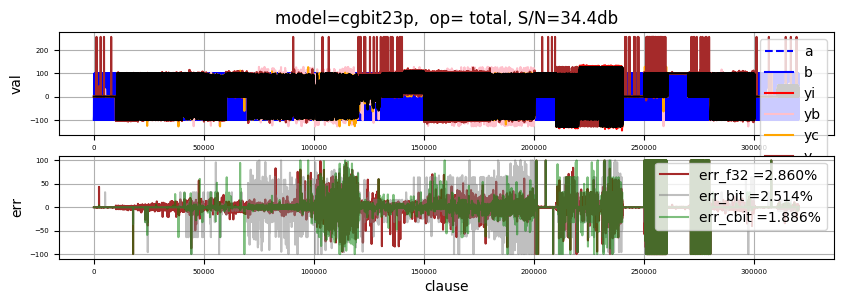

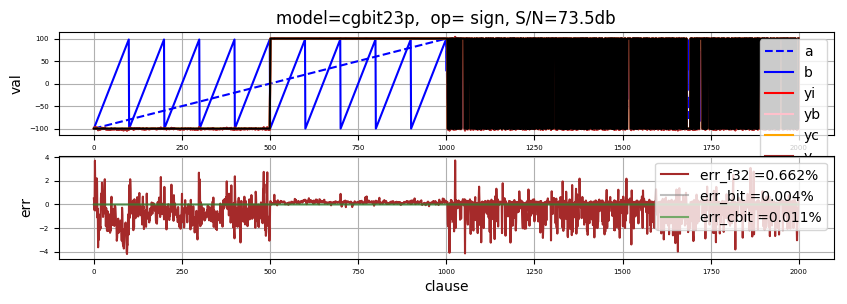

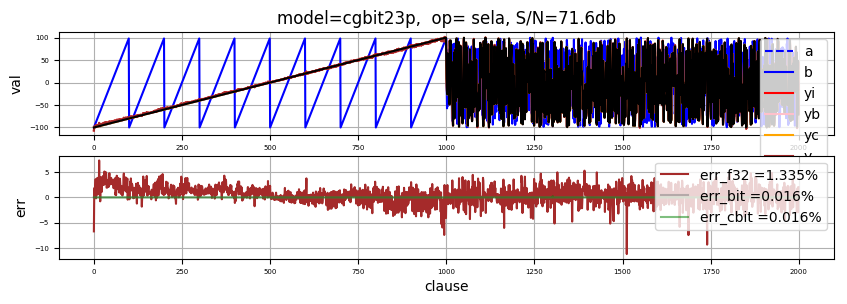

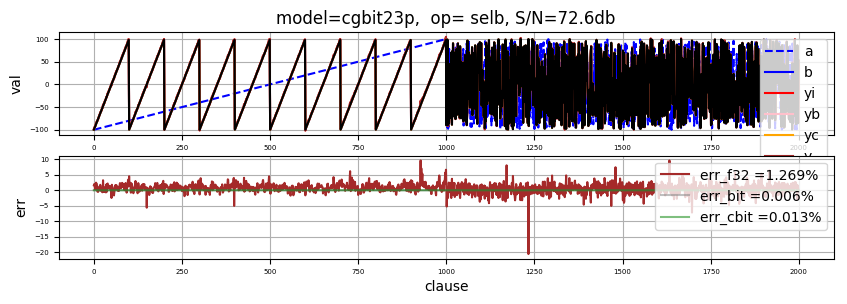

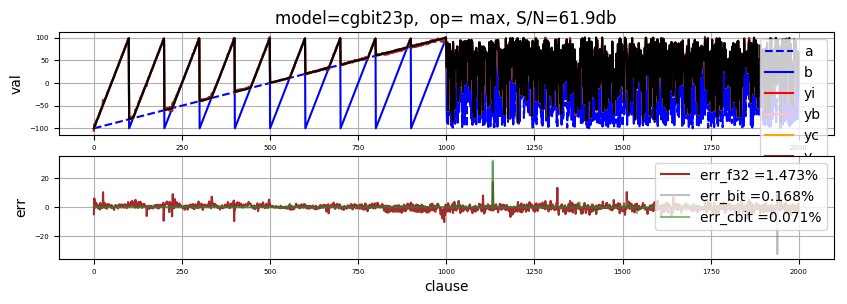

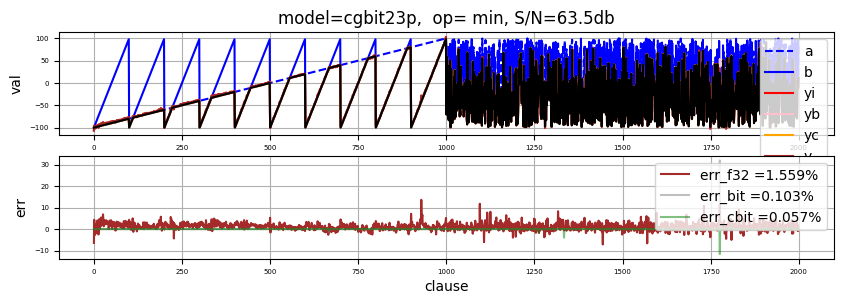

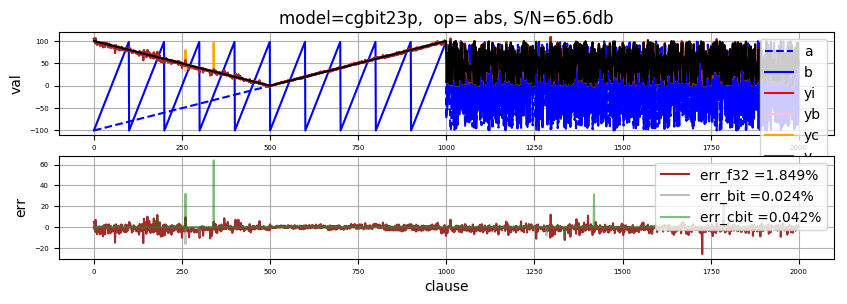

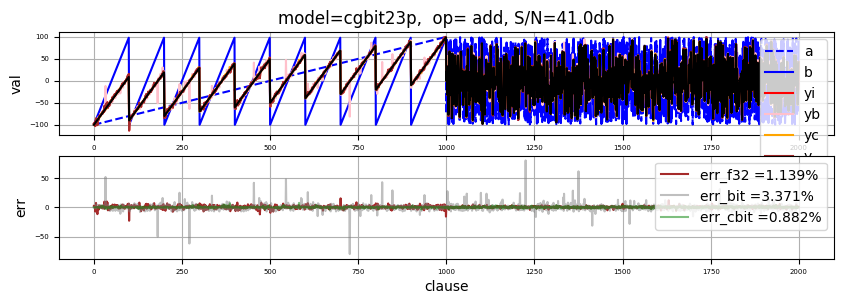

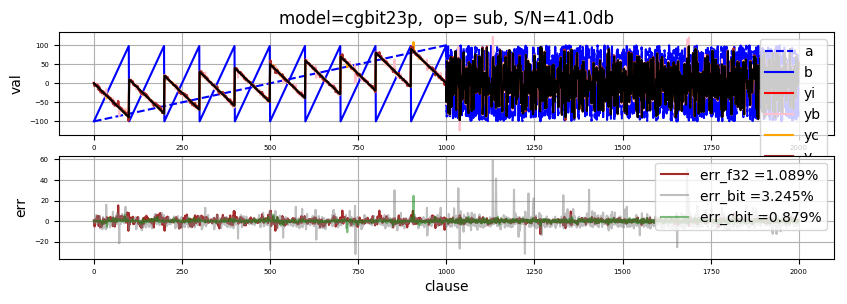

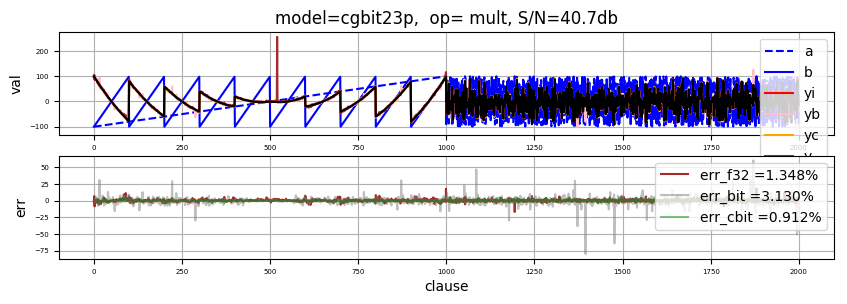

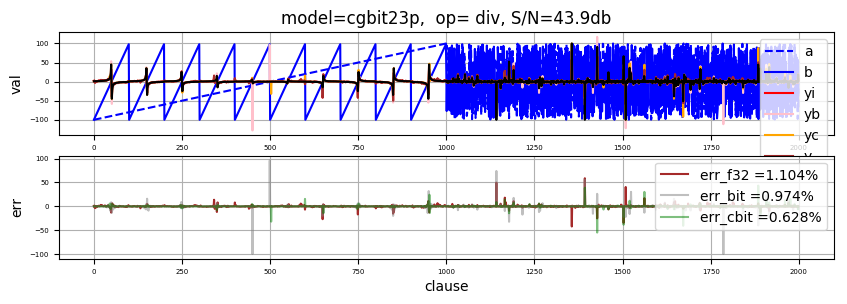

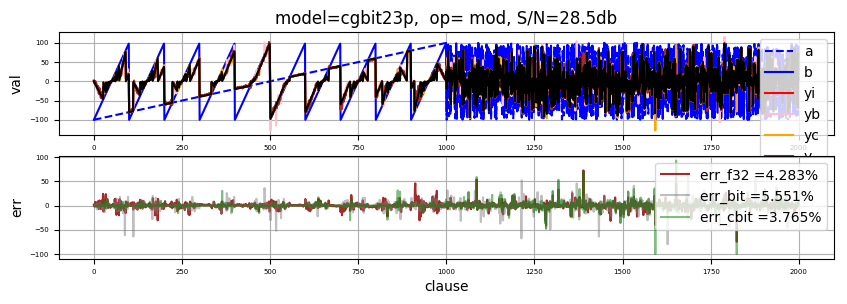

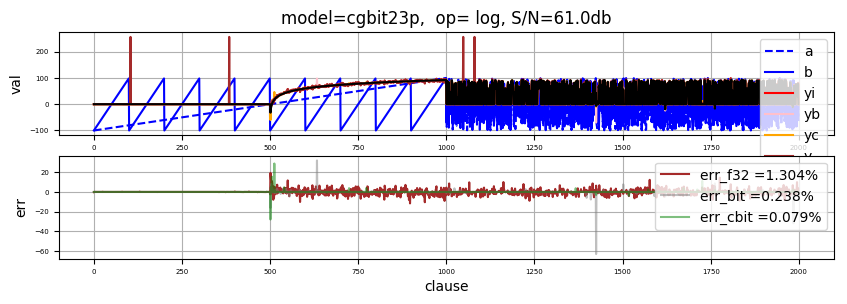

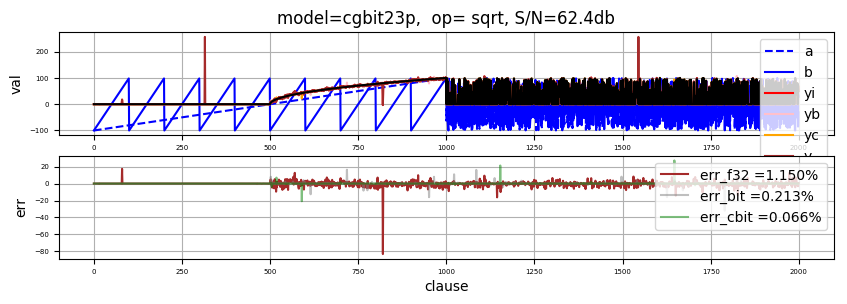

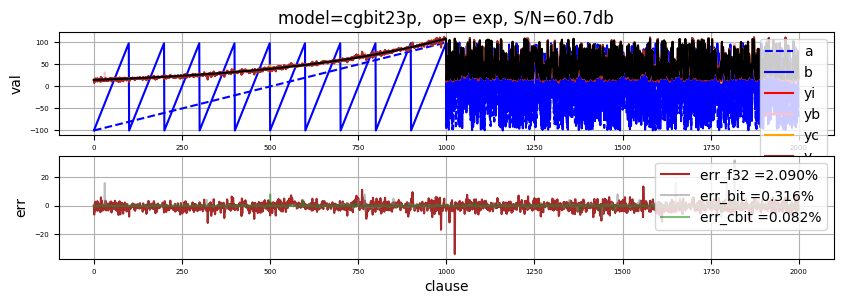

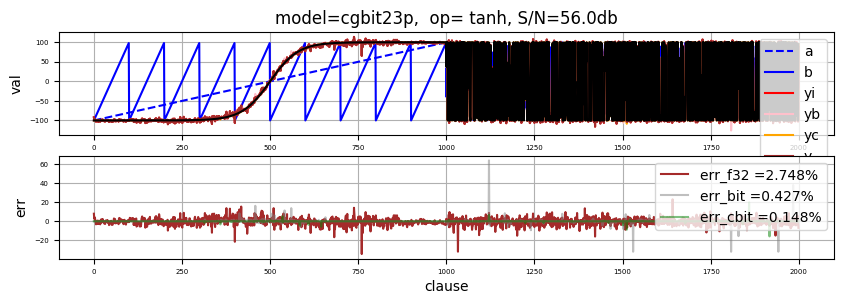

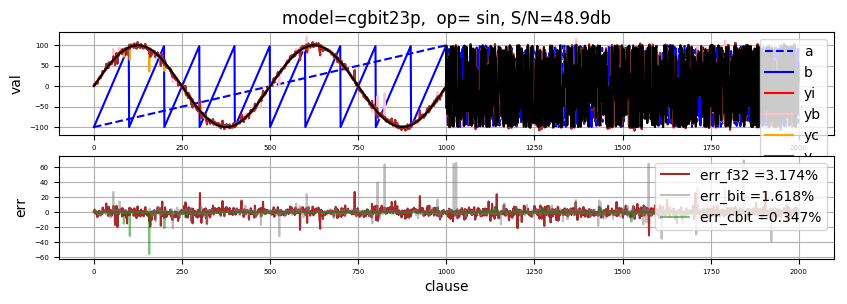

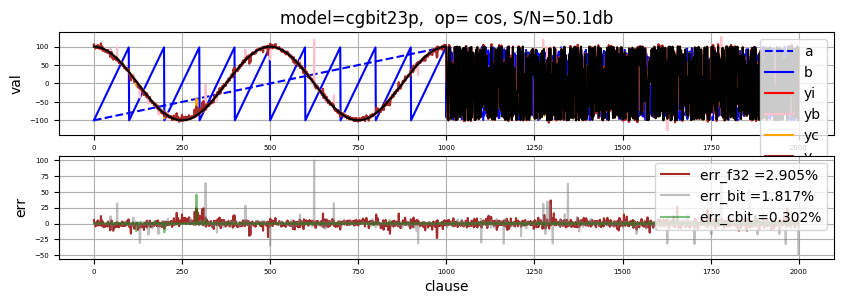

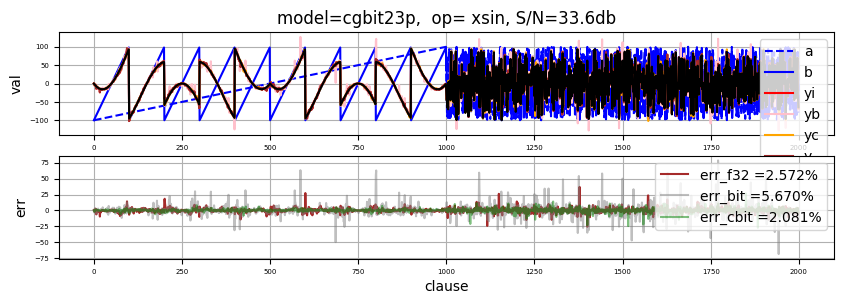

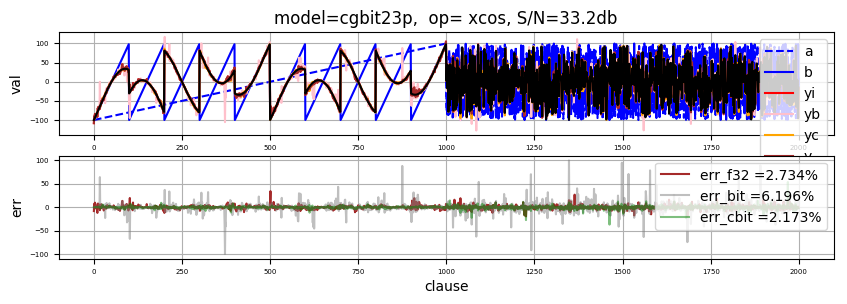

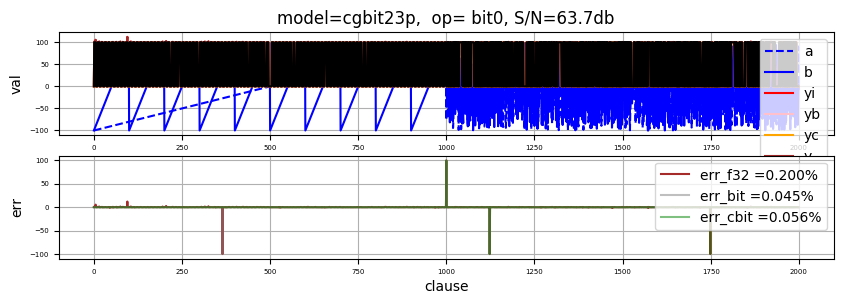

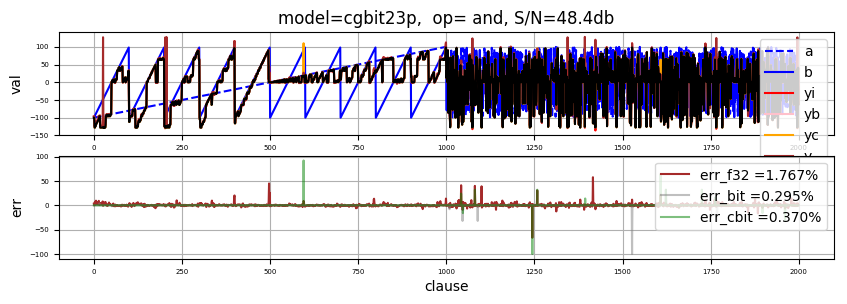

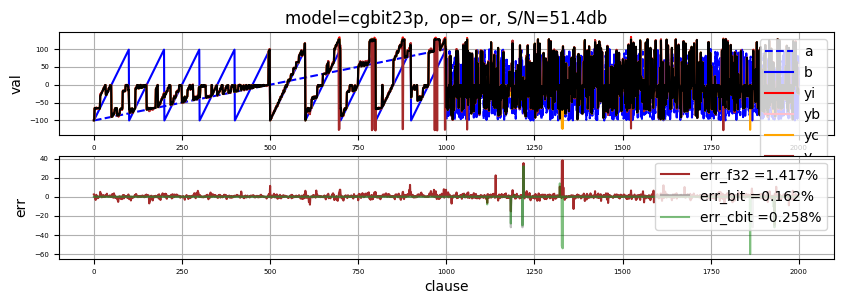

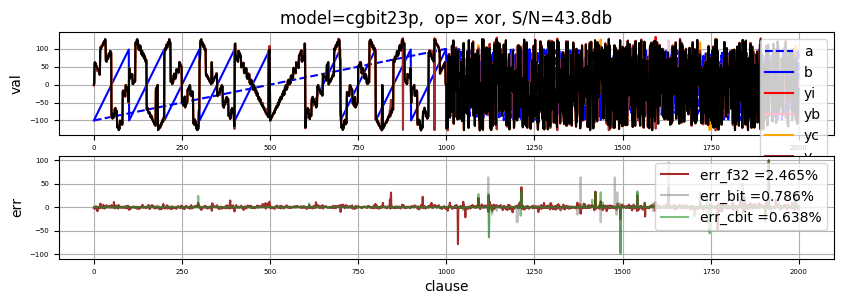

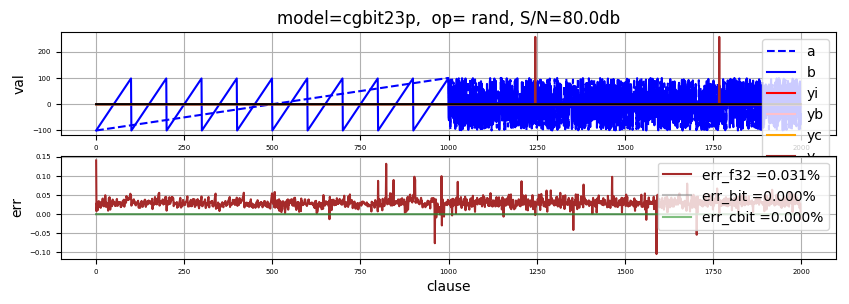

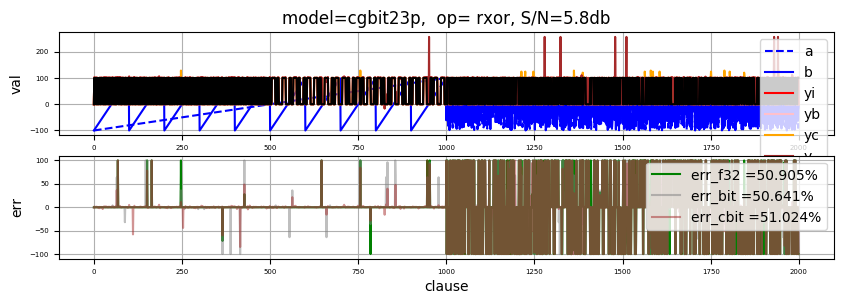

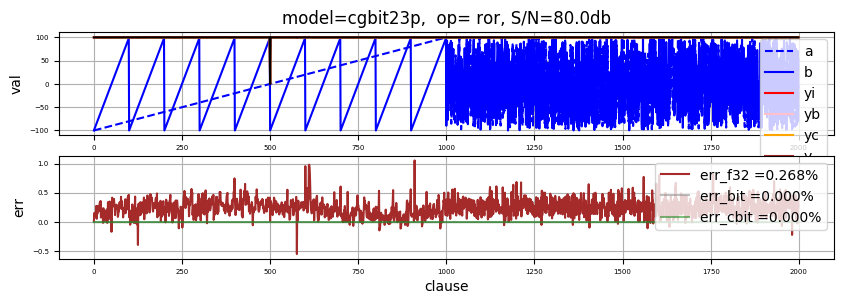

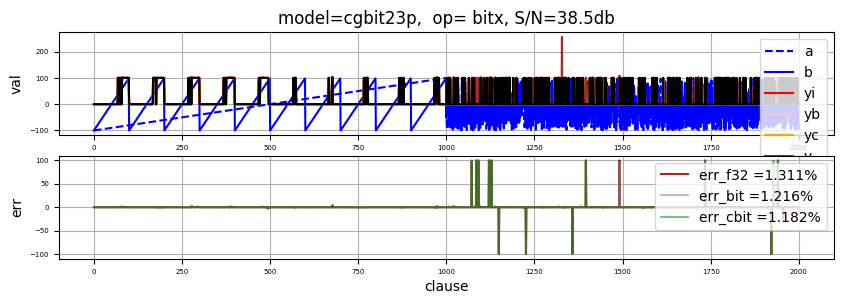

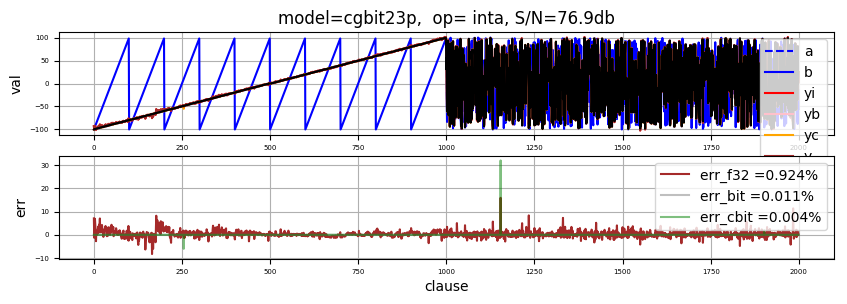

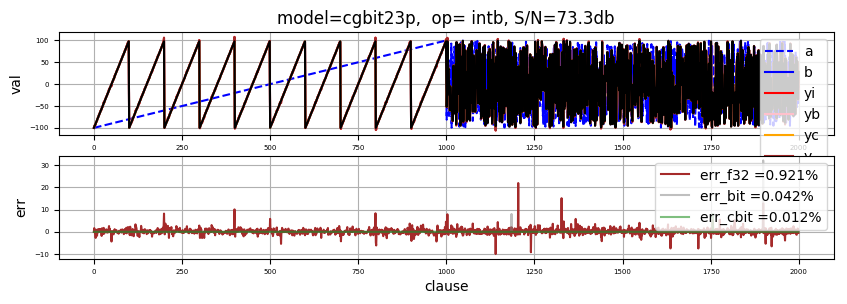

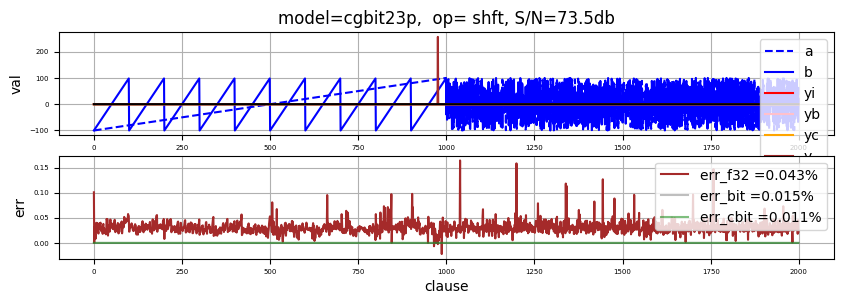

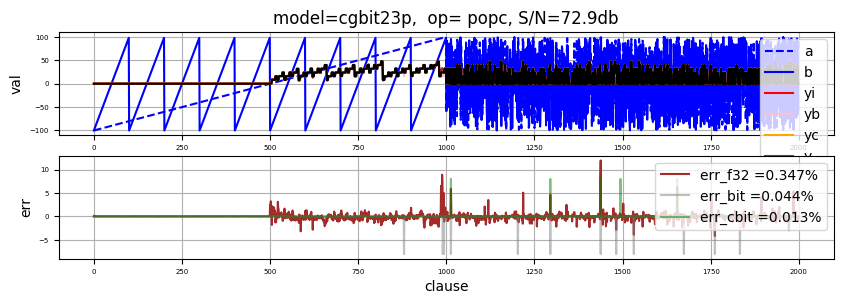

In [161]:

modlist=[ 'bit0', 'bit1', 'bit2', 'bit3', 'bit4', 'bit5', 'bit6', 'bit7' ] 
#modlist=[ 'bit3' ] 
modlist=[ 'cgbit23p' ] 

#print('\nmodel=',mname, 'nops=', nops)

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
#from math import log

from matplotlib import pylab
#from google.colab import widgets
#tb = widgets.TabBar([str(opcodes[p]) for p in range(nops)])


for mod in modlist :

    if(mod=='bit23')   : [yo,ybo_int,ybo_bit]         = bit23_model.predict(xxv, batch_size=1000, verbose=1)
    if(mod=='cbit23')  : [yo,ybo_int,ybo_bit,ybo_cbit]=cbit23_model.predict(xxv, batch_size=1000, verbose=1);
    if(mod=='cbit23a') : [yo,ybo_int,ybo_bit,ybo_cbit]=cbit23_model.predict(xxv, batch_size=1000, verbose=1);
    if(mod=='cgbit24') : [yo,ybo_int,ybo_bit,ybo_cbit ]=cbit24_model.predict(xxvg, batch_size=1000, verbose=1);

    if(mod=='cbit26')  : [yo,ybo_int,ybo_bit,ybo_cbit]=cbit26_model.predict(xxv, batch_size=1000, verbose=1);
    if(mod=='fcbit26') : [yo,ybo_int,ybo_bit,ybo_cbit]=fcbit26_model.predict(xval, batch_size=1000, verbose=1);
    if(mod=='cgbit23b') :[yo,ybo_int,ybo_bit,ybo_cbit]=cbit23b_model.predict(xxvg, batch_size=1000, verbose=1);
    if(mod=='cgbit23b0') :[yo,ybo_int,ybo_bit,ybo_cbit]=cbit23b0_model.predict(xxvg, batch_size=1000, verbose=1);

    if(mod=='ccbit23a') :[yo,ybo_int,ybo_bit,ybo_bit]=cbit23a_model.predict(xxvg, batch_size=1000, verbose=1);
    if(mod=='cbit24') :[yo,ybo_int,ybo_bit,ybo_bit]=cbit24_model.predict(xxvg, batch_size=1000, verbose=1);

    if(mod=='cgbit23p') :[yo,ybo_int,ybo_bit,ybo_cbit, yo_probe]=cbit23p_model.predict(xxvg, batch_size=1000, verbose=1);

#  if out=='fycbit': hist=model.fit(xx , [yy, ybit, ybit, ycbit], validation_data=[xval,[yval,yvbit,yvbit, yvcbit]], epochs=epochs, batch_size=batch, callbacks=[], verbose=1, shuffle=True)
    
    #reconstruct y from bits
    ybo_int [:,0:16] = np.round(ybo_int [:,0:16])
    ybo_bit [:,0:16] = np.round(ybo_bit [:,0:16])
    ybo_cbit[:,0:16] = np.round(ybo_cbit[:,0:16])

    yo_int = \
            ybo_int[:, 0]*1/256 \
           +ybo_int[:, 1]*1/128 \
           +ybo_int[:, 2]*1/64  \
           +ybo_int[:, 3]*1/32  \
           +ybo_int[:, 4]*1/16  \
           +ybo_int[:, 5]*1/8   \
           +ybo_int[:, 6]*1/4   \
           +ybo_int[:, 7]*1/2   \
           +ybo_int[:, 8]*1     \
           +ybo_int[:, 9]*2     \
           +ybo_int[:,10]*4     \
           +ybo_int[:,11]*8     \
           +ybo_int[:,12]*16    \
           +ybo_int[:,13]*32    \
           +ybo_int[:,14]*64    \
           +ybo_int[:,15]*-128   


    yo_bit= \
            ybo_bit[:, 0]*1/256 \
           +ybo_bit[:, 1]*1/128 \
           +ybo_bit[:, 2]*1/64  \
           +ybo_bit[:, 3]*1/32  \
           +ybo_bit[:, 4]*1/16  \
           +ybo_bit[:, 5]*1/8   \
           +ybo_bit[:, 6]*1/4   \
           +ybo_bit[:, 7]*1/2   \
           +ybo_bit[:, 8]*1     \
           +ybo_bit[:, 9]*2     \
           +ybo_bit[:,10]*4     \
           +ybo_bit[:,11]*8     \
           +ybo_bit[:,12]*16    \
           +ybo_bit[:,13]*32    \
           +ybo_bit[:,14]*64    \
           +ybo_bit[:,15]*-128   

    #make complex bits
    yo_cbit= \
            ybo_cbit[:, 0]*1/256 \
           +ybo_cbit[:, 1]*1/128 \
           +ybo_cbit[:, 2]*1/64  \
           +ybo_cbit[:, 3]*1/32  \
           +ybo_cbit[:, 4]*1/16  \
           +ybo_cbit[:, 5]*1/8   \
           +ybo_cbit[:, 6]*1/4   \
           +ybo_cbit[:, 7]*1/2   \
           +ybo_cbit[:, 8]*1     \
           +ybo_cbit[:, 9]*2     \
           +ybo_cbit[:,10]*4     \
           +ybo_cbit[:,11]*8     \
           +ybo_cbit[:,12]*16    \
           +ybo_cbit[:,13]*32    \
           +ybo_cbit[:,14]*64    \
           +ybo_cbit[:,15]*128   
    
    if(1) :
        yo_cbit=yo_cbit*256
        for v in range(tsamp) :
            #yo_cbit[v]= yo_cbit[v].astype(int)/256 
           #yo_cbit[v]= gray_to_int(yo_cbit[v].astype(int))
            yo_cbit[v]=gray_to_intx(yo_cbit[v].astype(int))/256
        
       
    #print(yo_cbit[20000:20100])
    #
    #print('xx    ',xx.shape)  
    #print('yy    ',yy.shape)    
    #print('yo    ',yo.shape,yo[:,0].shape)  
    #print('yo_int',yo_int.shape)  
    #print('yo_bit',yo_bit.shape)  
     

    erra  = yo     [:,0]-yval[:,0] 
    erri  = yo_int [:  ]-yval[:,0]
    errb  = yo_bit [:  ]-yval[:,0]
    errc  = yo_cbit[:  ]-yval[:,0]

    erra  =np.minimum(100,np.maximum(erra,-100))
    errb  =np.minimum(100,np.maximum(errb,-100))
    errc  =np.minimum(100,np.maximum(errc,-100))
    
    iopsize=int(1000)
    vopsize=int(2000)
    #topsize=int(opsize/2)  
    print(iopsize,topsize, tsamp, erra.shape,errb.shape)

    tmaea = np.mean(np.absolute((erra[0+iopsize:tsamp])))
    tmaei = np.mean(np.absolute((erri[0+iopsize:tsamp])))
    tmaeb = np.mean(np.absolute((errb[0+iopsize:tsamp])))
    tmaec = np.mean(np.absolute((errc[0+iopsize:tsamp])))
    #tstda=np.std(erra[0+iopsize:tsamp])
    #tstdi=np.std(erri[0+iopsize:tsamp])
    #tstdb=np.std(errb[0+iopsize:tsamp])

      

    
    for p in range(0,nops) :
        
        i=p*topsize
         
        #print(i)
        maea = np.mean(np.absolute((erra[i+iopsize:i+topsize])))
        maei = np.mean(np.absolute((erri[i+iopsize:i+topsize])))
        maeb = np.mean(np.absolute((errb[i+iopsize:i+topsize])))
        maec = np.mean(np.absolute((errc[i+iopsize:i+topsize])))
        stda=np.std(erra[i+iopsize:i+opsize])
        #stdi=np.std(erri[i+iopsize:i+opsize])
        #stdb=np.std(errb[i+iopsize:i+opsize])
        #print(std)
        
        dpi = 200
        xinch = 2000 / dpi
        yinch =  600 / dpi
            
        #with tb.output_to(p,select=p<1) :
        if 1:
        
            if p==0 : 
                vopsize=int (tsamp)
                maea=tmaea
                maei=tmaei
                maeb=tmaeb
                maec=tmaec
                opcodes[0]="total"
            else    : vopsize=int (tsamp/32/5)
            
            #print(maea,maei,maeb,maec)
            
            maea_db= 20 * -math.log(maea/100+.0001, 10)
            maei_db= 20 * -math.log(maei/100+.0001, 10)
            maeb_db= 20 * -math.log(maeb/100+.0001, 10)
            maec_db= 20 * -math.log(maec/100+.0001, 10)
            #print( maea_db,maei_db,maeb_db,maec_db,'\n',)
            
             
            # plot and save in the same size as the original
            fig = plt.figure(figsize=(xinch,yinch),dpi=100)
            plt.subplot(2, 1, 1)
        
            plt.plot(xxv [i+0:i+vopsize,0],label="a",color='blue',linestyle='--')
            plt.plot(xxv [i+0:i+vopsize,1],label="b",color='blue',linestyle='-')
    
            #plt.plot(yi    [i+0:i+2000],    label="yi",color='pink')
    
            plt.plot(yo     [i+0:i+vopsize],    label="ya",color='red')
            plt.plot(yo_bit [i+0:i+vopsize],    label="yb",color='pink')
            plt.plot(yo_cbit[i+0:i+vopsize],    label="yc",color='orange')
            plt.plot(yo_int [i+0:i+vopsize],    label="yi",color='brown')
            plt.plot(yval   [i+0:i+vopsize,0],  label="y",color='black')
            
            
            title= 'model=' + mod + ",  op=" +' '+ opcodes[p] + ', S/N=' + str('%3.1f'% maec_db)+ 'db'
            
            plt.title(title)
            plt.ylabel('val')
            
            plt.legend(['a', 'b', 'yi', 'yb', 'yc', 'y' ], loc='upper right')
            plt.grid(True)
            
            plt.subplot(2, 1, 2)
            plt.ylabel('err')
            plt.xlabel('clause')
            plt.grid(True)
            
            if maea > maec :
                #plt.plot(erri[i:i+opsize]+00, label="err_i",color='gray')
                plt.plot(erra[i:i+vopsize],    label="err_f32",color='brown')
                plt.plot(errb[i:i+vopsize]+00, label="err_bit",color='gray',alpha=.5)
                plt.plot(errc[i:i+vopsize]+00, label="err_cbit",color='green',alpha=.5)
            else :
                plt.plot(errc[i:i+vopsize]+00, label="err_cbit",color='green')
                plt.plot(errb[i:i+vopsize]+00, label="err_bit",color='gray',alpha=.5)
                plt.plot(erra[i:i+vopsize],    label="err_f32",color='brown',alpha=.5)
                #plt.plot(erri[i:i+opsize]+00, label="err_i",color='gray')
            
            #plt.plot(errio [i:i+opsize], label="errio",color='black')
    
              
            plt.plot([0,0], label="zero")

            la='err_f32 =' + str('%3.3f%%'% maea) 
            lb='err_bit =' + str('%3.3f%%'% maeb) 
            lc='err_cbit ='+ str('%3.3f%%'% maec) 
            plt.legend([la,lb, lc], loc='upper right')
  
   





# Make correllation 

In [162]:
ninps = nvars + nops + nvars * nbits
nouts = 1  + 3 * 16 + 3 + 3 ;
nhids = yprobe.shape[1];

olabels = [ 'yo',\
            'yint[0]', 'yint[1]', 'yint[2]', 'yint[3]',' yint[4]', 'yint[5]', 'yint[6]', 'yint[7]', 'yint[8]', 'yint[9]', 'yint[10]', 'yint[11]', 'yint[12]', 'yint[13]', 'yint[14]', 'yint[15]',\
            'ybit[0]', 'ybit[1]', 'ybit[2]', 'ybit[3]',' ybit[4]', 'ybit[5]', 'ybit[6]', 'ybit[7]', 'ybit[8]', 'ybit[9]', 'ybit[10]', 'ybit[11]', 'ybit[12]', 'ybit[13]', 'ybit[14]', 'ybit[15]',\
            'ycbit[0]','ycbit[1]','ycbit[2]','ycbit[3]','ycbit[4]','ycbit[5]','ycbit[6]','ycbit[7]','ycbit[8]','ycbit[9]','ycbit[10]','ycbit[11]','ycbit[12]','ycbit[13]','ycbit[14]','ycbit[15]',\
            'yo_int',' yo_bit','yo_cbit', 'erra', 'erri', 'errc']



ilabels = [ 'x0','x1','x2','x3',  \
            'total', 'sign', 'sela', 'selb', 'max', 'min', 'abs', 'add', 'sub','mult', 'div', 'mod', 'log', 'sqrt', 'exp', 'tanh', 
            'sin', 'cos','xsin', 'xcos', 'bit0', 'and', 'or', 'xor', 'rand', 'rxor', 'ror','bitx', 'inta', 'intb', 'shft', 'popc',\
            'x0bit[0]', 'x0bit[1]', 'x0bit[2]', 'x0bit[3]','xvbit[4]', 'x0bit[5]', 'x0bit[6]', 'x0bit[7]', 'x0bit[8]', 'x0bit[9]', 'x0bit[10]', 'x0bit[11]', 'x0bit[12]', 'x0bit[13]', 'x0bit[14]', 'x0bit[15]',\
            'x1bit[0]', 'x1bit[1]', 'x1bit[2]', 'x1bit[3]','xvbit[4]', 'x1bit[5]', 'x1bit[6]', 'x1bit[7]', 'x1bit[8]', 'x1bit[9]', 'x1bit[10]', 'x1bit[11]', 'x1bit[12]', 'x1bit[13]', 'x1bit[14]', 'x1bit[15]',\
            'x2bit[0]', 'x2bit[1]', 'x2bit[2]', 'x2bit[3]','xvbit[4]', 'x2bit[5]', 'x2bit[6]', 'x2bit[7]', 'x2bit[8]', 'x2bit[9]', 'x2bit[10]', 'x2bit[11]', 'x2bit[12]', 'x2bit[13]', 'x2bit[14]', 'x2bit[15]',\
            'x3bit[0]', 'x3bit[1]', 'x3bit[2]', 'x3bit[3]','xvbit[4]', 'x3bit[5]', 'x3bit[6]', 'x3bit[7]', 'x3bit[8]', 'x3bit[9]', 'x3bit[10]', 'x3bit[11]', 'x3bit[12]', 'x3bit[13]', 'x3bit[14]', 'x3bit[15]']

hlabels=[]
for ol in range (400) :
    hlabels.append(  str('x%3d'% ol))
print('hlabels', hlabels)

#print(xval.shape,yo.shape,ybo_int.shape, ybo_cbit.shape,yo_int.shape,yo_bit.shape, yo_cbit.shape,erra.shape)
#print(xval[0:10,0:4].shape,xval[0:10,1].shape,xval[0:10,4:10].shape)


omat = np.concatenate([yo,(ybo_int*200-100),(ybo_bit*200-100),(ybo_cbit*200-100),\
                       np.column_stack((yo_int, yo_bit,yo_cbit, erra*100, erri*100, errc*100))], axis=1)

imat = np.concatenate( [xval[:,0:4]\
                       ,xval[:,4:36]*100 \
#                       ,(xvbit0),(xvbit1),(xvbit2), (xvbit3)],axis=1)  
                       ,(xvbit0*200-100),(xvbit1*200-100),(xvbit2*200-100), (xvbit3*200-100)],axis=1)  


hmat = yo_probe*100
print('ninps', ninps)
print('nouts', nouts)
print('nhids', nhids)


print('omat', omat.shape)
print('imat', imat.shape)
print('hmat', hmat.shape)

print('omat', omat[0:10000,0].shape)
print('imat', imat[0:10000,0].shape)
print('hmat', hmat[0:10000,0].shape)

print('omat', omat[20000:20010,0])
print('imat', imat[20000:20010,0])
print('hmat', hmat[20000:20010,0:10])

print('xlabels', ilabels)
print('ylabels', olabels)
print('hlabels', hlabels)

print('olabels', len(olabels))
print('ilabels', len(ilabels))
print('hlabels', len(hlabels))

print('opcodes', len(opcodes))

hlabels ['x  0', 'x  1', 'x  2', 'x  3', 'x  4', 'x  5', 'x  6', 'x  7', 'x  8', 'x  9', 'x 10', 'x 11', 'x 12', 'x 13', 'x 14', 'x 15', 'x 16', 'x 17', 'x 18', 'x 19', 'x 20', 'x 21', 'x 22', 'x 23', 'x 24', 'x 25', 'x 26', 'x 27', 'x 28', 'x 29', 'x 30', 'x 31', 'x 32', 'x 33', 'x 34', 'x 35', 'x 36', 'x 37', 'x 38', 'x 39', 'x 40', 'x 41', 'x 42', 'x 43', 'x 44', 'x 45', 'x 46', 'x 47', 'x 48', 'x 49', 'x 50', 'x 51', 'x 52', 'x 53', 'x 54', 'x 55', 'x 56', 'x 57', 'x 58', 'x 59', 'x 60', 'x 61', 'x 62', 'x 63', 'x 64', 'x 65', 'x 66', 'x 67', 'x 68', 'x 69', 'x 70', 'x 71', 'x 72', 'x 73', 'x 74', 'x 75', 'x 76', 'x 77', 'x 78', 'x 79', 'x 80', 'x 81', 'x 82', 'x 83', 'x 84', 'x 85', 'x 86', 'x 87', 'x 88', 'x 89', 'x 90', 'x 91', 'x 92', 'x 93', 'x 94', 'x 95', 'x 96', 'x 97', 'x 98', 'x 99', 'x100', 'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108', 'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123',

In [168]:

if 1 : cmode='inp-inp'
if 1 : cmode='inp-out'
if 1 : cmode='inp-hid'
if 1 : cmode='hid-out'
    
print('cmode =' , cmode)

if cmode=='inp-inp':
  nx=ninps; ny=ninps
  cmat = np.zeros((nops, ninps, ninps))
  for  op in range (nops)  :                    
      printf('.')
      for  i in range (ninps)  :                    
          for  o in range (ninps)  :   
              v=op*topsize 
              iv=imat[v:v+ topsize,i ]
              #ov=omat[v:v+ topsize,o ]
              corr = np.dot(iv,iv)
  
if cmode=='inp-out' : 
  nx=ninps; ny=nouts
  cmat = np.zeros((nops, ninps, nouts))
  for  op in range (nops)  :                    
      printf('.')
      for  i in range (ninps)  :                    
          for  o in range (nouts)  :   
              v=op*topsize 
              iv=imat[v:v+ topsize,i ]
              ov=omat[v:v+ topsize,o ]
              corr = np.dot(iv,ov)
              cmat[op,i,o] = corr
            

              
if cmode=='inp-hid': 
  nx=ninps; ny=nhids
  cmat = np.zeros((nops, ninps, nhids))
  for  op in range (nops)  :
      printf('.')
      for  i in range (ninps)  :                    
          for  o in range (nhids)  :   
              v=op*topsize 
              iv=imat[v:v+ topsize,i ]
              hv=hmat[v:v+ topsize,o ]
              corr = np.dot(iv,hv)
              cmat[op,i,o] = corr
  
 
if cmode=='hid-out' : 
  nx=nhids; ny=nouts
  cmat = np.zeros((nops, nhids, nouts))
  for  op in range (nops)  :                    
      printf('.')
      for  i in range (nhids)  :                    
          for  o in range (nouts)  :   
              v=op*topsize 
              hv=hmat[v:v+ topsize,i ]
              ov=omat[v:v+ topsize,o ]
              corr = np.dot(hv,ov)
              cmat[op,i,o] = corr
            
#print('cmat =' , cmat[0:10,0:10])
print('cmat', cmat.shape, nx, ny)
   
                      
                      

cmode = hid-out
................................cmat (32, 400, 55) 400 55


cmode = hid-out (32, 400, 55) 400 55
(32, 55)
(32, 400)
hihihihihihihihihihihihihihihihihihi

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


hihihihihihihihihihihihihihi

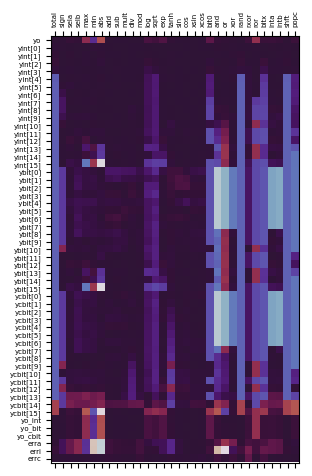

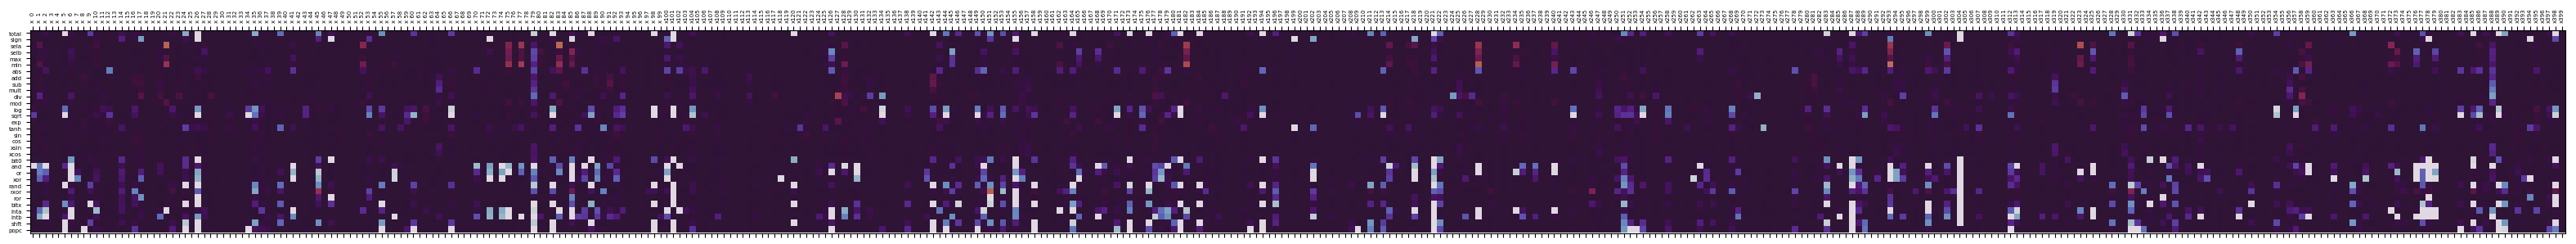

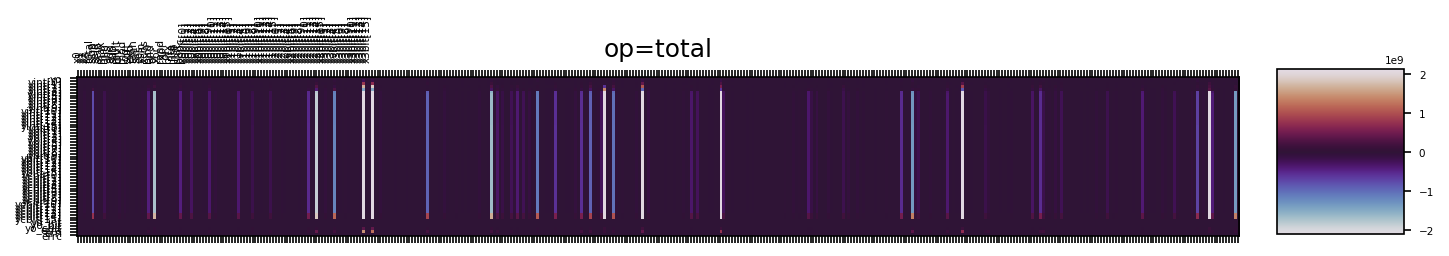

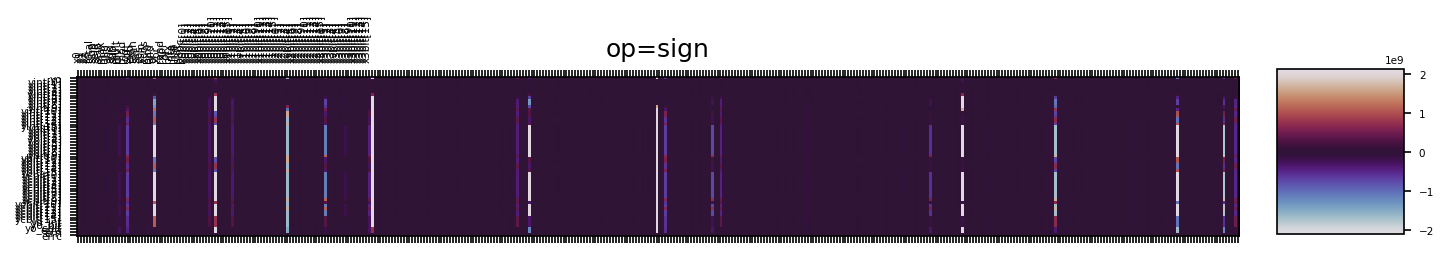

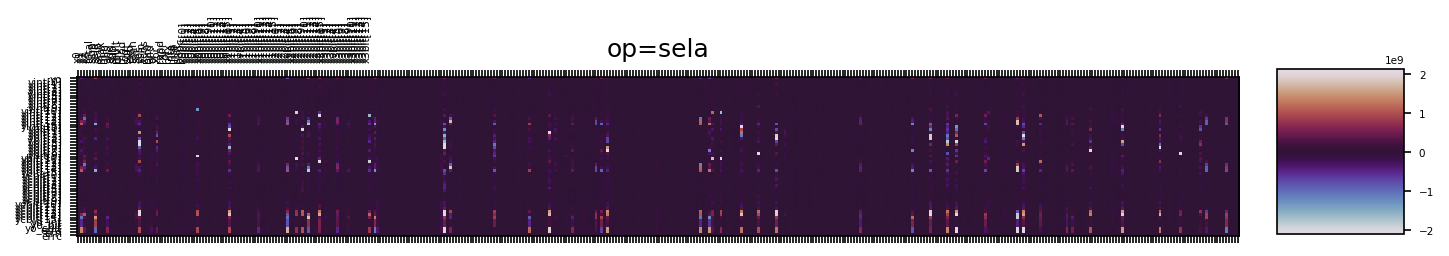

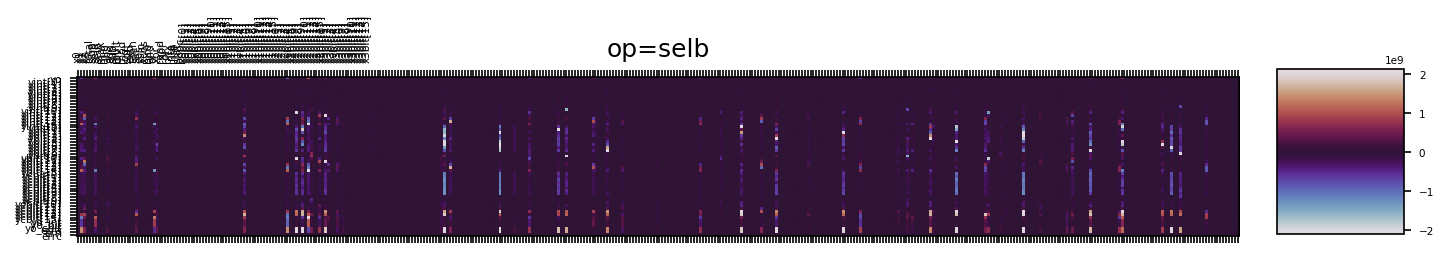

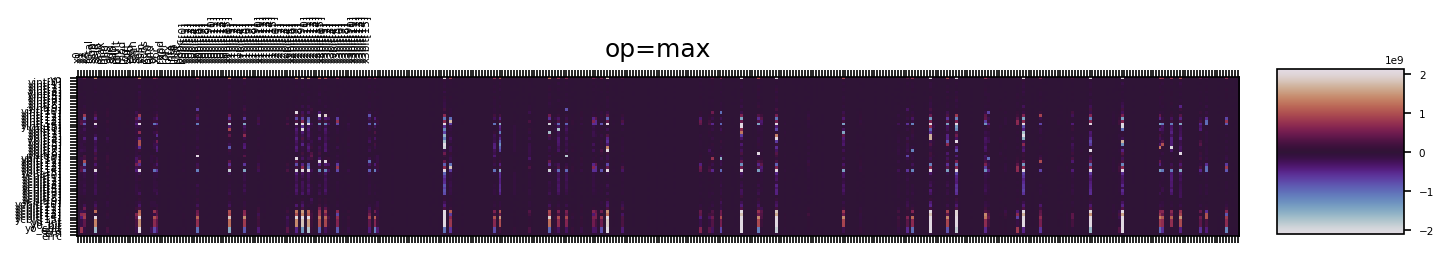

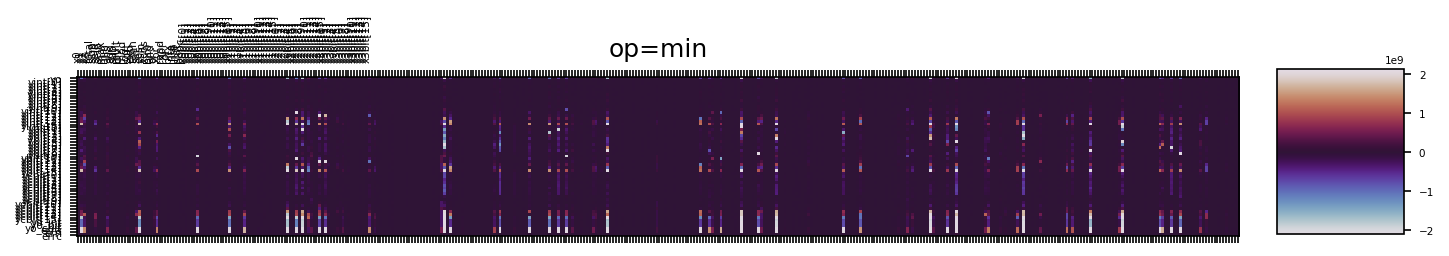

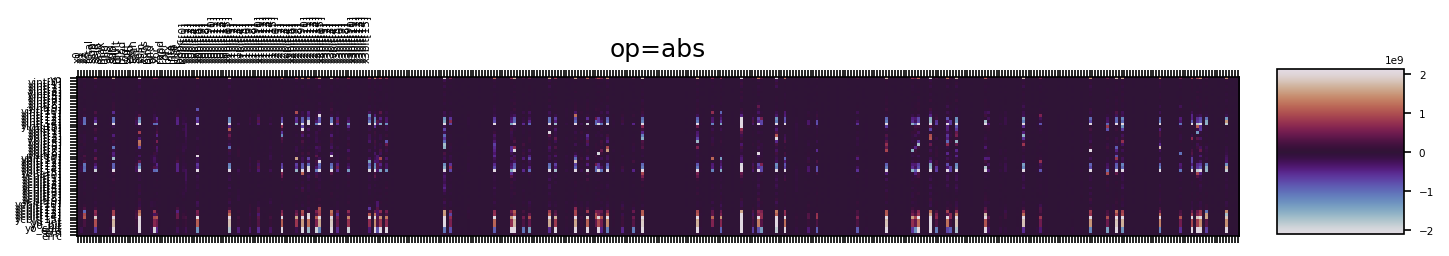

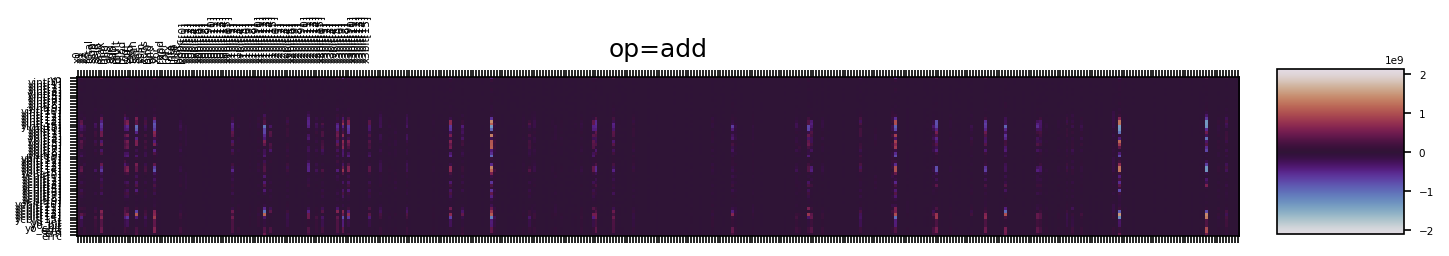

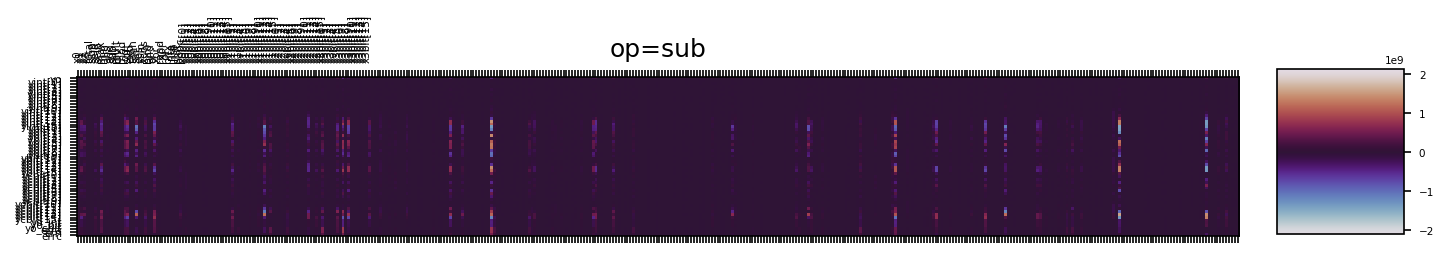

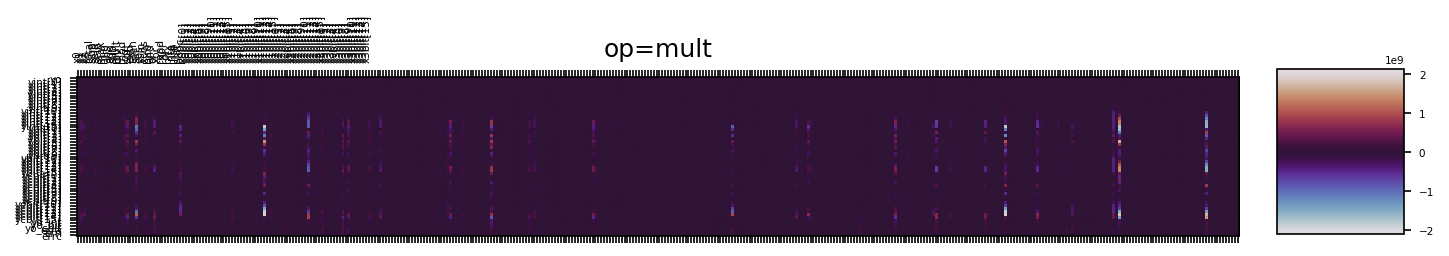

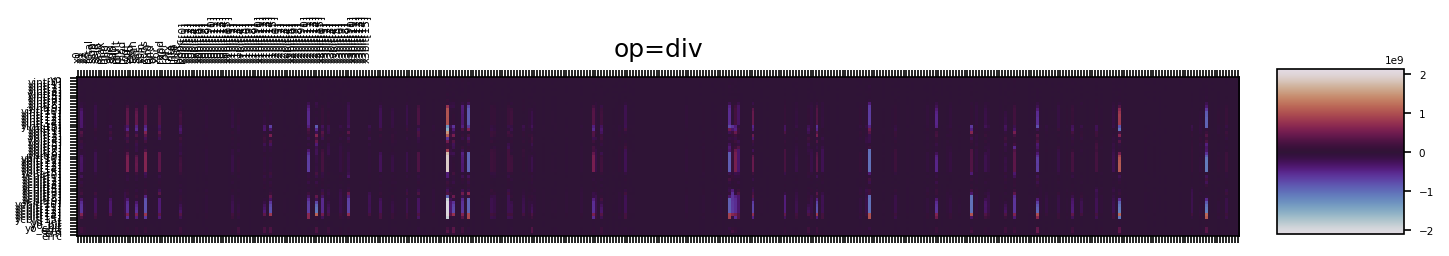

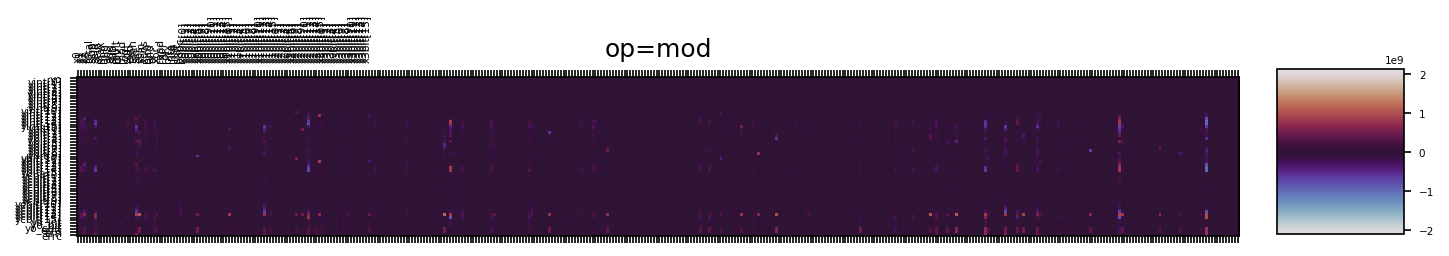

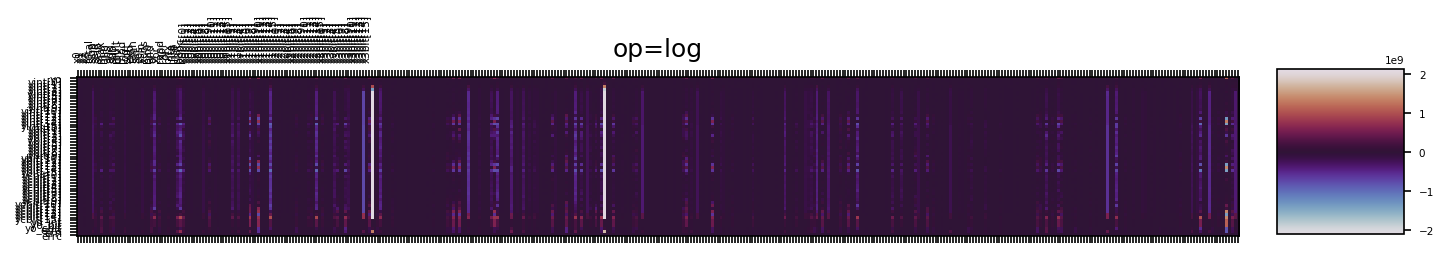

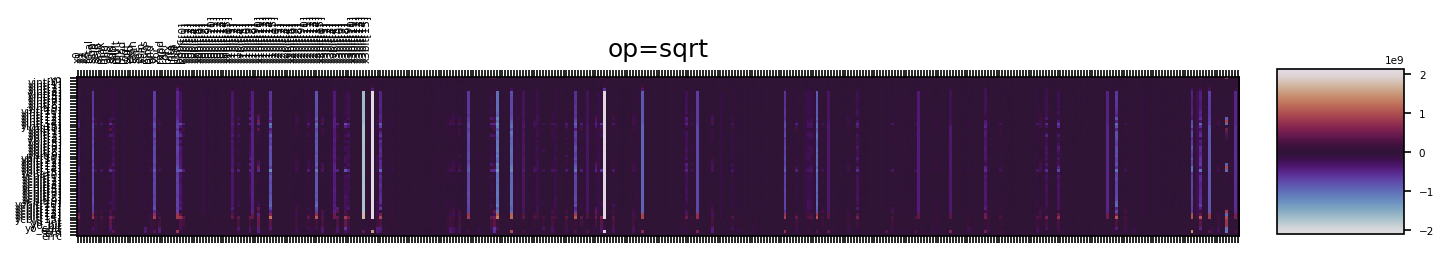

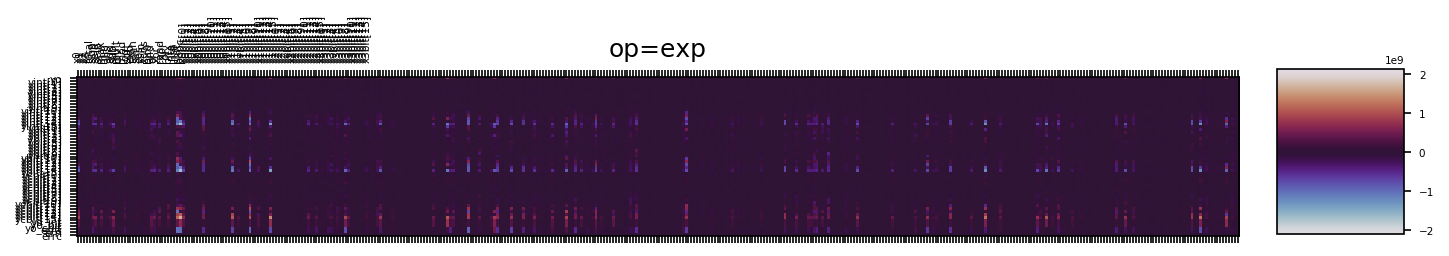

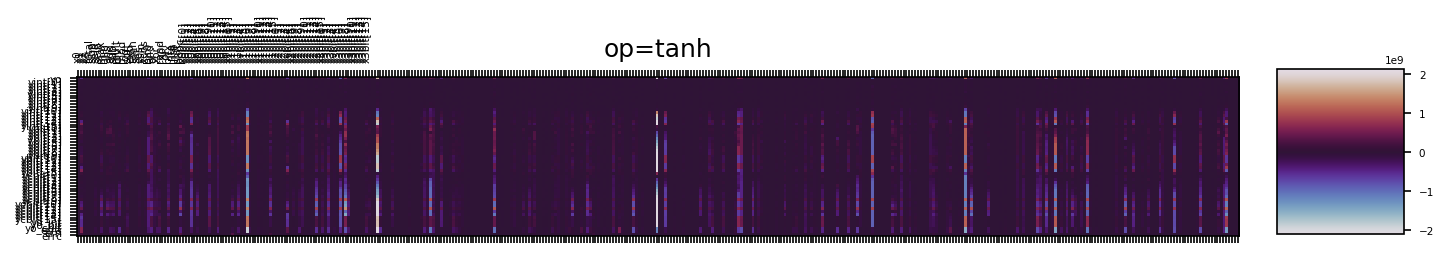

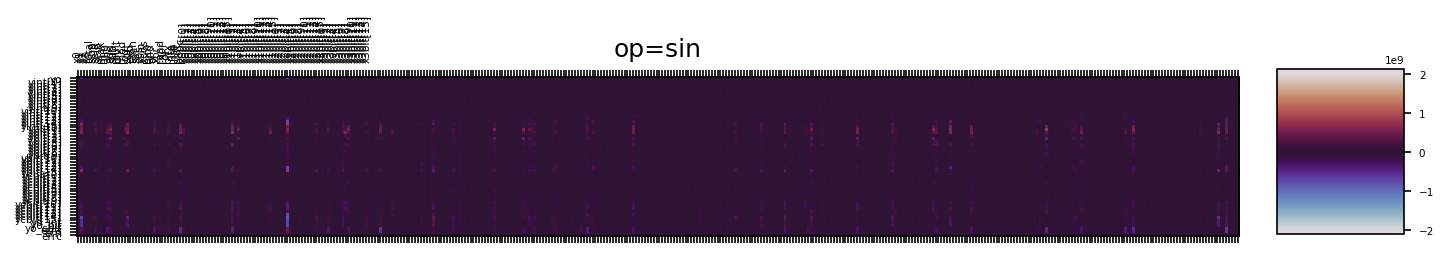

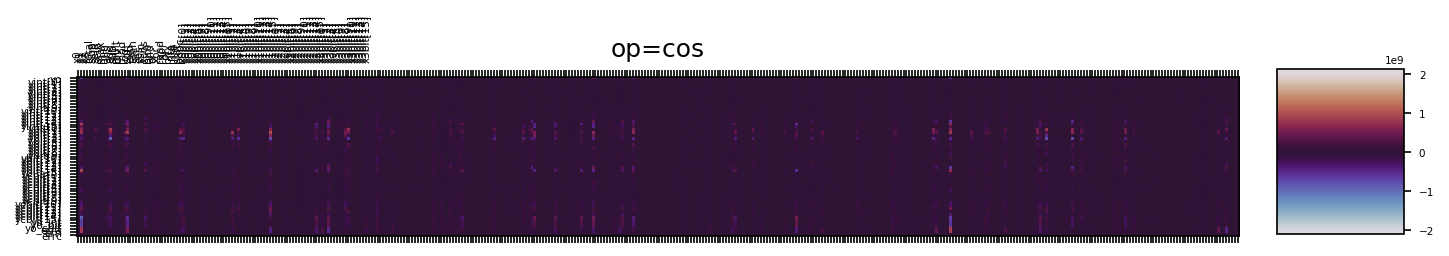

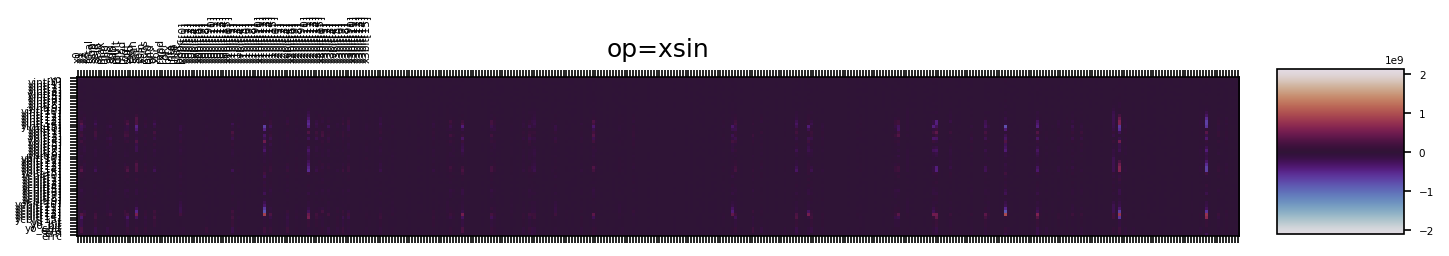

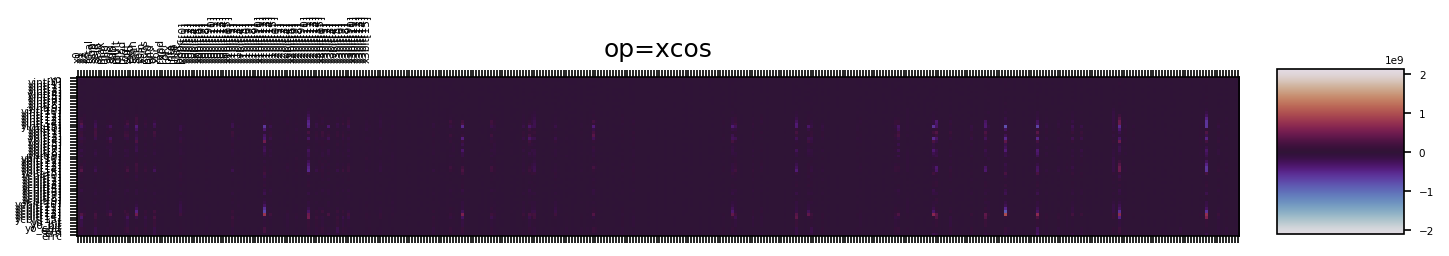

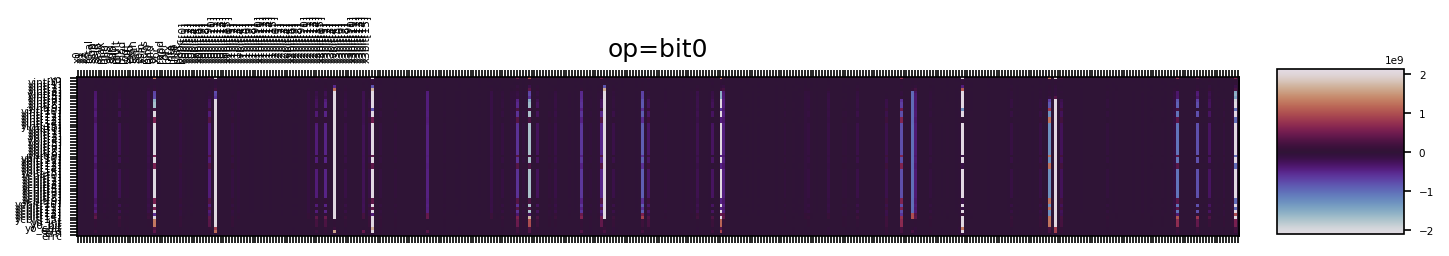

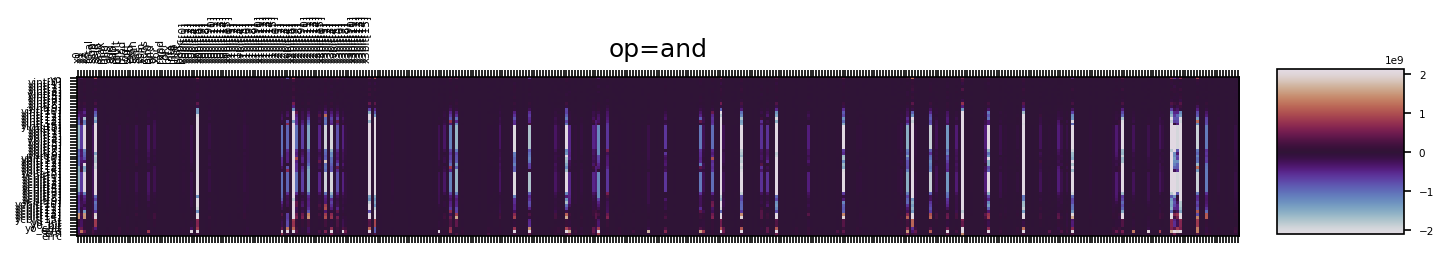

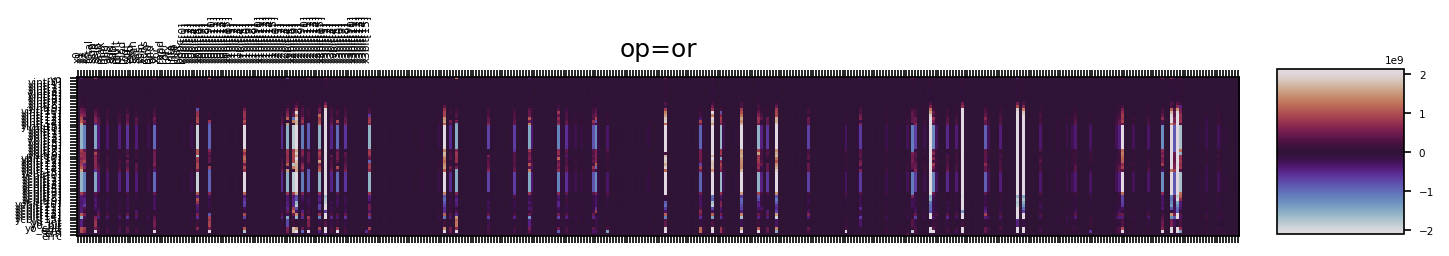

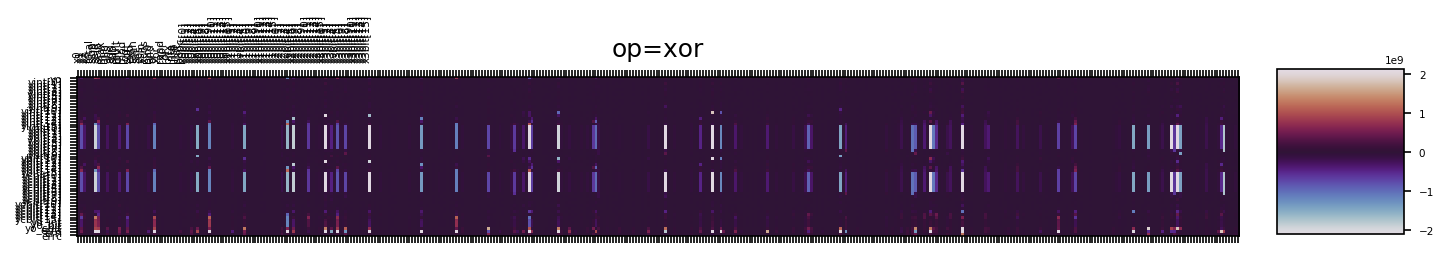

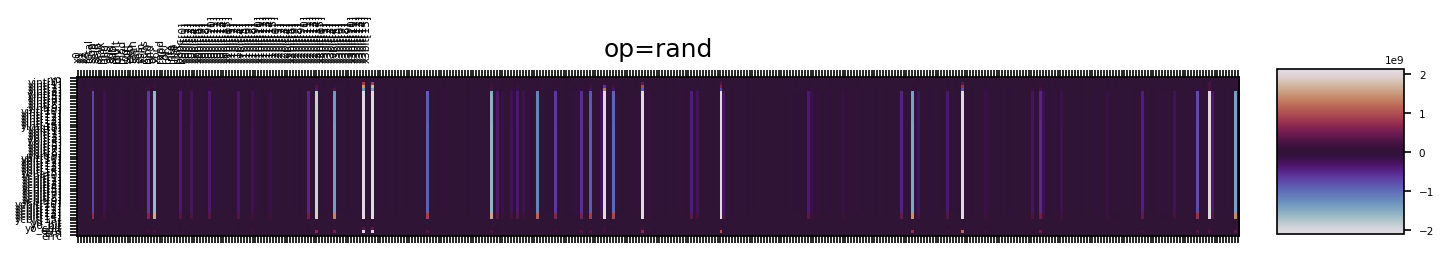

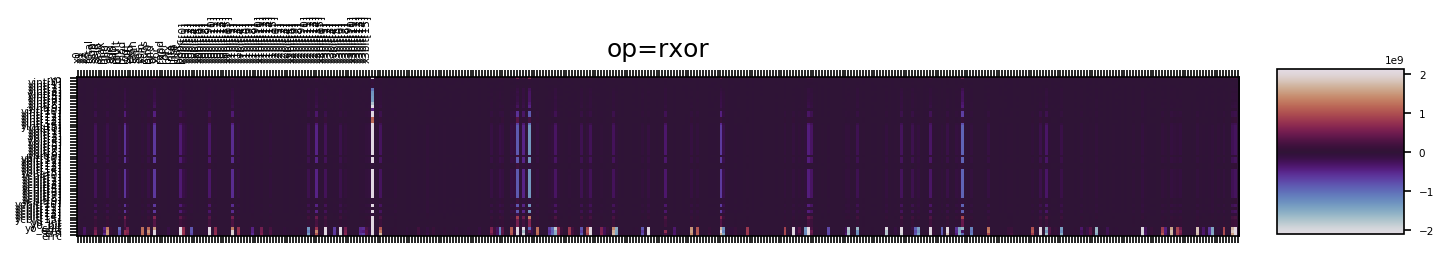

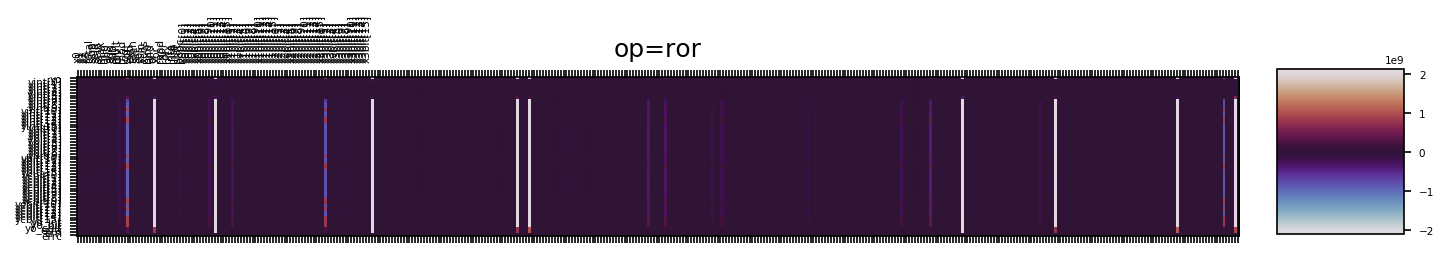

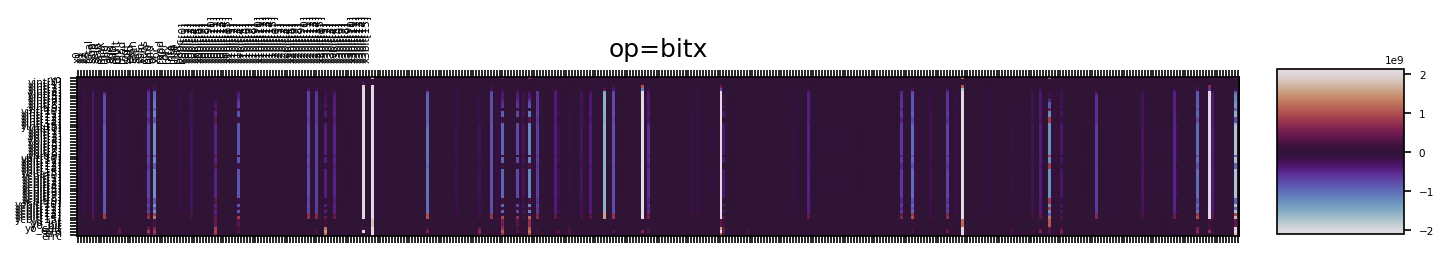

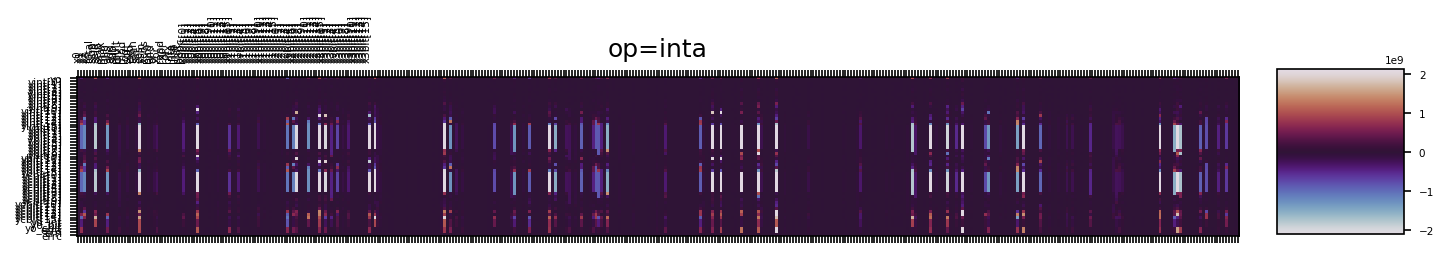

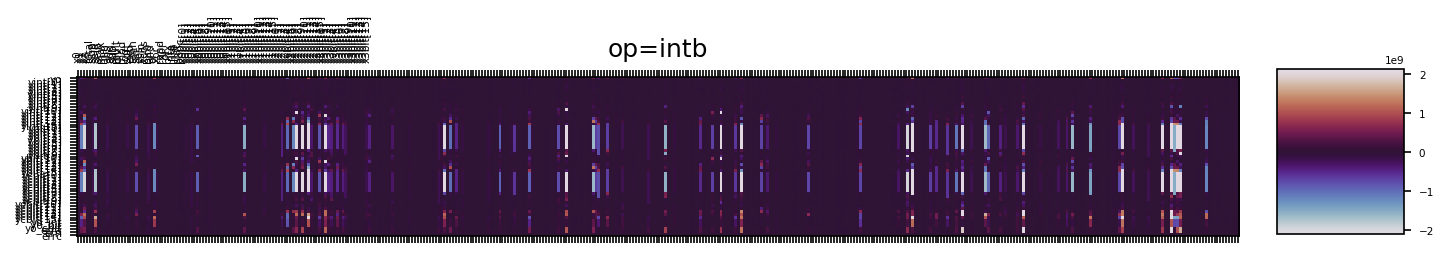

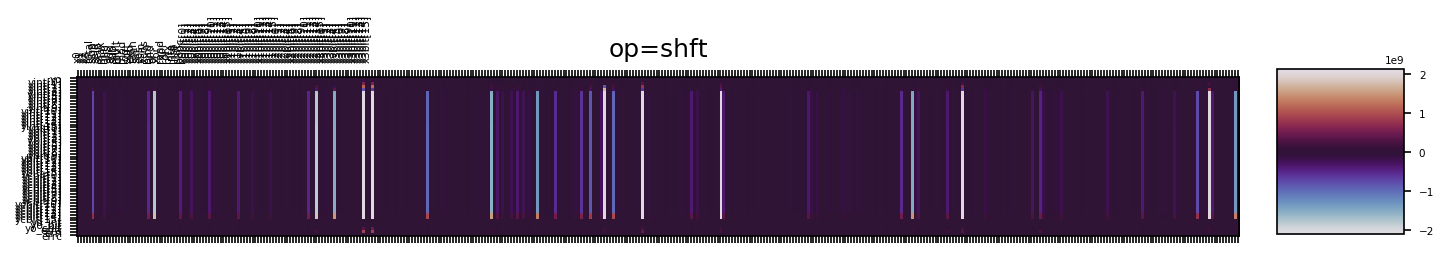

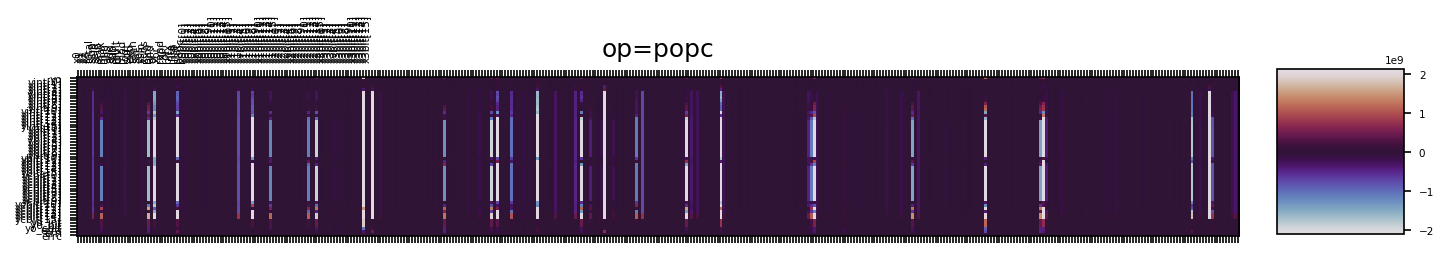

In [170]:
#print(imat[20000,:])
print('cmode =' , cmode, cmat.shape, nx, ny)
#print('cmat =' , cmat[0:10,0:10])

cmax=np.amax(cmat[:,:,:])
cmin=np.amin(cmat)
cscale=max(cmax,-cmin)


matfig = plt.figure(figsize=(nops/10,ny/10),dpi=100)
plt.matshow(np.mean(cmat.T, axis=1), fignum=matfig.number, cmap='twilight',vmin=-cscale/50, vmax=cscale/50)        
plt.xticks (np.arange(0,nops,1), opcodes[0:nops:1], rotation= 90)
    
if cmode=='inp-inp' :
    plt.yticks (np.arange(0,ny,1), ilabels[0:ny:1], rotation= 0)

if  cmode=='inp-out' or cmode=='hid-out' :
    plt.yticks (np.arange(0,ny,1), olabels[0:ny:1], rotation= 0)

if  cmode=='inp-hid' :
    plt.yticks (np.arange(0,ny,1), hlabels[0:ny:1], rotation= 0)


print(np.mean(cmat, axis=1).shape)


matfig = plt.figure(figsize=(nx/10,nops/10),dpi=100)
plt.matshow(np.mean(cmat, axis=2), fignum=matfig.number, cmap='twilight',vmin=-cscale/50, vmax=cscale/50)        
plt.yticks (np.arange(0,nops,1), opcodes[0:nops:1], rotation= 0)

#inp
if cmode=='inp-out' or cmode=='inp-hid':
    plt.xticks (np.arange(0,nx,1), ilabels[0:nx:1], rotation= 90)
    
if cmode=='hid-out' :
    plt.xticks (np.arange(0,nx,1), hlabels[0:nx:1], rotation= 90)
print(np.mean(cmat, axis=2).shape)
   



for op in range (0,32)  :   
    plt.rc('xtick', labelsize=5) 
    plt.rc('ytick', labelsize=5) 
    title= 'op=' + opcodes[op] 
    #plt.grid(True)
    matfig = plt.figure(figsize=(nx/40,ny/40),dpi=150)
    plt.matshow(cmat[op,:,:].T, fignum=matfig.number, cmap='twilight',vmin=-cscale/10, vmax=cscale/10)        
    #plt.matshow(cmat[op,:,:].T, fignum=matfig.number, cmap='twilight')        
  
    #plt.yticks (np.arange(0, 55,1), olabels[0: 55:1], rotation= 0)

    
    #inp
    if cmode=='inp-out' or cmode=='inp-hid':
        plt.xticks (np.arange(0,nx,1), ilabels[0:nx:1], rotation= 90)
        
    if cmode=='inp-inp' :
        plt.yticks (np.arange(0,ny,1), ilabels[0:ny:1], rotation= 0)
    #out

    if  cmode=='inp-out' or cmode=='hid-out' :
        plt.yticks (np.arange(0,ny,1), olabels[0:ny:1], rotation= 0)

    #hid
    if  cmode=='hid-out' :
        printf('hi')
        plt.xticks (np.arange(0,nx,1), hlabels[0:nx:1], rotation= 90)

    if  cmode=='inp-hid' :
        plt.yticks (np.arange(0,ny,1), hlabels[0:ny:1], rotation= 0)

        
    plt.xticks (np.arange(0,nx,1), ilabels[0:nx:1], rotation=90)
    plt.title(title)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes([0.95, 0.1, 0.085, 0.8])
    cbar = plt.colorbar(cax=cax)


In [0]:

if 0:
    from matplotlib import pyplot as plt
    import numpy as np
    import matplotlib.pyplot as plt
    plt.subplot2grid((3,2), (0,1), rowspan=3)
    plt.plot([2,3,4,5])
    plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
    plt.show()


In [0]:
xilabels = np.tile(ilabels,32)
print(xilabels)

In [0]:
#print('cmatx=', cmatx.shape)                     

#cmatx1=np.reshape(cmatx, (ninps*nops, 400))


#plt.matshow(cmatx1[:,:].T, fignum=matfig.number, cmap='twilight',vmin=-10000, vmax=10000)        



plt.rc('xtick', labelsize=5) 
plt.rc('ytick', labelsize=5) 
       
            
title= 'op=' + opcodes[op] 
        
#plt.grid(True)
matfig = plt.figure(figsize=(40.00,20),dpi=150)
plt.matshow(cmatx1[:,:], fignum=matfig.number, cmap='twilight',vmin=-100, vmax=100)        
#ms=plt.matshow(cmat[op,:,:].T, fignum=matfig.number,  cmap='RdGy')        




plt.yticks (np.arange(0,32*400,1), xlabels[0:400:1], rotation= 0)
plt.xticks (np.arange(0,100,1), ilabels[0:100:1], rotation=90)

plt.title(title)

#plt.subplot(211)
#plt.imshow(np.random.random((100, 100)), cmap=plt.cm.BuPu_r)
#plt.subplot(212)
#plt.imshow(np.random.random((100, 100)), cmap=plt.cm.BuPu_r)
#
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.95, 0.1, 0.085, 0.8])
#plt.colorbar(cax=cax)
#plt.show()
#Copy to clipboard

cbar = plt.colorbar(cax=cax)

#plt.ylabel('val')
            
 

In [0]:
%%time
#covariance



map_title="ALU Inp -"  + 'Output' 

xaxis_title='inps'
yaxis_title='outs'

colorscale=[
        [ 0.00,  'rgb( 50,255,255)'], 
        [ 0.29,  'rgb( 50,100,100)'], 
        [ 0.31,  'rgb( 10, 10, 10)'], 
        [ 0.33,  'rgb(100, 50, 50)'],
        [ 0.50,  'rgb(255, 50, 50)'],
        [ 1.00,  'rgb(255,255,255)']]




trace = go.Heatmap(
    z=cmat[0,:,:]
#    x=sample_labels_permuted,
#    y=sample_labels_permuted,
    x=rna_labels_permuted,
    y=rna_labels_permuted,
    ygap=0,
    xgap=0,
    colorscale=colorscale
    )
data=[trace]


layout = go.Layout(
    autosize=False,
    width = 750,
    height= 750,
    margin=dict(
        l=150,
        r=100,
        b=150,
        t=100,
        pad=4
    ),
    paper_bgcolor='#ffffff',
    plot_bgcolor='#000000' ,
    title=map_title,
    xaxis=dict(
        title=xaxis_title,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        ),
        showticklabels=True,
        tickangle=90,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=6,
            color='black'
        ),
   ),
    yaxis=dict(
        #scaleanchor = "x",
        title=yaxis_title,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        ),

        showticklabels=True,
        tickangle=0,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=6,
            color='black'
        ),
    ),
)
fig = go.Figure(data=data, layout=layout)

plot_url = plot(fig, filename=map_title + '.html')



In [0]:
# correllate outputs and inputs
#
omat = np.concatenate([yo,ybo_int,ybo_bit,ybo_cbit, yo_int, yo_bit_yo_cbit, erra, erri, errc])
imat = np.concatenate([xxvg]
corr = np.zeros(ninp, nout, nops)
cmat[0,0]=

In [0]:
# bit26 4layer x 200  model
cbit26_desc= 'rrr400(sl) d=0'
cbit26_wgts= '0.1,10.,10.'

ninp=nvars+nops+nbits*2
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)






cbit26_model=Sequential()

xi    = keras.layers.Input(shape=(ninp,),name='nxi')

#xi9   = keras.layers.Lambda(lambda xi: K.repeat_elements(xi, 9, axis=1), output_shape=(ninp*9,)) (xi)

xi9   =keras.layers.RepeatVector(9)(xi)

#cnn   = keras.layers.Dense( 800, activation='relu'   ,name='nx')(xi)

cnni  = keras.layers.Reshape((3,3, 68),               )(xi9)
cnn0d  =keras.layers.noise.GaussianDropout(        .01 )(cnni)
#keras.backend.print_tensor(cnni[:,:,0], message='cnni')

cnn1   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn0d)
cnn1d  =keras.layers.noise.GaussianDropout(                             .03)(cnn1)
cnn2   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn1d)
cnn2d  =keras.layers.noise.GaussianDropout(                             .03)(cnn2)
cnn3   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn2d)
cnn3d  =keras.layers.noise.GaussianDropout(                             .03)(cnn3)

cnn4   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn3d)
cnn4d  =keras.layers.noise.GaussianDropout(                             .03)(cnn4)

cnn5   =keras.layers.Conv2D( 1134, (3, 3), padding='same', activation='relu')(cnn4d)
cnn5d  =keras.layers.noise.GaussianDropout(                             .03)(cnn5)

cnn6   =keras.layers.Conv2D( 134, (3, 3), padding='same', activation='relu')(cnn5d)
cnn6d  =keras.layers.noise.GaussianDropout(                             .03)(cnn6)

#cnn3p  =keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='valid', data_format=None)(cnn3d)
cnno   =keras.layers.Flatten()(cnn3d)



x5   = keras.layers.Dense( 300, activation='relu'   ,name='nx5')(cnno)
x6   = keras.layers.Dense( 100, activation='relu'   ,name='nx6')(x5)
xa   = keras.layers.Dense(   1, activation='linear' ,name='nxo')(x5)
xe   = keras.layers.Lambda(bitexpand,output_shape=bitexpand_output_shape,name='nxe')(xa)
xb   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxb')(x5)
xc   = keras.layers.Dense(  16, activation='sigmoid' ,name='nxc')(x5)
xout = keras.layers.Concatenate()([xa, xe, xb ])


cbit26_model = keras.models.Model(inputs=xi, outputs=[xa,xe,xb,xc ])
cbit26_model.compile( loss=        [ 'mae',  'binary_crossentropy','binary_crossentropy','binary_crossentropy'],
                     loss_weights=[ 0.10 ,                    1.0,               100.0,                   100 ],
                     optimizer=opt,
                     metrics=['mae'])




cbit26_model.summary()

keras.utils.plot_model(cbit26_model, to_file='cbit26_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')


In [0]:
print(yo_cbit.shape)
print(yo_cbit.dtype)
print(yo_cbit.astype(int).dtype)


In [0]:
#expand out the bitfields for the cnn
#split the data into val and training
#keep it simple with all these arrays
print(ninp,x.shape)

xval=np.zeros((tsamp,9*(nvars+nops)))
yval=np.zeros((tsamp,1))
xx  =np.zeros((tsamp,9*(nvars+nops))
yy  =np.zeros((tsamp,1))

xbit0= np.zeros((tsamp,nbits))
xbit1= np.zeros((tsamp,nbits))

xvbit0= np.zeros((tsamp,nbits))
xvbit1= np.zeros((tsamp,nbits))
ybit  = np.zeros((tsamp,nbits))
yvbit = np.zeros((tsamp,nbits))

              
              
for kx in range(3) :
  kkx=kx*(nvars+nops)
              
  for ky in range(3) :
    kky=ky*(nvars+nops)*3
                  
    for op in range(0,nops) :
      i =op*topsize
      ii=op*opsize
      
      for j in range (topsize) :
    
        xx  [i+j,:]=x[ii+j+topsize,0,:]
        yy  [i+j]  =y[ii+j+topsize]
    
        xval[i+j,:]=x[ii+j,0,:]
        yval[i+j]  =y[ii+j]
        
    
        for k in range (16) :
          xbit0 [i+j,kkx+kky+k] = (np.int(xx  [i+j,0]*256)>>k)&1
          xbit1 [i+j,kkx+kky+k] = (np.int(xx  [i+j,1]*256)>>k)&1
     
          xvbit0[i+j,kkx+kky+k] = (np.int(xval[i+j,0]*256)>>k)&1
          xvbit1[i+j,kkx+kky+k] = (np.int(xval[i+j,1]*256)>>k)&1
     
          ybit  [i+j,kkx+kky+k] = (np.int(yy  [i+j  ]*256)>>k)&1
          yvbit [i+j,kkx+kky+k] = (np.int(yval[i+j  ]*256)>>k)&1

 
xx0=np.concatenate([xx  ,xbit0, xbit1 ],axis=1)  
xxv=np.concatenate([xval,xvbit0,xvbit1],axis=1)  
             

In [0]:
model=bit26_model
l=0

model.summary()

ww=model.get_weights()


#x=get_weights()
print("\n weight list" )
for i in range(10) :
    print("weight", 'layer=',i, 'shape=',ww[i].shape, '\n' )

w0=ww[0]
print(w0.shape)
w1=np.reshape(w0, [9*68,100])
#plt.matshow(w0[0,0,:,:].T, fignum=1, cmap='gray')
plt.matshow(w1[:,:].T, fignum=1, cmap='gray')

w0=ww[2]
w1=np.reshape(w0, [9*100,100])
print(w0.shape)
plt.matshow(w1[:,:].T, fignum=2, cmap='gray')

w0=ww[4]
print(w0.shape)
plt.matshow(w1[:,:].T, fignum=3, cmap='gray')

w0=ww[6]
print(w0.shape)
plt.matshow(w1[:,:].T, fignum=4, cmap='gray')

print("layers=", model.layers)
print("inputs=", model.inputs)
print("outputs=", model.outputs)



#w=model.layers[2].get_weights()
#for layer in model.layers:
#    weights = layer.get_weights() # list of numpy arrays
#    #print(weights)
#    
#print(type(w[0]), type(w[1]), w[0].shape, w[1].shape)
#
#w0=w[0]
#plt.matshow(w0[0:1000,:].T, fignum=1, cmap='gray')
#plt.matshow(np.log(w0[0:1000,0:].T), fignum=2, cmap='jet')



#
##w=model.layers[2].get_weights()
#for layer in model.layers:
#    weights = layer.get_weights() # list of numpy arrays
#    print('layer=', layer, len(weights), weights)
#    if(len(weights)==2):
#        plt.figure(num=l, dpi=150, frameon=1, figsize=(10, 10))
#    #plt.imshow(weights, aspect=1.0, cmap='gray')    
#    l=l+1
#    #print(xx0[15000, 0:4])
# 
##print(type(w[0]), type(w[1]), w[0].shape, w[1].shape)


In [0]:

print(xx.shape)
plt.figure(num=1, dpi=150, frameon=1, figsize=(10, 10))
plt.imshow(xx0[:, 0:4], aspect=16/320000, cmap='gray')    
print(xx0[15000, 0:4])

plt.figure(num=2, dpi=150, frameon=1, figsize=(10, 10))
plt.imshow(xx0[:, 4:36], aspect=16/320000, cmap='gray')    
print(xx0[15000, 4:36])

plt.figure(num=3, dpi=150, frameon=1, figsize=(10, 10))
plt.imshow(xx0[:, 36:52], aspect=16/320000, cmap='gray')    
print(xx0[15000, 36:52])

plt.figure(num=4, dpi=150, frameon=1, figsize=(10, 10))
plt.imshow(xx0[:, 52:68], aspect=16/320000, cmap='gray')    
print(xx0[15000, 52:68])


In [0]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])